In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import requests
from bs4 import BeautifulSoup
import sqlite3
import sklearn.linear_model as linear
import scipy.stats as stats

from name_errors import name_errors_dict
from bk_eda import *
from bk_modeling import *

pd.options.display.float_format = '{:,.2f}'.format
sns.set(style="whitegrid")

## Context
The following project is based upon the following scenario:

For the first time since 2004, the NBA will be adding a new team and Seattle Supersonics will be returning to the league. In 2008, the ownership of the then-Seattle Supersonics relocated the team to Oklahoma City, but the ownership of the new expansion team will be returning to Seattle, using the name and design of the Supersonics, and hoping to revitalize the basketball fanbase of the city.

Unlike in past years when expansion teams were added, the NBA will not be holding an expansion draft. While the NBA will be awarding Seattle a few additional draft picks in the annual Rookie Draft, the absence of an expansion draft will mean that Seattle will need to be very active in free agency to build a competitive team.

As a result, the entire organization is hard at work in preparation for the inaugural offseason and season. The scouting department is tirelessly analyzing and evaluating potential draft prospects and upcoming free agents to target. The coaching staff and player operations department are working to develop a team strategy and what type of players are needed to make this system work. The data science and analytics department has been tasked with identifying what kind of contracts and salaries different free agents will be expecting or should be offered. This will be helpful on multiple fronts. First, it will allow the front office to begin seeing which different kinds of rosters they can put together that comply with the league salary cap. Second, it will allow the team to have a good foundation for discussions when meeting with agents and players.

The best, most productive players expect to and should be paid the most. The most common way to compare different players production is to look at their statistical production, such as points scored, rebounds grabbed, assists, and others. When offering players new contracts, statistical production from the previous year is usually a major indication of that player’s skill and the amount of money that player should be offered. Thus, I want to try and develop a model that will take a player’s statistical values and predict how much that player’s next contract will be worth. 

In short, Seattle is a new NBA team that is preparing to build its roster for the upcoming season. They need a way to approximate how much different free agents will be offered in the upcoming offseason. This will allow the team to begin deciding which players they want to pursue to fit their desired style of play while staying under the league salary cap. Also, it will give the team data to begin negotiations with agents and players. The vision is to design a model that will utilize a player’s stats from the previous season to predict the value of the player’s next contract. This model will allow the team to estimate how much they money they should expect to allot for the players the scouting department and coaching staff like. The outcome of this project will be a model that the analytics and data science team can use to predict contract values for different players. When scouts and coaches identify a list of players they like, they can submit this list of players to the data science team who will produce a report showing the expected salaries for these players. 


## ETL

The first step to answering this problem and building a model to predict contract value is to get the data we need. This means that I need data about the players, their stats for different seasons, and the free agents contracts that were signed. To do this, I will perform web scraping on the following webpages to get the needed data.

Player Data: https://www.basketball-reference.com/teams/BOS/2021.html \*Note: Taking data from 'Roster' Table. One webpage/table for each team and year.
<br>Stats Data: https://www.basketball-reference.com/leagues/NBA_2021_per_game.html \*Note: Taking data from 'Player Per Game' Table. One webpage/table for each year.
<br>Free Agent Contract Data: https://www.spotrac.com/nba/free-agents/2021/ \*Note: Taking data from main table. One webpage/table for each year.

After the data is scraped, I will add it to a sqlite database. Running this notebook will perform all the necessary steps for webscraping and adding the data to a database.

### Web Scraping

The first step in the ETL process is scrape three webpages to get player info data, statistics data, and free agent contract data.

To start, I will create an array with the years and teams that I am interested in.

In [2]:
YEARS = ['2019', '2020', '2021']

TEAMS = ['BOS', 'BRK', 'NYK', 'PHI', 'TOR',
         'CLE', 'IND', 'CHI', 'MIL', 'DET',
         'MIA', 'CHO', 'ORL', 'ATL', 'WAS',
         'NOP', 'DAL', 'SAS', 'MEM', 'HOU',
         'DEN', 'MIN', 'UTA', 'OKC', 'POR',
         'LAL', 'LAC', 'GSW', 'SAC', 'PHO']

The following function will get the player data for each team for every year. It will also create the player id dictionary that will be used for the statistics data and free agent contract data.

Data URL: https://www.basketball-reference.com/teams/BOS/2021.html
<br>*Note: Taking data from 'Roster' Table. One webpage/table for each team and year.

In [3]:
def get_player_data(years, teams):
    #this function will access the player information from each team in teams for each year in years
    
    player_id_dict = {}
    id_count = 1
    data = []

    for year in years:
        for team in teams:
            #this section gets the statistics table from Basketball-Reference.com
            web = requests.get('https://www.basketball-reference.com/teams/'+team+'/'+year+'.html').text
            soup = BeautifulSoup(web, 'lxml')
            table = soup.find('tbody').find_all('tr')
            
            #each row corresponds to one player's information
            for row in table:
                temp = row.find_all('td')
                temp = [x.text for x in temp]
                #if a player is already in player_id_dict (previous season or other team), we don't add them again
                if temp[0] in player_id_dict:
                    continue
                player_id_dict[temp[0]] = id_count #generate id for each player
                temp[2] = temp[2].split('-')
                if temp[6] == 'R': #change rookie to 0 years in league
                    temp[6] = '0'
                if temp[7] == '': #handles players who didn't go to college
                    temp[7] = 'None'
                data.append((id_count, temp[0], temp[1], (int(temp[2][0])*12 + int(temp[2][1])), int(temp[3]),
                             temp[4], temp[5].upper(), (int(year) - int(temp[6])), temp[7]))
                id_count+=1
                    
    return player_id_dict, data

In [4]:
player_id_dict, player_data = get_player_data(YEARS, TEAMS)

This next cell will get the length of the player_data array and an example tuple from this array.

In [5]:
print(len(player_data))
print(player_data[0])

756
(1, 'Aron Baynes', 'C', 82, 260, 'December 9, 1986', 'NZ', 2013, 'Washington State')


The following function will get the statistics data for each year.

Data URL: https://www.basketball-reference.com/leagues/NBA_2021_per_game.html
<br>*Note: Taking data from 'Player Per Game' Table. One webpage/table for each year.

In [6]:
def get_stats_data(years, player_id_dict):
    #this function will access the individual stats for the entire NBA for each year in years
    
    data = [['empty', 'empty', 'empty']]

    for year in years:
        #this section gets the statistics table from Basketball-Reference.com
        web = requests.get('https://www.basketball-reference.com/leagues/NBA_'+year+'_per_game.html').text
        soup = BeautifulSoup(web, 'lxml')
        table = soup.find('tbody').find_all('tr')
        
        #each row corresponds to one player's stats
        for row in table:
            temp = row.find_all('td')
            temp = [x.text for x in temp]
            
            #this if block ignores rows not associated with a player and handles the situation where a player played
            #for more than one team in a season.
            if temp == [] or temp[0]==data[-1][2]: 
                continue
            temp.pop(1) #get rid of the position
            for i in [1, 3, 4]: #set these statistics to integers
                temp[i] = int(temp[i])
            for i in range(5, len(temp)): #set these statistics to floats
                try:
                    temp[i] = float(temp[i])
                except:
                    temp[i] = 0
                #try except block handles case where player has undefined percentage stats, sets to 0
            
            
            #gets player_id from player_id_dict, except block handles case where players name is different among pages
            try:
                p_id = player_id_dict[temp[0]]
            except KeyError:
                if temp[0] in name_errors_dict:
                    p_id = player_id_dict[name_errors_dict[temp[0]]]
                if ' '.join(temp[0].split(' ')[:2]) in player_id_dict:
                    p_id = player_id_dict[' '.join(temp[0].split(' ')[:2])]
                else:
                    continue
                
            temp.insert(0, int(year))
            temp.insert(0, p_id)
            
            
            data.append(tuple(temp))
    
    data.pop(0)
    
    return data

In [7]:
stats_data = get_stats_data(YEARS, player_id_dict)

This next cell will get the length of the stats_data array and an example tuple from this array.

In [8]:
print(len(stats_data))
print(stats_data[0])

1594
(425, 2019, 'Álex Abrines', 25, 'OKC', 31, 2, 19.0, 1.8, 5.1, 0.357, 1.3, 4.1, 0.323, 0.5, 1.0, 0.5, 0.487, 0.4, 0.4, 0.923, 0.2, 1.4, 1.5, 0.6, 0.5, 0.2, 0.5, 1.7, 5.3)


The following function will get the free agent contract data for each year.

Data URL: https://www.spotrac.com/nba/free-agents/2021/
<br>*Note: Taking data from main table. One webpage/table for each year.

In [9]:
def get_free_agent_data(years, player_id_dict):
    #this function will access the contract information for all the free agents for each year in years
    data = []
    
    for year in years:
        #this section gets the statistics table from Spotrac.com
        web = requests.get('https://www.spotrac.com/nba/free-agents/'+year+'/').text
        soup = BeautifulSoup(web, 'lxml')
        table = soup.find('tbody').find_all('tr')
        
        #each row corresponds to one contract
        for row in table:
            temp = row.find_all('td')
            temp = [x.text.strip() for x in temp]
            if temp[7]=='0-': #disregard free agents who didn't sign contracts
                continue
            temp.pop(1) #get rid of the position
            for i in range(len(temp)): #remove extraneous characters
                for char in ['$', '>', ',']:
                    temp[i] = temp[i].replace(char,'')
            temp[1] = float(temp[1])
            for i in range(5,8):
                temp[i] = int(temp[i])
            
            #gets player_id from player_id_dict, except block handles case where players name is different among pages
            try:
                p_id = player_id_dict[temp[0]]
            except KeyError:
                if temp[0] in name_errors_dict:
                    p_id = player_id_dict[name_errors_dict[temp[0]]]
                if ' '.join(temp[0].split(' ')[:2]) in player_id_dict:
                    p_id = player_id_dict[' '.join(temp[0].split(' ')[:2])]
                else:
                    continue
                
            temp.insert(0, int(year))
            temp.insert(0, p_id)
            
            if temp[5]==temp[6]:
                change_team = 0
            else:
                change_team = 1
            temp.insert(7, change_team)    
            
            
            data.append(tuple(temp))
    
    return data

In [10]:
free_agents_data = get_free_agent_data(YEARS, player_id_dict)

This next cell will get the length of the free_agents_data array and an example tuple from this array.

In [11]:
print(len(free_agents_data))
print(free_agents_data[0])

360
(504, 2019, 'Klay Thompson', 29.4, 'UFA', 'GSW', 'GSW', 0, 5, 189903600, 37980720)


### Loading Data Into Database

Now that I have scraped the data we need from the web, I will load this data into a sqlite database. First, I will make sure, that I am starting with a clean slate by removing a past database if it exists and reloading it from the .sql file.

In [12]:
!rm data.db
!sqlite3 data.db < data.sql

Connecting to the database

In [13]:
con = sqlite3.connect('data.db')

Populating the players table

In [14]:
con.executemany('INSERT INTO players (id, name, position, height, weight, birthday, country, rookie_year, college) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)', player_data);
con.commit()

Checking to make sure the size of the table matches the size of the player_data array from earlier.

In [15]:
list(con.execute('SELECT COUNT(*) FROM players'))

[(756,)]

Populating the stats table

In [16]:
con.executemany('INSERT INTO stats (id, year, name, age, team, games, games_started, minutes, fg, fga, fg_per, three_fg, three_fga, three_fg_per, two_fg, two_fga, two_fg_per, efg_per, ft, fta, ft_per, orb, drb, trb, ast, stl, blk, tov, pfl, pts) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)', stats_data);
con.commit()

Checking to make sure the size of the table matches the size of the stats_data array from earlier.

In [17]:
list(con.execute('SELECT COUNT(*) FROM stats'))

[(1594,)]

Populating the contracts table

In [18]:
con.executemany('INSERT INTO contracts (id, year, name, age, type, old_team, new_team, chg_team, length, total_dollars, avg_dollars) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)', free_agents_data);
con.commit()

Checking to make sure the size of the table matches the size of the free_agents_data array from earlier.

In [19]:
list(con.execute('SELECT COUNT(*) FROM contracts'))

[(360,)]

## EDA

After getting the data and adding it to a database, the next step is to explore the data. Again, the question we are answering is 'How can we predict the contract value of a free agent contract from the player's stats?'. I saved a lot of data into the database. To start, I will look at the following variables:

* position
* height
* weight
* age
* years experience
* games played
* minutes played
* points
* rebounds
* assists
* steals
* blocks
* turnovers
* field goals made
* field goal percentage
* 3pt field goals made
* 3pt field goal percentage
* effective field goal percentage
* free throw percentage
* contract type
* change teams
* contract length
* salary per year

There are other stats in the database that could be used, but I will start with these features for now and will think about adding more features later if needed.

The target variable of interest is salary per year. 

I will start by running a quick query to get the needed data

In [20]:
query = """
SELECT 
    p.name, c.year, p.position, p.height, p.weight,
    c.age, c.year-p.rookie_year,
    s.games, s.minutes, s.pts, s.trb, s.ast, s.stl, s.blk, s.tov, s.fg, s.fg_per, s.three_fg, s.three_fg_per,
    s.efg_per, s.ft_per, 
    c.type, c.chg_team, c.length, c.avg_dollars
FROM contracts c
JOIN players p
    ON c.id=p.id
JOIN stats s
    ON c.id=s.id AND c.year=s.year
"""

contracts = pd.DataFrame(con.execute(query),
                         columns=['player', 'year', 'position', 'height', 'weight',
                                  'age', 'years_exp',
                                  'games', 'min', 'pts', 'rbs', 'ast', 'stl', 'blk', 'tov', 'fg', 'fg_per',
                                  'three_fg', 'three_per', 'efg_per', 'ft_per',
                                  'type', 'chg_team', 'length', 'avg_dollars'])

I will look at the first few rows of data to make sure that everything looks right and to get an initial understanding of the data.

In [21]:
contracts.iloc[:,:13].head()

,player,year,position,height,weight,age,years_exp,games,min,pts,rbs,ast,stl
0,Klay Thompson,2019,SG,78,215,29.40,7,78,34.00,21.50,3.80,2.40,1.10
1,Tobias Harris,2019,PF,80,226,26.90,7,82,34.70,20.00,7.90,2.80,0.60
2,Khris Middleton,2019,SF,79,222,27.80,6,77,31.10,18.30,6.00,4.30,1.00
3,Kevin Durant,2019,SF,82,240,30.80,11,78,34.60,26.00,6.40,5.90,0.70
4,Jimmy Butler,2019,SF,79,230,29.80,7,65,33.60,18.70,5.30,4.00,1.90


In [22]:
contracts.iloc[:,13:].head()

,blk,tov,fg,fg_per,three_fg,three_per,efg_per,ft_per,type,chg_team,length,avg_dollars
0,0.60,1.50,8.40,0.47,3.10,0.40,0.55,0.82,UFA,0,5,37980720
1,0.50,1.80,7.50,0.49,1.90,0.40,0.55,0.87,UFA,0,5,36000000
2,0.10,2.30,6.60,0.44,2.30,0.38,0.52,0.84,UFA,0,5,35500000
3,1.10,2.90,9.20,0.52,1.80,0.35,0.57,0.89,UFA,1,4,41063925
4,0.60,1.50,6.40,0.46,1.00,0.35,0.50,0.85,UFA,1,4,35197650


Now I will check the computer representation of the data.

In [23]:
contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355 entries, 0 to 354
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   player       355 non-null    object 
 1   year         355 non-null    int64  
 2   position     355 non-null    object 
 3   height       355 non-null    int64  
 4   weight       355 non-null    int64  
 5   age          355 non-null    float64
 6   years_exp    355 non-null    int64  
 7   games        355 non-null    int64  
 8   min          355 non-null    float64
 9   pts          355 non-null    float64
 10  rbs          355 non-null    float64
 11  ast          355 non-null    float64
 12  stl          355 non-null    float64
 13  blk          355 non-null    float64
 14  tov          355 non-null    float64
 15  fg           355 non-null    float64
 16  fg_per       355 non-null    float64
 17  three_fg     355 non-null    float64
 18  three_per    355 non-null    float64
 19  efg_per 

Most of the data in this dataset is represented by floats and ints. The three variables that have object variable types, player, position, and type, are strings. Also, even though chg_team is a categorical variable, it is represented by a float.

## Domain Knowledge

To start, I will quickly outlining what each variable represents and predict how it will relate the target variable. Again the question I am answering is 'How can we predict the contract value of a free agent contract from the player's stats?' and the target variable is avg_dollars.

* avg_dollars - This is the target variable. This is the average salary per year over the life of the contract. 
* player - This is the players name. The players name will not have an influence on how much they make, so this variable will not be considered.
* year - This is the year the player signed the contract. As I want to use this model for predicting this upcoming season, I will not be using this feature in my model because this season is outside the year range of the dataset.
* position - This is the position that player plays. It can be one of five postions: PG, SG, SF, PF, C. As there are players from each position making a variety of different salaries, it is unclear how this will influence avg_dollars.
* height - This is how tall the player is in inches. As height often determines position and from what I said about position, it is unclear at this point how this will influence avg_dollars.
* weight - This is how much the player weighs in pounds. Similar to height, it is unclear how this will influence avg_dollars, as there are lighter and heavier players making a range of different salaries.
* age - This is how old the player is when they signed the contract. I think that middle aged players are likely to make the most variables, as younger players are still establishing themselves and the older players are likely on the downswing of their career.
* years_exp - This is how many years the player has been in the league. Similar to the age, I think players who have been in the league a medium number of years (5-10) will likely make the most money.
* games - This is how many games the player played in the previous year. I think that players who played more games are more likely to make more money than players who played less games.
* min - This is how many minutes the player played on average each game. I think that players who played more minutes are more likely to make more money than players who played less minutess.
* pts - This is how many points the player scores on average each game. I think that players who score more points are more likely to make more money than players who score less.
* rbs - This is the number of rebounds the player gets on average each game. I think that players who grab more rebounds are more likely to make more money than players who got less rebounds.
* ast - This is the number of assists the player got on average each game. I think that players who got more assists are more likely to make more money than players who had less.
* stl - This is the number of steals the player had on average each game. I think that players who got more steals are more likely to make more money than players who had less.
* blk - This is the number of shots the player blocked on average each game. I think that players who blocked more shots are more likely to make more money than the players who blocked less.
* tov - This is the number of times the player turned the balled over each game. I think that players who turned the ball over less will make more money than people who turn it over a lot.
* fg - This is the number of shots the player makes on average per game. I think that players who make more shots are more likely to make more money than players who make less.
* fg_per - This is the percentage of the shots the player takes that he makes. I think that players who have a higher field goal percentage are more likely to make more money on their contract.
* 3pt field goals made - This is the number of three point shots the player makes on average per game. I think that players who make more three point shots are more likely to make more money than players who make less.
* 3pt field goal percentage - This is the percentage of three point shots the player takes that he makes. I think that players who have a higher three point percentage are more likely to make more money on their contract.
* effective field goal percentage - This is a newer statistic to measure field goal percentage that weights three point shot makes higher than two point shot makes. The foluma for this is as follows $eFG = \frac{2pt + 1.5*3pt}{total attempts}$. This weights 3 point makes 1.5 times more than 2 point makes because that is $2*1.5=3$. I think that players with a higher effect field goal percentage will make more money than those with less.
* ft_per - This is the percentage of free throws the player takes that he makes. I think that players who have a higher free throw percentage are more likely to make more money on their contract.
* type - This is the type of contract the player is signing. I think that players who sign Unrestricted Free Agent contracts (UFA) will make more than others.
* chg_teams - This is whether or not the free agent resigned with their team from the previous year. If the player changed teams, the feature value is 1. If they did not, the feature value is 0. I am not entirely sure the impact this will have on contract value.
* length - This is the number of years the contract is for. As players likely trade a little bit of salary per season in exchange for long term security, I think that players with a shorter length contract will have a higher average salary per year.

While this definitely, does not tell the whole story, it is a good place to start.

## Single Variable EDA

### avg_dollars

avg_dollars is the main variable of interest. avg_dollars represents the yearly salary for the contract that is signed. avg_dollars is numeric variable and is represented by positive floats (real values). Prior to looking at the data, it is hard to say too much about the expected distribution of the data, but as this is the salary per year, it is possible that avg_dollars roughly follows a Poisson distribution.

Here are some descriptive statistics for the rings variable:

In [24]:
descriptive_stats_single_numeric(contracts['avg_dollars'])

,Stats
count,355.00
mean,"6,772,490.30"
std,"7,879,993.54"
min,"898,310.00"
25%,"2,058,317.50"
50%,"3,150,000.00"
75%,"8,528,461.00"
max,"44,066,288.00"
range,"43,167,978.00"
iqr,"6,470,143.50"


The mean is much larger than the median and the difference between the minimum and the median is much smaller than the difference between the median and the maximum suggesting the data is heavily skewed left. Let's look at a histogram of the data to get a better idea of this.

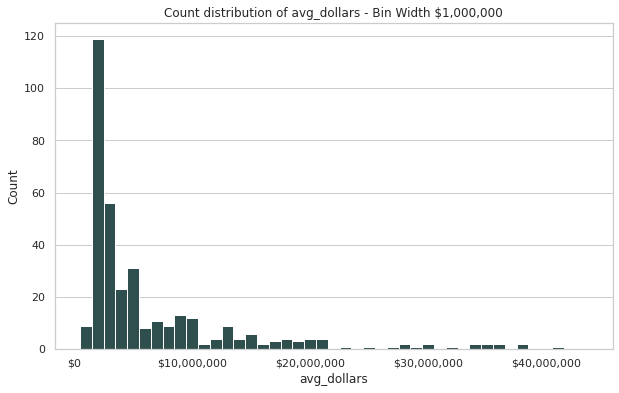

In [25]:
bins = [i for i in range(500000, 44500000, 1000000)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(contracts['avg_dollars'], bins=bins, color="darkslategray")
axes.set_xticks([0, 10000000, 20000000, 30000000, 40000000])
axes.set_xticklabels(['$0', '$10,000,000', '$20,000,000', '$30,000,000', '$40,000,000'])
axes.set_title("Count distribution of avg_dollars - Bin Width $1,000,000")
axes.set_xlabel('avg_dollars')
axes.set_ylabel('Count')
axes.yaxis.grid(True)
axes.xaxis.grid(False)

plt.show()
plt.close()

A majority of the contracts signed were under 5,000,000 dollars, specifically between 1 and 1.5 million dollars. This make sense as a lot of rookie and minimum contracts are likely in this range. I will look to the other statistics to see if I can distinquish between the different contract values.

### position

position is the position of the player plays. Position is categorical variable and is represented by a string. The distribution of the different positions should be roughly evenly distributed, although Center is a less prominent position in today's game, so this position might be slightly less represented.

Here are the value counts for position

In [26]:
pd.DataFrame(contracts['position'].value_counts())

,position
SG,86
PF,79
PG,72
C,66
SF,52


The number of each position represented in the dataset definitely isn't evenly distributed. This is likely a result of the particular free agents from these years. Taking a look at these value counts in a chart:

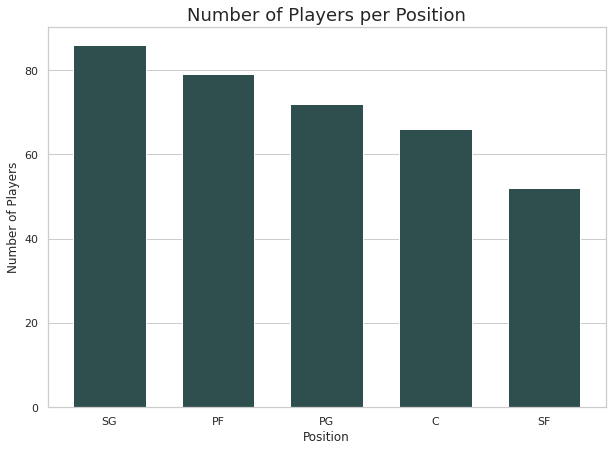

In [27]:
width = 1/1.5
x = range(len(contracts['position'].value_counts().values))

figure = plt.figure(figsize=(10, 7))
axes = figure.add_subplot(1, 1, 1)
axes.bar(x, contracts['position'].value_counts().values, width, color='darkslategray', align='center')
axes.set_xticks([0, 1, 2, 3, 4])
axes.set_xticklabels(['SG', 'PF', 'PG', 'C', 'SF'])
axes.set_title('Number of Players per Position', fontsize=18)
axes.set_xlabel('Position')
axes.set_ylabel('Number of Players')
axes.yaxis.grid(b=True, which='major')
axes.xaxis.grid(b=False)

plt.show()
plt.close()

### height

position is how tall the player is in inches. Height is a numeric variable and is represented by an int. The distribution of the height should be roughly normally distributed, as there is likely an mean height in the NBA and most heights are likely centered around this mean.

Here are some descriptive statistics:

In [28]:
descriptive_stats_single_numeric(contracts['height'])

,Stats
count,355.00
mean,78.39
std,3.40
min,69.00
25%,76.00
50%,78.00
75%,81.00
max,89.00
range,20.00
iqr,5.00


The mean and median are very similar, suggesting that the prediction that the data follows a normal distribution was likely a good one. Let's take a look at a histogram.

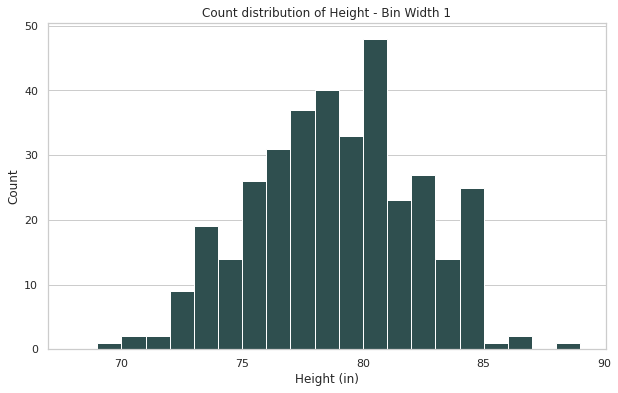

In [29]:
bins = [i for i in range(68, 90, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(contracts['height'], bins=bins, color="darkslategray")
axes.set_title("Count distribution of Height - Bin Width 1")
axes.set_xlabel('Height (in)')
axes.set_ylabel('Count')
axes.yaxis.grid(True)
axes.xaxis.grid(False)

plt.show()
plt.close()

The data is not exactly normally distributed and appears to be reach a peak just to the right of the mean.

### weight

weight is how much the player weighs in pounds. Weight is a numeric variable and is represented by an int. The distribution of the weight should be roughly normally distributed, as there is likely an weight height in the NBA and most weights are likely centered around this mean.

Here are some descriptive statistics:

In [30]:
descriptive_stats_single_numeric(contracts['weight'])

,Stats
count,355.00
mean,219.01
std,25.12
min,167.00
25%,200.00
50%,217.00
75%,237.50
max,311.00
range,144.00
iqr,37.50


The mean and median are very similar, suggesting that the prediction that the data follows a normal distribution was probably pretty accurate. Let's take a look at a histogram.

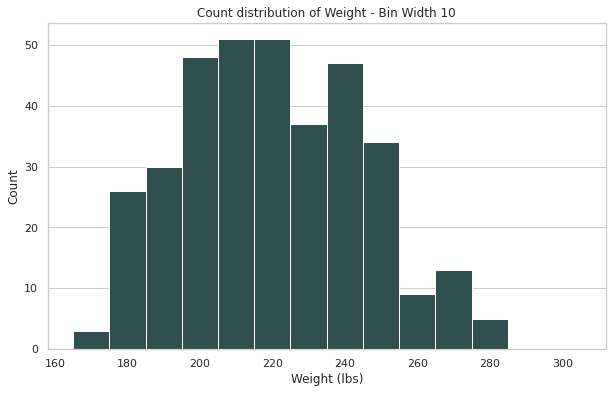

In [31]:
bins = [i for i in range(165, 311, 10)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(contracts['weight'], bins=bins, color="darkslategray")
axes.set_title("Count distribution of Weight - Bin Width 10")
axes.set_xlabel('Weight (lbs)')
axes.set_ylabel('Count')
axes.yaxis.grid(True)
axes.xaxis.grid(False)

plt.show()
plt.close()

The data does appear to follow a normal distribution fairly closely.

### age

age is how old the player was when they signed the free agent contract. Age is a numeric variable and is represented by a float. There are likely more younger players (under the age of 24) than older players because many players play for a couple years and then fall out of the league. Thus, I expect the younger ages to be highly represented in this analysis.

Here are some descriptive statistics:

In [32]:
descriptive_stats_single_numeric(contracts['age'])

,Stats
count,355.00
mean,34.12
std,105.86
min,20.70
25%,25.35
50%,28.10
75%,31.05
max,"2,021.70"
range,"2,001.00"
iqr,5.70


It appears that there may be an age that is incorrect in the dataset. Let's take a look at the players that are over the age of 45, as there should be no players over this age.

In [33]:
contracts[contracts['age']>45]

,player,year,position,height,weight,age,years_exp,games,min,pts,...,fg,fg_per,three_fg,three_per,efg_per,ft_per,type,chg_team,length,avg_dollars
350,Jarrell Brantley,2021,PF,77,250,"2,021.70",1,28,4.90,2.30,...,0.90,0.48,0.40,0.43,0.60,1.00,RFA,0,1,1669178


This is an error on the website, as Jarrell Brantley is listed as 2021.70 years old. The [NBA website](https://www.nba.com/stats/player/1629714/career/) lists Mr. Brantley's birthday as 06/07/1996, which would make him roughly 25.1 years old when he signed this contract. I will adjust his age in `contracts`.

In [34]:
contracts.at[350, 'age'] = 25.1

Checking to see that Jarrell Brantley's age is fixed and there are no other ages greater than 45.

In [35]:
contracts.loc[350]

player         Jarrell Brantley
year                       2021
position                     PF
height                       77
weight                      250
age                       25.10
years_exp                     1
games                        28
min                        4.90
pts                        2.30
rbs                        1.00
ast                        0.50
stl                        0.30
blk                        0.10
tov                        0.30
fg                         0.90
fg_per                     0.48
three_fg                   0.40
three_per                  0.43
efg_per                    0.60
ft_per                     1.00
type                        RFA
chg_team                      0
length                        1
avg_dollars             1669178
Name: 350, dtype: object

In [36]:
contracts[contracts['age']>45]

,player,year,position,height,weight,age,years_exp,games,min,pts,...,fg,fg_per,three_fg,three_per,efg_per,ft_per,type,chg_team,length,avg_dollars


I will also update the database so as not to include this error in the future.

In [37]:
con.execute('''
UPDATE contracts
SET age = 25.1
WHERE name = "Jarrell Brantley"
''')
con.commit()

Checking to make sure this update completed properly with a simple query.

In [38]:
query = """
SELECT *
FROM contracts
WHERE name = "Jarrell Brantley"
"""

temp = pd.DataFrame(con.execute(query),
                         columns=['id', 'year', 'name', 'age', 'type', 'old_team', 'new_team',
                                  'chg_team', 'length', 'total_dollars', 'avg_dollars'])
temp

,id,year,name,age,type,old_team,new_team,chg_team,length,total_dollars,avg_dollars
0,621,2021,Jarrell Brantley,25.10,RFA,UTH,UTH,0,1,1669178,1669178


Ok, now that that is fixed, back to descriptive statistics.

In [39]:
descriptive_stats_single_numeric(contracts['age'])

,Stats
count,355.00
mean,28.50
std,4.00
min,20.70
25%,25.30
50%,28.10
75%,31.00
max,42.60
range,21.90
iqr,5.70


The mean age is close to the median. However, the distance from the minimum to the median is much smaller than the distance from the median to the maximum, suggesting the data will be skewed to the right.

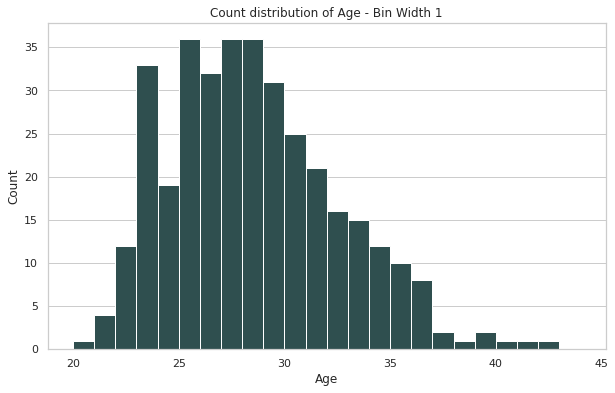

In [40]:
bins = [i for i in range(20, 45, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(contracts['age'], bins=bins, color="darkslategray")
axes.set_title("Count distribution of Age - Bin Width 1")
axes.set_xlabel('Age')
axes.set_ylabel('Count')
axes.yaxis.grid(True)
axes.xaxis.grid(False)

plt.show()
plt.close()

The data is skewed to the right, but it is a lot closer to normally distributed than I expected.

### years_exp

years_exp is how many years the player has been in the NBA. Year_exp is a numeric variable and is represented by an int. years_exp is probably highly related to age, as players typically come into the league around the same age (between 19-21). Therefore, I expect the distribution of years_exp to be very similar to that of age.

Here are some descriptive statistics:

In [41]:
descriptive_stats_single_numeric(contracts['years_exp'])

,Stats
count,355.00
mean,5.79
std,4.11
min,0.00
25%,3.00
50%,5.00
75%,8.00
max,20.00
range,20.00
iqr,5.00


The mean is slightly bigger than the median, suggesting the data will be skewed to the right. However, the distance from the minimum to the median is much smaller than the distance from the median to the maximum, suggesting that the distribution will be more heavily skewed than `age`.

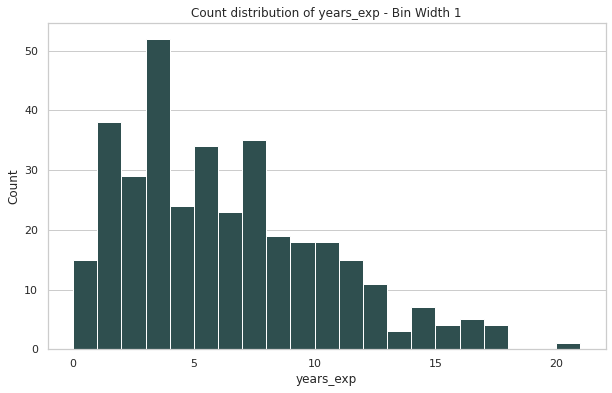

In [42]:
bins = [i for i in range(0, 22, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(contracts['years_exp'], bins=bins, color="darkslategray")
axes.set_title("Count distribution of years_exp - Bin Width 1")
axes.set_xlabel('years_exp')
axes.set_ylabel('Count')
axes.yaxis.grid(True)
axes.xaxis.grid(False)

plt.show()
plt.close()

The data is more heavily skewed to the right. We see some spikes at year 3, 5, and 7. This makes sense as this corresponds to some of the timelines of rookie contracts and rookie extensions, where a lot of players will be entering free agency.

### games

games is how many games the player played in the season before they hit free agency. Games is a numeric variable and is represented by an int. games is probably skewed to the left, with most players entering free agency likely playing around 60-70 games the year before.

Here are some descriptive statistics:

In [43]:
descriptive_stats_single_numeric(contracts['games'])

,Stats
count,355.00
mean,51.80
std,19.21
min,1.00
25%,39.00
50%,56.00
75%,66.00
max,82.00
range,81.00
iqr,27.00


The mean is smaller than the median, suggesting the data will be skewed to the left. Taking a look at the histogram:

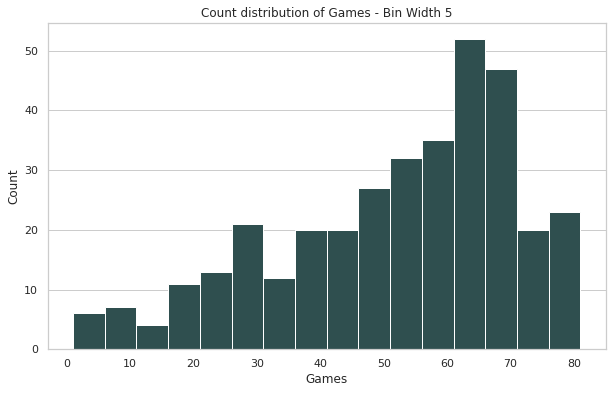

In [44]:
bins = [i for i in range(1, 82, 5)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(contracts['games'], bins=bins, color="darkslategray")
axes.set_title("Count distribution of Games - Bin Width 5")
axes.set_xlabel('Games')
axes.set_ylabel('Count')
axes.yaxis.grid(True)
axes.xaxis.grid(False)

plt.show()
plt.close()

The data is heavily skewed to the right, although there are some players that played very few games the year before entering free agency. As I expected, it seems like most players played between 60 and 70 games.

### min

min is how many minutes the player played per game the year before entering free agency. Min is a numeric variable and is represented by a float. There is likely an mean number of minutes per game played in the NBA with most players playing a number of minutes somewhere around this mean. Therefore, I expect the distribution of min to roughly follow a normal distribution.

Here are some descriptive statistics:

In [45]:
descriptive_stats_single_numeric(contracts['min'])

,Stats
count,355.00
mean,20.76
std,7.45
min,2.00
25%,15.70
50%,20.90
75%,26.45
max,35.70
range,33.70
iqr,10.75


The mean number of minutes is very similar to the median. However, the difference between the minimum and median min is much larger than the difference between the median and the maximum number of minutes, suggesting the data could be skewed to the left.

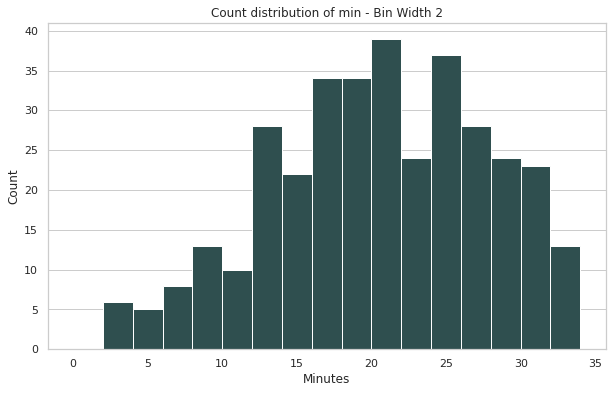

In [46]:
bins = [i for i in range(0, 36, 2)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(contracts['min'], bins=bins, color="darkslategray")
axes.set_title("Count distribution of min - Bin Width 2")
axes.set_xlabel('Minutes')
axes.set_ylabel('Count')
axes.yaxis.grid(True)
axes.xaxis.grid(False)

plt.show()
plt.close()

The data is skewed to the right a little, but aside from some players playing exceptionally low amounts, there is a semblance of a normal distribution.

### pts

pts is how many points the player scored per game the year before entering free agency. pts is a numeric variable and is represented by a float. As there are a group of players that score a considerable amount more than other players, I expected this data to be slightly skewed to the right. Also, as this is per game data, it is possible the data roughly follows a Poisson distribution.

Here are some descriptive statistics:

In [47]:
descriptive_stats_single_numeric(contracts['pts'])

,Stats
count,355.00
mean,8.86
std,5.01
min,0.10
25%,5.40
50%,7.70
75%,11.25
max,26.60
range,26.50
iqr,5.85


The mean number of minutes is larger than the median and the difference between the minimum and median min is much smaller than the difference between the median and the maximum number of minutes, suggesting the data is likely skewed to the right.

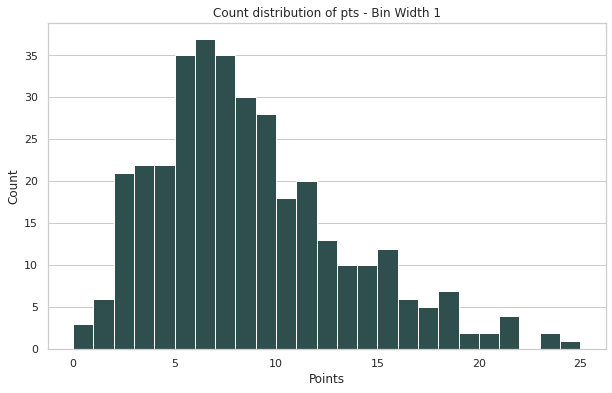

In [48]:
bins = [i for i in range(0, 26, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(contracts['pts'], bins=bins, color="darkslategray")
axes.set_title("Count distribution of pts - Bin Width 1")
axes.set_xlabel('Points')
axes.set_ylabel('Count')
axes.yaxis.grid(True)
axes.xaxis.grid(False)

plt.show()
plt.close()

The data is skewed to the right a little. While I definitely would not say the data follows a Poisson distribution, the outline of that shape is apparent in the data.

### rbs

rbs is how many rebounds the player grabbed per game the year before entering free agency. Rbs is a numeric variable and is represented by a float. Unlike points, I think the number of rebounds players grab is likely more closer to a normal distribution, as there are less extreme rebounding numbers as opposed to points. Still, as this is per game data, rebounds could roughly follow a Poisson distribution.

Here are some descriptive statistics:

In [49]:
descriptive_stats_single_numeric(contracts['rbs'])

,Stats
count,355.00
mean,3.82
std,2.10
min,0.30
25%,2.40
50%,3.50
75%,4.90
max,13.50
range,13.20
iqr,2.50


The mean number of rebounds is very similar to the median. However, the difference between the minimum and median rebounds grabbed is much smaller than the difference between the median and the maximum number of rebounds per game, suggesting the data should be skewed right.

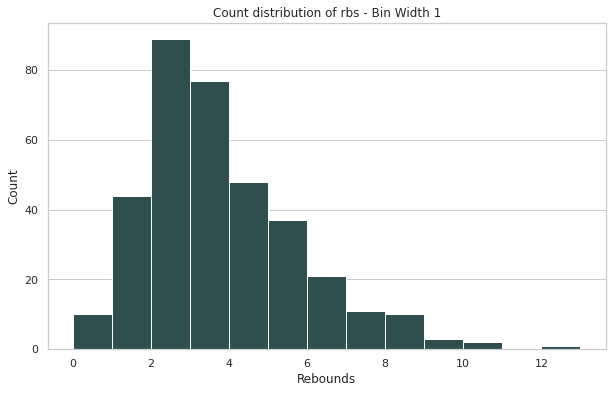

In [50]:
bins = [i for i in range(0, 14, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(contracts['rbs'], bins=bins, color="darkslategray")
axes.set_title("Count distribution of rbs - Bin Width 1")
axes.set_xlabel('Rebounds')
axes.set_ylabel('Count')
axes.yaxis.grid(True)
axes.xaxis.grid(False)

plt.show()
plt.close()

The data is skewed to the right and unlike my prediction, more closely resembles a Poisson distribution than a normal distribution.

### ast

ast is how many assists the player had per game the year before entering free agency. Ast is a numeric variable and is represented by a float. I believe assists will have a similar distribution to that of rebounds, although I am guessing the maximum number of assists per game will be lower than the maximum rebounds per game.

Here are some descriptive statistics:

In [51]:
descriptive_stats_single_numeric(contracts['ast'])

,Stats
count,355.00
mean,1.90
std,1.51
min,0.00
25%,0.90
50%,1.50
75%,2.30
max,8.90
range,8.90
iqr,1.40


The mean number of assists is very smaller and slightly larger than the median. I believe that it is a safe prediction to safe this data will be heavily skewed to the right.

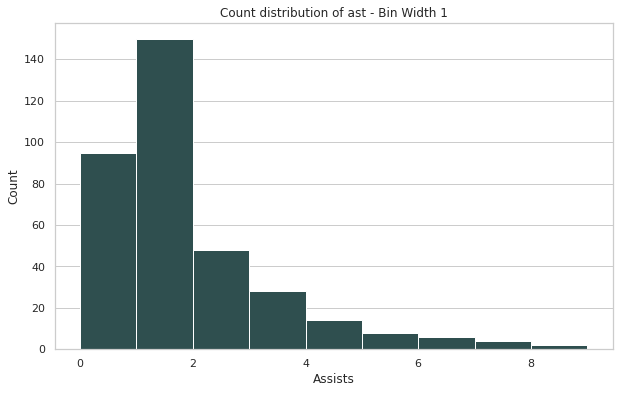

In [52]:
bins = [i for i in range(0, 10, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(contracts['ast'], bins=bins, color="darkslategray")
axes.set_title("Count distribution of ast - Bin Width 1")
axes.set_xlabel('Assists')
axes.set_ylabel('Count')
axes.yaxis.grid(True)
axes.xaxis.grid(False)

plt.show()
plt.close()

As expected the data is heavily skewed to the right. The data appears to very closely follow a Poisson distribution.

### stl

stl is how many steals the player had per game the year before entering free agency. Stl is a numeric variable and is represented by a float. I believe steals will have a similar distribution to assists, but the range for steals will be much smaller.
Here are some descriptive statistics:

In [53]:
descriptive_stats_single_numeric(contracts['stl'])

,Stats
count,355.00
mean,0.66
std,0.36
min,0.00
25%,0.40
50%,0.60
75%,0.90
max,2.00
range,2.00
iqr,0.50


The mean number of steals is higher than the median and the distance between the minimum and the median is much smaller than the distance between the median and the maximum. Thus, I believe the data skewed to the right.

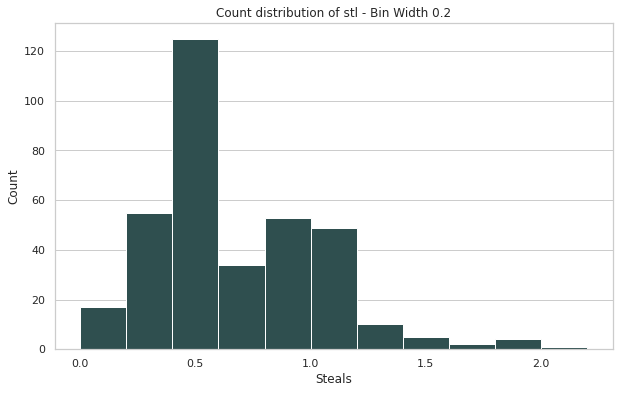

In [54]:
bins = [0.2*i for i in range(0, 12, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(contracts['stl'], bins=bins, color="darkslategray")
axes.set_title("Count distribution of stl - Bin Width 0.2")
axes.set_xlabel('Steals')
axes.set_ylabel('Count')
axes.yaxis.grid(True)
axes.xaxis.grid(False)

plt.show()
plt.close()

As expected the data is heavily skewed to the right and roughly follows the outline of a Poisson distribution.

### blk

blk is how many blocks the player made per game the year before entering free agency. Blk is a numeric variable and is represented by a float. I believe blocks will have a very similar distribution to steals and I think the range for the values of blocks will be very similar to steals as well.

Here are some descriptive statistics:

In [55]:
descriptive_stats_single_numeric(contracts['blk'])

,Stats
count,355.00
mean,0.42
std,0.39
min,0.00
25%,0.20
50%,0.30
75%,0.50
max,2.90
range,2.90
iqr,0.30


The difference between the minimum and median number of blocks per game is much smaller than the difference between the median and maximum number of blocks, so the data should be heavily skewed right.

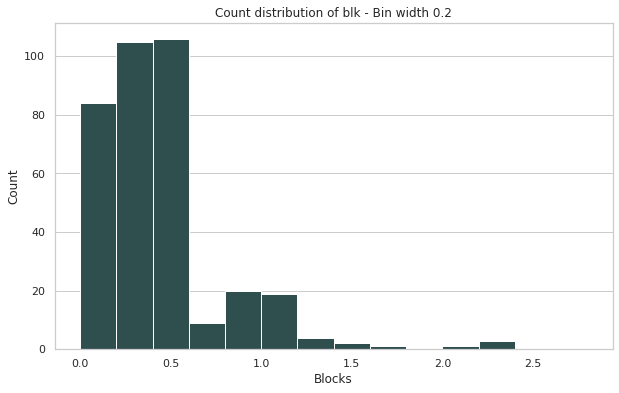

In [56]:
bins = [0.2*i for i in range(0, 15, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(contracts['blk'], bins=bins, color="darkslategray")
axes.set_title("Count distribution of blk - Bin width 0.2")
axes.set_xlabel('Blocks')
axes.set_ylabel('Count')
axes.yaxis.grid(True)
axes.xaxis.grid(False)

plt.show()
plt.close()

The large majority of players have 0.6 blocks per game or less, with just a relatively few players having more.

### tov

tov is how many times the player turned the ball over per game the year before entering free agency. Tov is a numeric variable and is represented by a float. I believe turnovers could be more normally distributed than some of the other features, but there is still a chance the data roughly follows a Poisson distribution because it is per game data.

Here are some descriptive statistics:

In [57]:
descriptive_stats_single_numeric(contracts['tov'])

,Stats
count,355.00
mean,1.04
std,0.58
min,0.00
25%,0.70
50%,0.90
75%,1.30
max,3.10
range,3.10
iqr,0.60


While the difference between the distance from the minimum and median and the distance between the median and the maximum still suggests that the data is skewed right, it does not appear to be quite as skewed as some of the other features. Taking a look at the histogram of the data:

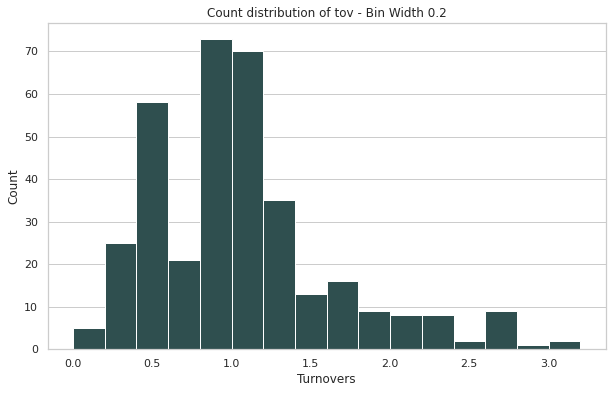

In [58]:
bins = [0.2*i for i in range(0, 17, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(contracts['tov'], bins=bins, color="darkslategray")
axes.set_title("Count distribution of tov - Bin Width 0.2")
axes.set_xlabel('Turnovers')
axes.set_ylabel('Count')
axes.yaxis.grid(True)
axes.xaxis.grid(False)

plt.show()
plt.close()

While the data may be less skewed than the other features, it is definitely still skewed right. Also, there is a strange gap in the 0.6-0.8 turnovers range. 

### fg

fg, or field goals, is the number shots the player made per game the year before entering free agency. fg is a numeric variable and is represented by a float since it is an average. As points is very closely related to the number of shots the player makes, I believe field goals will have a very similar distribution to points.

Here are some descriptive statistics:

In [59]:
descriptive_stats_single_numeric(contracts['fg'])

,Stats
count,355.00
mean,3.28
std,1.81
min,0.00
25%,2.05
50%,2.90
75%,4.10
max,9.30
range,9.30
iqr,2.05


The mean is larger than the median and the distance between the minimum and median is smaller than the distance from the median to the maximum. For these reasons, I think the data will be skewed right.

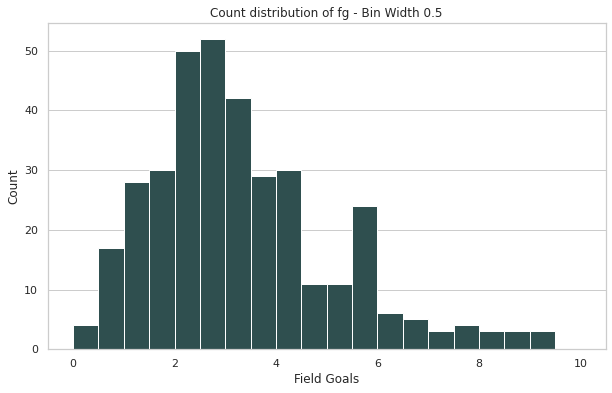

In [60]:
bins = [0.5*i for i in range(0, 21, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(contracts['fg'], bins=bins, color="darkslategray")
axes.set_title("Count distribution of fg - Bin Width 0.5")
axes.set_xlabel('Field Goals')
axes.set_ylabel('Count')
axes.yaxis.grid(True)
axes.xaxis.grid(False)

plt.show()
plt.close()

Much like most of the features in the data set, the distribution is skewed right.

### fg_per

fg_per, or field goal percentage, is the percentage of shots the player takes that he makes the season before entering free agency. fg_per is a numeric variable and is represented by a float between 0 and 1. As this feature is a proportion, I think that it is more likely to follow a rough normal distribution.

Here are some descriptive statistics:

In [61]:
descriptive_stats_single_numeric(contracts['fg_per'])

,Stats
count,355.00
mean,0.46
std,0.09
min,0.00
25%,0.41
50%,0.45
75%,0.50
max,1.00
range,1.00
iqr,0.09


Compared to the other features, the mean is much closer to the median. Let's see what the distribution of the feature looks like in a histogram.

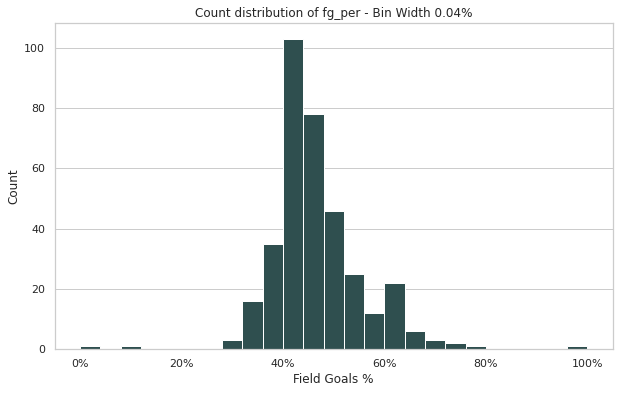

In [62]:
bins = [0.04*i for i in range(0, 26, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(contracts['fg_per'], bins=bins, color="darkslategray")
axes.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
axes.set_title("Count distribution of fg_per - Bin Width 0.04%")
axes.set_xlabel('Field Goals %')
axes.set_ylabel('Count')
axes.yaxis.grid(True)
axes.xaxis.grid(False)

plt.show()
plt.close()

While there are some extreme values, this feature is much closer to a normal distribution. However, the data is still slightly skewed to the right. Zooming in on the main portion of the data might show this better.

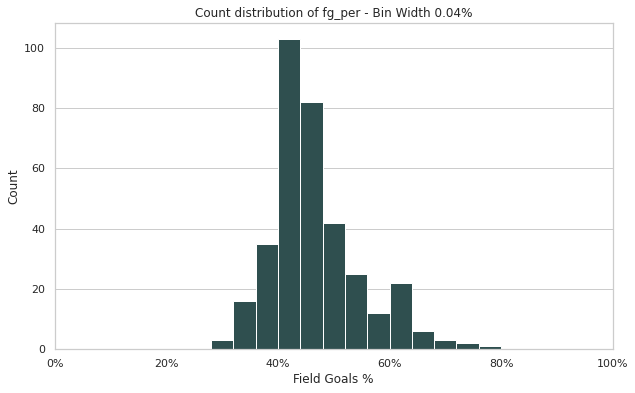

In [63]:
bins = [0.04*i+0.2 for i in range(0, 16, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(contracts['fg_per'], bins=bins, color="darkslategray")
axes.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
axes.set_title("Count distribution of fg_per - Bin Width 0.04%")
axes.set_xlabel('Field Goals %')
axes.set_ylabel('Count')
axes.yaxis.grid(True)
axes.xaxis.grid(False)

plt.show()
plt.close()

Yes, this data is still skewed to the right.

### three_fg

three_fg, or three point field goals, is the number three point shots the player made per game the year before entering free agency. three_fg is a numeric variable and is represented by a float since it is an average. While not as skewed as some of the other statistics, I expect this feature to be skewed similar to fg.

Here are some descriptive statistics:

In [64]:
descriptive_stats_single_numeric(contracts['three_fg'])

,Stats
count,355.00
mean,1.01
std,0.80
min,0.00
25%,0.30
50%,0.90
75%,1.50
max,3.50
range,3.50
iqr,1.20


The mean is larger than the median and the median is closer to the minimum than the maximum, suggesting the data will be skewed to the right.

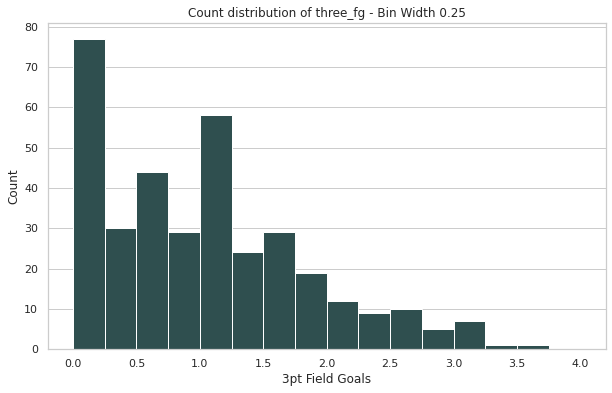

In [65]:
bins = [0.25*i for i in range(0, 17, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(contracts['three_fg'], bins=bins, color="darkslategray")
axes.set_title("Count distribution of three_fg - Bin Width 0.25")
axes.set_xlabel('3pt Field Goals')
axes.set_ylabel('Count')
axes.yaxis.grid(True)
axes.xaxis.grid(False)

plt.show()
plt.close()

The distribution is closer to an exponential distribution than a Poission distribution. The distribution makes sense due to the fact that a lot of post players do not take many threes.

## three_per

three_per, or three point field goal percentage, is the percentage of three point shots the player takes that he makes the season before entering free agency. three_per is a numeric variable and is represented by a float between 0 and 1. Like fg_per, I think this feature will be slightly skewed to the right with some extreme values.

Here are some descriptive statistics:

In [66]:
descriptive_stats_single_numeric(contracts['three_per'])

,Stats
count,355.00
mean,0.32
std,0.13
min,0.00
25%,0.29
50%,0.35
75%,0.39
max,1.00
range,1.00
iqr,0.10


The mean is slightly lower than the median, suggesting this distribution might be slightly skewed to the left. Also, much like I predicted, there appear to be some extreme values. Lastly, it is interesting to note that the IQR is very small for this particular feature.

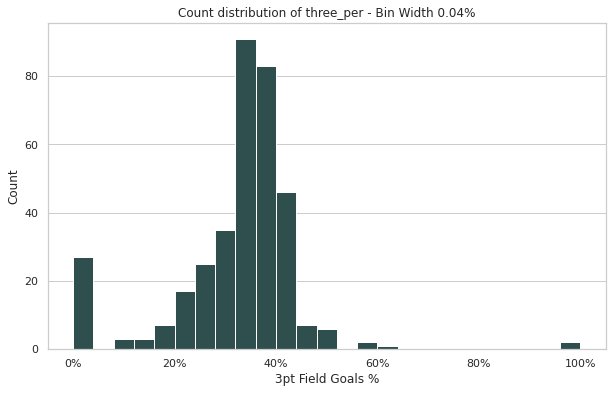

In [67]:
bins = [0.04*i for i in range(0, 26, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(contracts['three_per'], bins=bins, color="darkslategray")
axes.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
axes.set_title("Count distribution of three_per - Bin Width 0.04%")
axes.set_xlabel('3pt Field Goals %')
axes.set_ylabel('Count')
axes.yaxis.grid(True)
axes.xaxis.grid(False)

plt.show()
plt.close()

This distribution is very intersting because there is a spike at between 0.00 and 0.04. This is likely the group of players who do not shoot a large number of threes. Of the players we can assume tend to shoot more threes, most players shoot between 36-42%.

## efg_per

efg_per, or effective field goal percentage, is a weighted field goal percentage. It weights three point shots 1.5 times more than two point shots, as threes are more valuable. It has grown in popularity in recent years and has inspired other variations of weighted field goal percentages, such as True Shooting Percentage. [Here is a link](https://www.basketball-reference.com/about/glossary.html) to some definiteions of effective field goal percentage and true shooting percentage. 
<br>efg is a numeric variable and is represented by a float between 0 and 1. As effective field goal percentage is very closely related to field goal percentage, I believe efg_per will have a similar distribution to fg_per.

Here are some descriptive statistics:

In [68]:
descriptive_stats_single_numeric(contracts['efg_per'])

,Stats
count,355.00
mean,0.53
std,0.08
min,0.00
25%,0.49
50%,0.53
75%,0.57
max,1.00
range,1.00
iqr,0.08


The median and the mean are exactly the same and the first quartile and third quartile are evenly spaced around the mean. These values suggest the data might follow a normal distributed, let's take a look at the histogram.

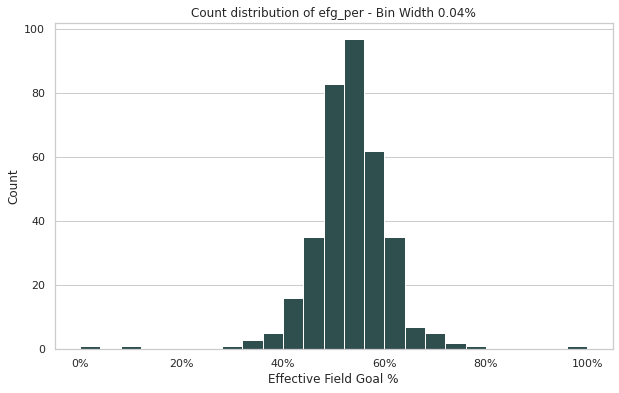

In [69]:
bins = [0.04*i for i in range(0, 26, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(contracts['efg_per'], bins=bins, color="darkslategray")
axes.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
axes.set_title("Count distribution of efg_per - Bin Width 0.04%")
axes.set_xlabel('Effective Field Goal %')
axes.set_ylabel('Count')
axes.yaxis.grid(True)
axes.xaxis.grid(False)

plt.show()
plt.close()

Unlike almost all of the other features, the data follows a rough normal distribution. Like the other percentage features, there are also some extreme values.

## ft_per

ft_per, or free throw percentage, is the percentage of free throws the player took that he made the season before entering free agency. ft_per is a numeric variable and is represented by a float between 0 and 1. As there are more players that shoot very high free throw percentages than lower ones, I think this feature will be skewed left.

Here are some descriptive statistics:

In [70]:
descriptive_stats_single_numeric(contracts['ft_per'])

,Stats
count,355.00
mean,0.75
std,0.13
min,0.00
25%,0.70
50%,0.78
75%,0.83
max,1.00
range,1.00
iqr,0.13


The mean is smaller than the median, suggesting the prediction that the data is skewed left might be a good one.

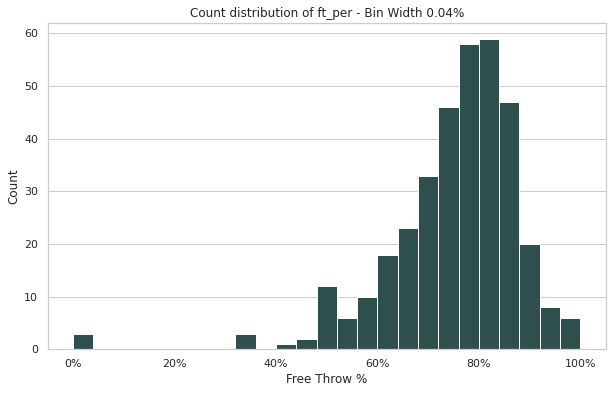

In [71]:
bins = [0.04*i for i in range(0, 26, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(contracts['ft_per'], bins=bins, color="darkslategray")
axes.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
axes.set_title("Count distribution of ft_per - Bin Width 0.04%")
axes.set_xlabel('Free Throw %')
axes.set_ylabel('Count')
axes.yaxis.grid(True)
axes.xaxis.grid(False)

plt.show()
plt.close()

The free throw percentage does appear to be skewed to the left.

### type

type is the type of contract that the player signs. I expect that RFA, restricted free agent, and UFA, unrestricted free agent, will be in the dataset, but I am not sure if there will be any other types. Let's run a value counts to see if the data set has any other types.

In [72]:
pd.DataFrame(contracts['type'].value_counts())

,type
UFA,302
RFA,53


As we can see from the table, these are the only two types of contracts signed. As RFA contracts are only signed by players after their rookie deals, it does not surprise me that there are a lot more examples of UFA in the dataset.

### chg_team

chg_team is a boolean value that shows whether or not the free agent signed with a new team. If the player resigned with the same team, the chg_team value is 0. If they signed with a new team, the chg_team value is 1. Taking a look at the value counts of the `chg_team`.

In [73]:
pd.DataFrame(contracts['chg_team'].value_counts())

,chg_team
1,219
0,136


As we can see from the table, it looks like roughly $\frac{2}{3}$ of players changed teams in this data set.

### length

length is the number of years of the contract that the player signed. As NBA players can sign between 1 and 5 year contracts, the values for `length` should be between 1 and 5. Let's do a quick value counts to see if this is in fact the case.

In [74]:
pd.DataFrame(contracts['length'].value_counts())

,length
1,151
2,104
3,59
4,32
5,9


As we can see here, the shorter contracts are more common. A histogram will show this downward trend very clearly.

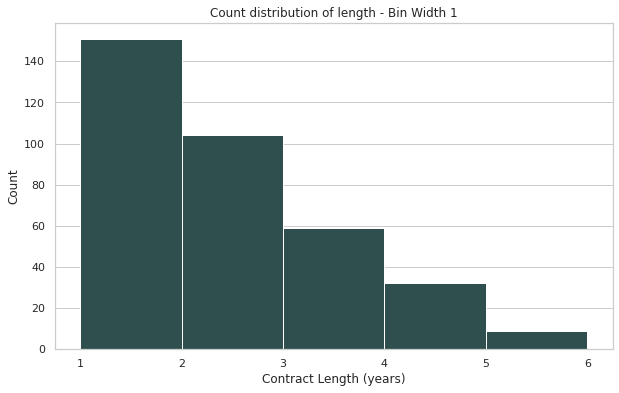

In [75]:
bins = [i for i in range(1, 7, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(contracts['length'], bins=bins, color="darkslategray")
axes.set_title("Count distribution of length - Bin Width 1")
axes.set_xlabel('Contract Length (years)')
axes.set_ylabel('Count')
axes.yaxis.grid(True)
axes.xaxis.grid(False)

plt.show()
plt.close()

**Single Variable EDA Thoughts:** One thing that stands out in particular from the single variable EDA is that many of the features in the data set have values that are skewed to the right. Also, many of the features roughly follow a Poisson distribution, which makes sense because the data is per game statistics.

## Two Variable EDA

After looking into each of the variables individually, I will move on to looking at the relationships between multiple variables. I will not check every single the relationship between every single pair of features, but I will pay particular attention to the relationship between each variable and `avg_dollars` and any pairs that are likely related to one another.

### avg_dollars vs pts

I will start two variable EDA by looking at the relationship between avg_dollars and points. Points is the statistic that gets the most attention by the media and when deciding awards, so there is likely a decent relationship between salary and points. 

I will start by looking at the values of Pearson's and Spearman's correlation coefficients to see if there appears to be a relationship between the two features.

In [76]:
print("r   = ", stats.pearsonr( contracts['avg_dollars'], contracts['pts'])[0])
print("rho = ", stats.spearmanr( contracts['avg_dollars'], contracts['pts'])[0])

r   =  0.7656338638695737
rho =  0.690041342372558


There appears to be a relatively strong positive relationship between points per game and avg_dollars. Let's take a look at what the scatter plot for this relationship looks like.

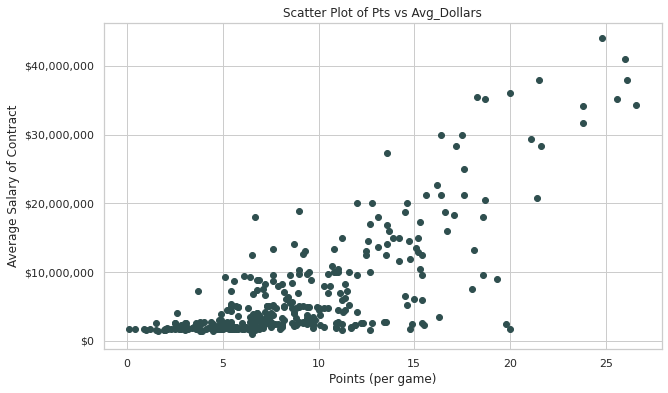

In [77]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['pts'], contracts['avg_dollars'], marker="o", color="darkslategray")
axes.set_yticks([0, 10000000, 20000000, 30000000, 40000000])
axes.set_yticklabels(['$0', '$10,000,000', '$20,000,000', '$30,000,000', '$40,000,000'])
axes.set_xlabel("Points (per game)")
axes.set_ylabel("Average Salary of Contract")
axes.set_title("Scatter Plot of Pts vs Avg_Dollars")

plt.show()
plt.close()

There is a large cluster of players making fairly lower salaries that had anywhere from 0 to 20 points per game. However, a large majority of the time, the players who are signing the largest contracts are the players who score the most points.

### avg_dollars vs age

Next, I will take a look at the relationship between avg_dollars and age. I hypothesize that middle aged players, likely between 24-32 will make more money than the younger and older players. This is because younger players are likely getting rookie deals and the older players are likely on the down slope of their career.

In [78]:
print("r   = ", stats.pearsonr( contracts['avg_dollars'], contracts['age'])[0])
print("rho = ", stats.spearmanr( contracts['avg_dollars'], contracts['age'])[0])

r   =  0.04768423514756636
rho =  0.28483384893138164


There does not appear to be any linear relationship. Let's see if the scatter plot confirms my hypothesis about middle aged players.

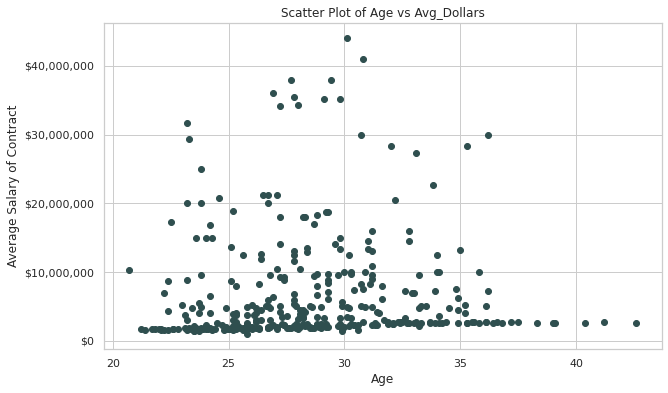

In [79]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['age'], contracts['avg_dollars'], marker="o", color="darkslategray")
axes.set_yticks([0, 10000000, 20000000, 30000000, 40000000])
axes.set_yticklabels(['$0', '$10,000,000', '$20,000,000', '$30,000,000', '$40,000,000'])
axes.set_xlabel("Age")
axes.set_ylabel("Average Salary of Contract")
axes.set_title("Scatter Plot of Age vs Avg_Dollars")

plt.show()
plt.close()

The middle age players are the players that make the higher salaries. However, the key for this project will be figuring out what seperates the players that make the minimum salary (the straight line on the bottom) and the players that get the higher salaries.

### age vs. years_exp

Before moving on to compare the next feature with avg_dollars, I want to check the relationship between age and years_exp. As players often come into the league around the same age, it is likely that there is a strong relationship between the two.

I will start by looking at the values of Pearson's and Spearman's correlation coefficients:

In [80]:
print("r   = ", stats.pearsonr( contracts['age'], contracts['years_exp'])[0])
print("rho = ", stats.spearmanr( contracts['age'], contracts['years_exp'])[0])

r   =  0.9055220445655147
rho =  0.8824345031355126


There appears to be a very strong relationship between the two. Let's have a look at the scatter plot of these two features.

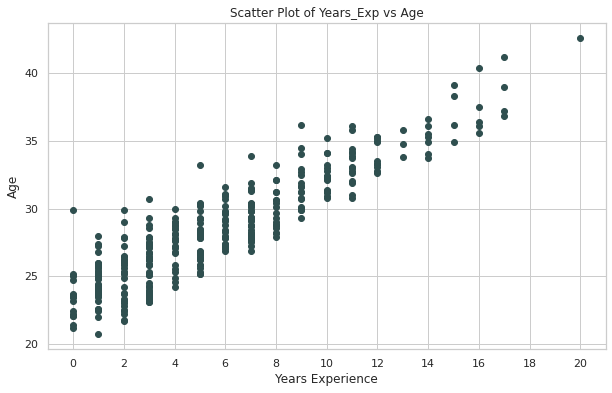

In [81]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['years_exp'], contracts['age'], marker="o", color="darkslategray")
axes.set_xticks(list(range(0, 22, 2)))
axes.set_xlabel("Years Experience")
axes.set_ylabel("Age")
axes.set_title("Scatter Plot of Years_Exp vs Age")

plt.show()
plt.close()

There is definitely a strong relationship between these two features. This is something that I will keep in mind when building the model, as the one of the features likely does not need to be included. From an abstract point of view, it seems more correct to say age leads to years of experience, as opposed to years of experience leading to age. This along with the fact that the distribution for age is smoother than years means I will likely use age in the model.

### avg_dollars vs height

Next, I will take a look at the relationship between avg_dollars and height. You often heare people say that taller people would be better basketball players, but do taller baskeatball players make more money? I believe there are valuable players at all different heights, as teams need good guards, wings, and bigs. Thus, I don't expect much of a relationship between height and avg_dollars.

Taking a look at the values of Pearson's and Spearman's correlation coefficients:

In [82]:
print("r   = ", stats.pearsonr( contracts['avg_dollars'], contracts['height'])[0])
print("rho = ", stats.spearmanr( contracts['avg_dollars'], contracts['height'])[0])

r   =  -0.02463303725115754
rho =  0.02854322973801204


The value for r and rho are extremely low. The scatter plot should show no relation.

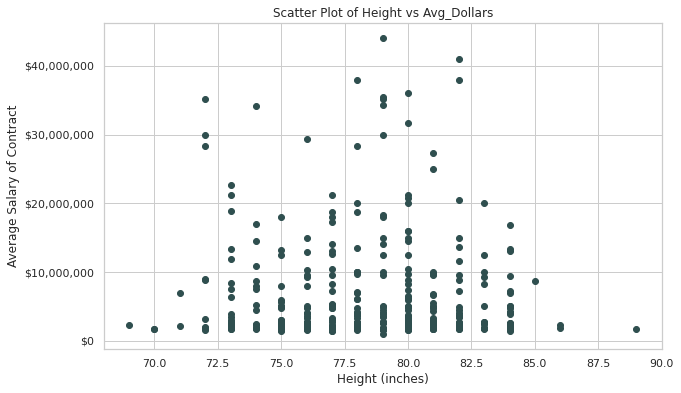

In [83]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['height'], contracts['avg_dollars'], marker="o", color="darkslategray")
axes.set_yticks([0, 10000000, 20000000, 30000000, 40000000])
axes.set_yticklabels(['$0', '$10,000,000', '$20,000,000', '$30,000,000', '$40,000,000'])
axes.set_xlabel("Height (inches)")
axes.set_ylabel("Average Salary of Contract")
axes.set_title("Scatter Plot of Height vs Avg_Dollars")

plt.show()
plt.close()

As we can see from the scatter plot, the salaries of these free agents varies for each of the different heights. If we look at the heights between 72 inches and 84 inches (6ft and 7ft), the only real thing that stands out is that these players are more common than players outside of this range.

### avg_dollars vs games

Now I will take a look at the relationship between avg_dollars and games. The players that are the better players on their team likely play in all the games they can, so their is likely a positive relationship between games played and salary. However, sometimes better players get injured or rest for some games, so this relationship likely won't be perfect.

Taking a look at the values of Pearson's and Spearman's correlation coefficients:

In [84]:
print("r   = ", stats.pearsonr( contracts['avg_dollars'], contracts['games'])[0])
print("rho = ", stats.spearmanr( contracts['avg_dollars'], contracts['games'])[0])

r   =  0.3818571547702418
rho =  0.5497478313425618


There is a positive relationship, but it is a pretty weak relationship. This seems to confirm the hypothesize that they will be related, but not perfectly.

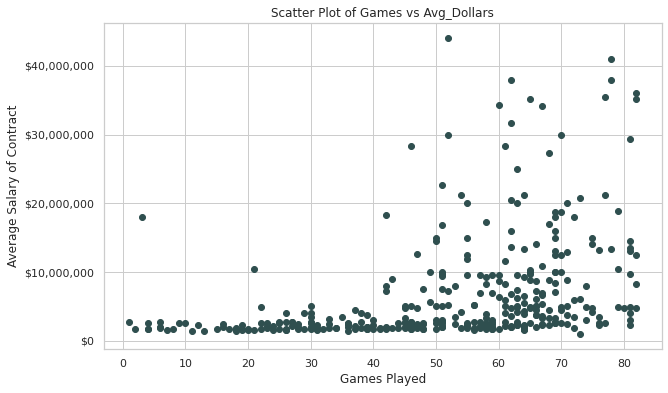

In [85]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['games'], contracts['avg_dollars'], marker="o", color="darkslategray")
axes.set_yticks([0, 10000000, 20000000, 30000000, 40000000])
axes.set_yticklabels(['$0', '$10,000,000', '$20,000,000', '$30,000,000', '$40,000,000'])
axes.set_xlabel("Games Played")
axes.set_ylabel("Average Salary of Contract")
axes.set_title("Scatter Plot of Games vs Avg_Dollars")

plt.show()
plt.close()

We see with only two exceptions, everyone who played under 40 games made less than 10,000,000 dollars. However, when we get to players that played at least 40 games, the salaries are fairly varied.

### avg_dollars vs min

Now I will take a look at the relationship between avg_dollars and min. The best players usually play the most minutes, so I expect there to be a positive relationship between minutes and salary. Also, minutes is a per game statistic, which I think will make the strength of the relationship even higher.

Taking a look at the values of Pearson's and Spearman's correlation coefficients:

In [86]:
print("r   = ", stats.pearsonr( contracts['avg_dollars'], contracts['min'])[0])
print("rho = ", stats.spearmanr( contracts['avg_dollars'], contracts['min'])[0])

r   =  0.6319826309683474
rho =  0.7134223592073188


The correlation coefficients suggest there is a positive relationship between the two features. However, it is not as quite as strong as I would have expected. Let's take a look at the scatter plot.

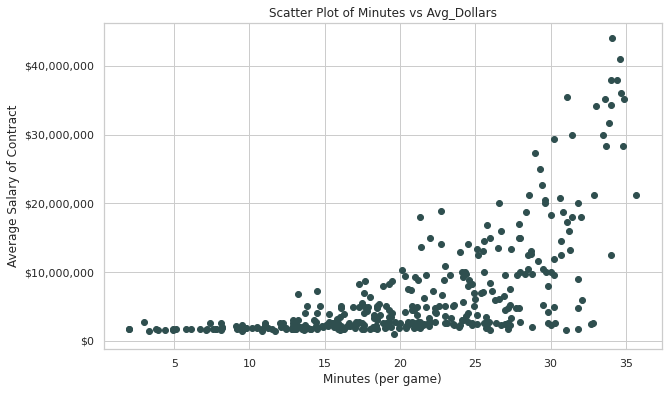

In [87]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['min'], contracts['avg_dollars'], marker="o", color="darkslategray")
axes.set_yticks([0, 10000000, 20000000, 30000000, 40000000])
axes.set_yticklabels(['$0', '$10,000,000', '$20,000,000', '$30,000,000', '$40,000,000'])
axes.set_xlabel("Minutes (per game)")
axes.set_ylabel("Average Salary of Contract")
axes.set_title("Scatter Plot of Minutes vs Avg_Dollars")

plt.show()
plt.close()

We see the players that make the most money typically play the most minutes. Also, there is a decent curve in the data, suggesting there could be an exponential relationship at play.

### games vs min

As games and minutes both give information about how much a player played, I want to check if there is a relationship between these two features. This is to check if these to time related statistics could be an example of multicolinearity when it comes time to build models.

Taking a look at the values of Pearson's and Spearman's correlation coefficients:

In [88]:
print("r   = ", stats.pearsonr( contracts['games'], contracts['min'])[0])
print("rho = ", stats.spearmanr( contracts['games'], contracts['min'])[0])

r   =  0.5477649442912628
rho =  0.5228569856758358


There does seem to be a little relationship between the two. Let's take a look at the scatter plot of the two features.

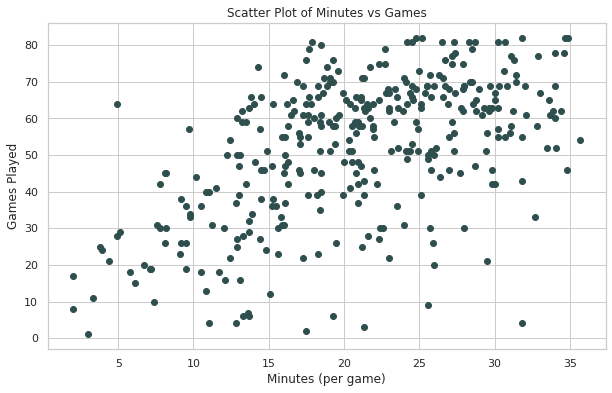

In [89]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['min'], contracts['games'], marker="o", color="darkslategray")
axes.set_xlabel("Minutes (per game)")
axes.set_ylabel("Games Played")
axes.set_title("Scatter Plot of Minutes vs Games")

plt.show()
plt.close()

Again, there does appear to be at least a little bit of relationship between the two. This is something I will keep in mind when it comes time to build the model.

### avg_dollars vs reb



After looking at some information about the players themselves and some features about playing time, we will move on to some of the other statistics related to the player's performance. In terms of salary and rebounds, I hypothesize that players who get more rebounds are more likely to make more money than players who do not grab a lot of rebounds.

Taking a look at the values of Pearson's and Spearman's correlation coefficients:

In [90]:
print("r   = ", stats.pearsonr( contracts['avg_dollars'], contracts['rbs'])[0])
print("rho = ", stats.spearmanr( contracts['avg_dollars'], contracts['rbs'])[0])

r   =  0.37604626251923245
rho =  0.5283421827829052


There does not appear to be a very strong linear relationship between the two from the value of Pearson's correlation coefficient. Let's take a look at what the scatter plot looks like.

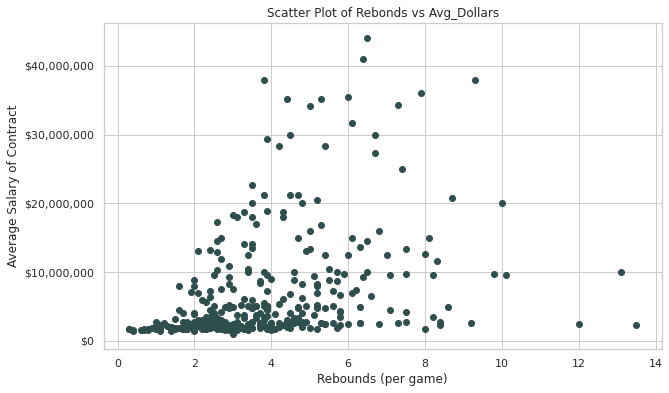

In [91]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['rbs'], contracts['avg_dollars'], marker="o", color="darkslategray")
axes.set_yticks([0, 10000000, 20000000, 30000000, 40000000])
axes.set_yticklabels(['$0', '$10,000,000', '$20,000,000', '$30,000,000', '$40,000,000'])
axes.set_xlabel("Rebounds (per game)")
axes.set_ylabel("Average Salary of Contract")
axes.set_title("Scatter Plot of Rebonds vs Avg_Dollars")

plt.show()
plt.close()

There seems to be some sort of a loose linear relationship, however, the low salary values for the three players who averaged 12 rebounds per game or more seem to go against this relationship. 

### avg_dollars vs min

Now I will take a look at the relationship between avg_dollars and ast. As assists are a statistic that a lot of teams want, I believe that players who get a lot of assists will make more than players that do not. However, there are likely plenty of players who get paid very well, but have low assist numbers.

Taking a look at the values of Pearson's and Spearman's correlation coefficients:

In [92]:
print("r   = ", stats.pearsonr( contracts['avg_dollars'], contracts['ast'])[0])
print("rho = ", stats.spearmanr( contracts['avg_dollars'], contracts['ast'])[0])

r   =  0.5278476542324199
rho =  0.48347478862744636


The value of Pearson's correlation coefficient is higher for assists than it was for rebounds. Let's see what the scatter plot comparing assists and avg_dollars looks like.

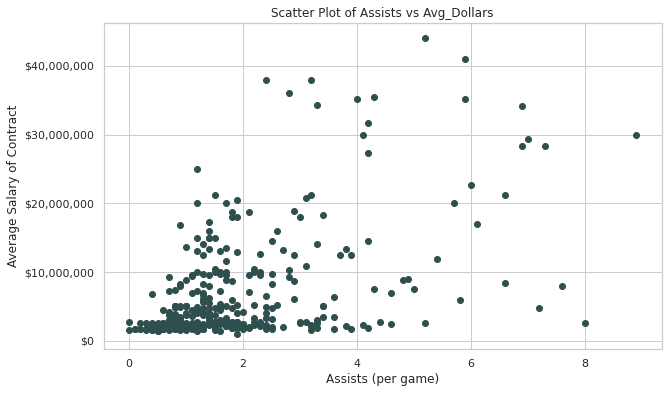

In [93]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['ast'], contracts['avg_dollars'], marker="o", color="darkslategray")
axes.set_yticks([0, 10000000, 20000000, 30000000, 40000000])
axes.set_yticklabels(['$0', '$10,000,000', '$20,000,000', '$30,000,000', '$40,000,000'])
axes.set_xlabel("Assists (per game)")
axes.set_ylabel("Average Salary of Contract")
axes.set_title("Scatter Plot of Assists vs Avg_Dollars")

plt.show()
plt.close()

Much like rebounds, there are a couple of players who signed lower valued contracts and had higher assist numbers. However, you can see the upward trend in salary as assists increase.

### avg_dollars vs stl

Now I will take a look at the relationship between avg_dollars and stl. Steals are an interesting statistic because while teams are interested in players that play good defense and, thus, steal the ball a lot, I imagine that there are a lot of players with a high number of steals compared to other players that are paid extremely high. Thus, I predict that there will not be a strong relationship between steals and salary.

Taking a look at the values of Pearson's and Spearman's correlation coefficients:

In [94]:
print("r   = ", stats.pearsonr( contracts['avg_dollars'], contracts['ast'])[0])
print("rho = ", stats.spearmanr( contracts['avg_dollars'], contracts['ast'])[0])

r   =  0.5278476542324199
rho =  0.48347478862744636


While these correlation coeffecient values are not super high, they are higher than I expected. Let's take a look at what the scatter plot looks like.

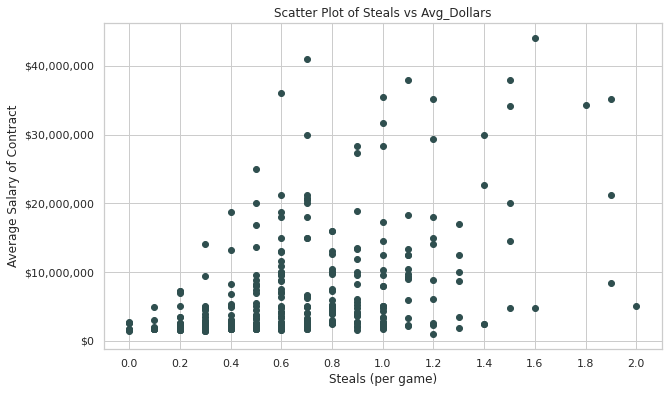

In [95]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['stl'], contracts['avg_dollars'], marker="o", color="darkslategray")
axes.set_xticks([0.2*i for i in range(0, 11, 1)])
axes.set_yticks([0, 10000000, 20000000, 30000000, 40000000])
axes.set_yticklabels(['$0', '$10,000,000', '$20,000,000', '$30,000,000', '$40,000,000'])
axes.set_xlabel("Steals (per game)")
axes.set_ylabel("Average Salary of Contract")
axes.set_title("Scatter Plot of Steals vs Avg_Dollars")

plt.show()
plt.close()

One thing to note from this chart is that a large number of players in the data set do not get very many steals per game. While there is an upward trend, there are a relatively small number of players who have a lot of steals compared to those with a lower number of steals.

### avg_dollars vs blk

Now I will take a look at the relationship between avg_dollars and blk. Blocks are a very important statistics for big men and post players. Thus, I expect that the big men who are paid a lot of money tend to have a high number of steals. However, there are a decent number of big men who are not paid a lot of money and there are plenty of guards who are paid a lot that block very few shots. Thus, I don't really have a prediction about the relationship between blocks and salary.

Taking a look at the values of Pearson's and Spearman's correlation coefficients:

In [96]:
print("r   = ", stats.pearsonr( contracts['avg_dollars'], contracts['blk'])[0])
print("rho = ", stats.spearmanr( contracts['avg_dollars'], contracts['blk'])[0])

r   =  0.18030975418614087
rho =  0.29819226315776803


These correlations are pretty low, suggesting there is not much of a relationship between blocks and salary.

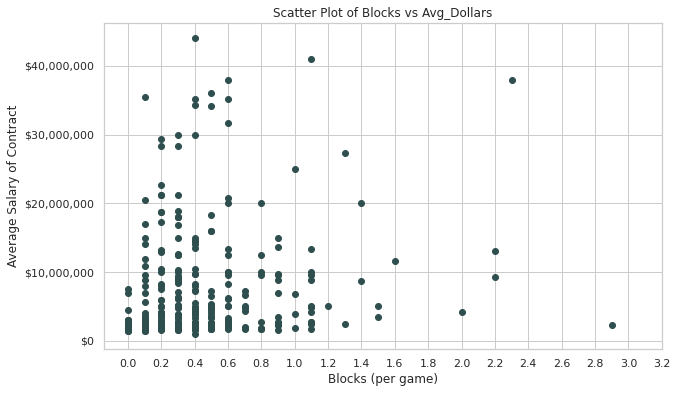

In [97]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['blk'], contracts['avg_dollars'], marker="o", color="darkslategray")
axes.set_xticks([0.2*i for i in range(0, 17, 1)])
axes.set_yticks([0, 10000000, 20000000, 30000000, 40000000])
axes.set_yticklabels(['$0', '$10,000,000', '$20,000,000', '$30,000,000', '$40,000,000'])
axes.set_xlabel("Blocks (per game)")
axes.set_ylabel("Average Salary of Contract")
axes.set_title("Scatter Plot of Blocks vs Avg_Dollars")

plt.show()
plt.close()

There does not appear to be much of a relationship between blocks and salary overall. Again, we should keep in mind that the vast majority of players do not block many shots. It might be interesting to see how blocks relate to salary for just the centers.

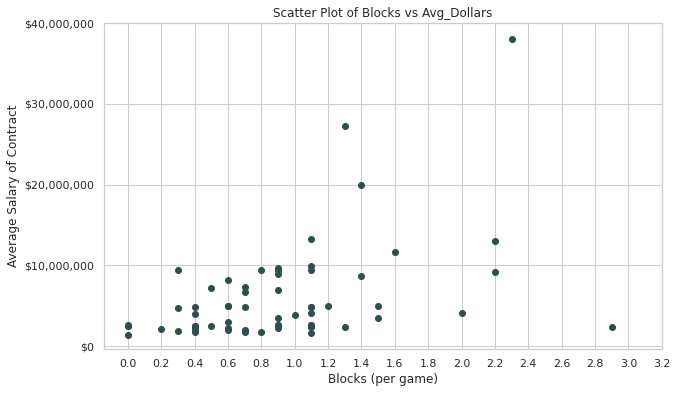

In [98]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['blk'][contracts['position']=='C'], contracts['avg_dollars'][contracts['position']=='C'],
                 marker="o", color="darkslategray")
axes.set_xticks([0.2*i for i in range(0, 17, 1)])
axes.set_yticks([0, 10000000, 20000000, 30000000, 40000000])
axes.set_yticklabels(['$0', '$10,000,000', '$20,000,000', '$30,000,000', '$40,000,000'])
axes.set_xlabel("Blocks (per game)")
axes.set_ylabel("Average Salary of Contract")
axes.set_title("Scatter Plot of Blocks vs Avg_Dollars")

plt.show()
plt.close()

This seems to show a little bit more of a relationship. What are the values of the correlation coefficients?

In [99]:
print("r   = ", stats.pearsonr( contracts['avg_dollars'][contracts['position']=='C'],
                                   contracts['blk'][contracts['position']=='C'])[0])
print("rho = ", stats.spearmanr( contracts['avg_dollars'][contracts['position']=='C'],
                                   contracts['blk'][contracts['position']=='C'])[0])

r   =  0.449305848611137
rho =  0.434556070042819


While not super strong, this is more of a correlation than for all players. Something to keep in mind.

### avg_dollars vs tov

Now I will take a look at the relationship between avg_dollars and tov. Turnovers are a negative statistic, that is, you want a player to have a low number of turnovers. However, better players usually have the ball more than other players and often have higher turnover numbers simply because of the volume of time they have the ball. Therefore, I actually thing there might be a strong positive relationship between turnovers and salary.

Taking a look at the values of Pearson's and Spearman's correlation coefficients:

In [100]:
print("r   = ", stats.pearsonr( contracts['avg_dollars'], contracts['tov'])[0])
print("rho = ", stats.spearmanr( contracts['avg_dollars'], contracts['tov'])[0])

r   =  0.5848969578753296
rho =  0.5675790257507441


It looks like there could be some validity to my prediction. Let's take a look at the scatter plot.

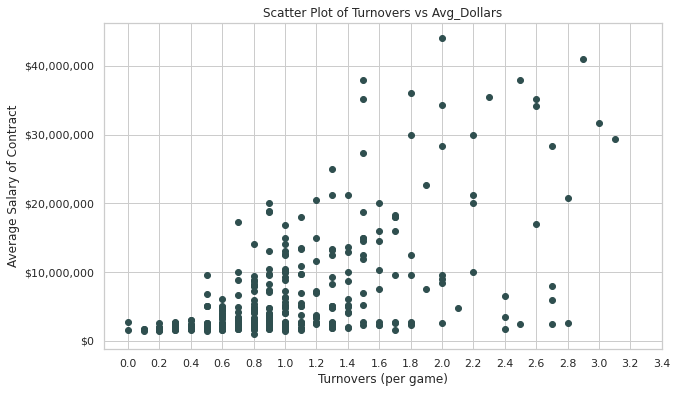

In [101]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['tov'], contracts['avg_dollars'], marker="o", color="darkslategray")
axes.set_xticks([0.2*i for i in range(0, 18, 1)])
axes.set_yticks([0, 10000000, 20000000, 30000000, 40000000])
axes.set_yticklabels(['$0', '$10,000,000', '$20,000,000', '$30,000,000', '$40,000,000'])
axes.set_xlabel("Turnovers (per game)")
axes.set_ylabel("Average Salary of Contract")
axes.set_title("Scatter Plot of Turnovers vs Avg_Dollars")

plt.show()
plt.close()

Based on the values for the correlation coeffecient and the scatter plot, it seems like the idea that the players who turn the ball over a lot might be making more money because them turning the ball over a lot means they have the ball a lot.

### points and fg

Before moving into the statistics about field goals and percentages and how they relate to salary. I want to take a look at pairs of features that do not include avg_salary. This is because the statistics about field goals and percentages, as well, as points likely have a high amount of overlap. Thus, I want to look into this to be wary of multicolinearity for later.

First, I will look at the relationship between points and field goals, or shots made. There is likely a very strong relationship here because making shots directly leads to points. The only way someone can score points without making a field goal is by making free throws, which are not considered field goals. Thus, I expect there to be a high positive correlation between points and field goals.

Taking a look at the values of Pearson's and Spearman's correlation coefficients:

In [102]:
print("r   = ", stats.pearsonr( contracts['fg'], contracts['pts'])[0])
print("rho = ", stats.spearmanr( contracts['fg'], contracts['pts'])[0])

r   =  0.9872947560574356
rho =  0.9868674299953958


As expected, the correlation is practically identical. The scatter plot should almost be a straight line.

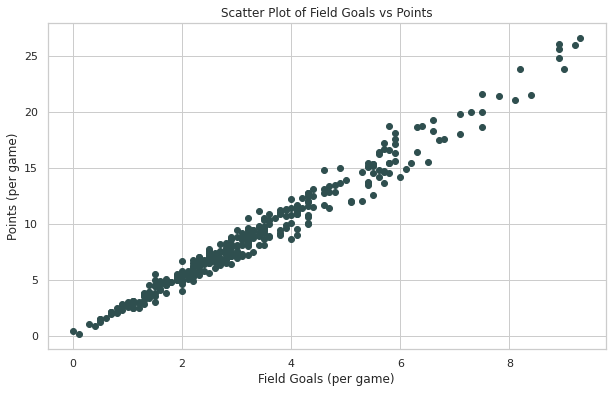

In [103]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['fg'], contracts['pts'], marker="o", color="darkslategray")
axes.set_xlabel("Field Goals (per game)")
axes.set_ylabel("Points (per game)")
axes.set_title("Scatter Plot of Field Goals vs Points")

plt.show()
plt.close()

There is no real reason to include both of these in the model. Thus, moving forward, I won't really look to much into field goals and will stick with points.

### points and fg_per

Second, I will look at the relationship between points and field goal percentage. I do not think there will be that strong of a relationship between these. Players with high field goal percentages are often players who take most of their shots around the basket, like centers. However, these players often do not take a lot of shots and do not shoot many three point shots. Also, players who score a lot often take a lot of tough shots, meaning there percentage is usually slightly lower. I think there might be some positive relationship, but I do not expect it to be exorbantly high.

Taking a look at the values of Pearson's and Spearman's correlation coefficients:

In [104]:
print("r   = ", stats.pearsonr( contracts['fg_per'], contracts['pts'])[0])
print("rho = ", stats.spearmanr( contracts['fg_per'], contracts['pts'])[0])

r   =  0.10754833309227281
rho =  0.18956710672513008


As expected, the relationship is not very strong. However, even though I predicted this correctly, I am very interested to see what the scatter plot will look like.

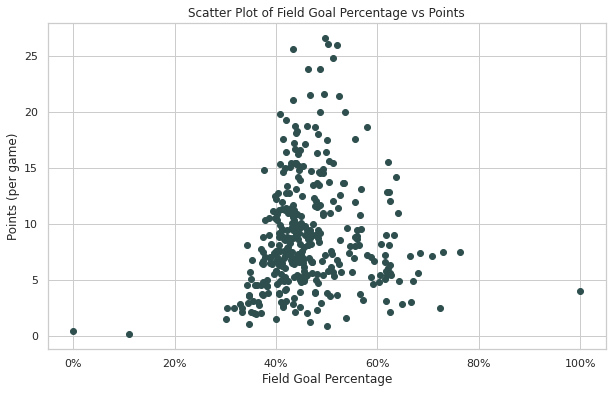

In [105]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['fg_per'], contracts['pts'], marker="o", color="darkslategray")
axes.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
axes.set_xlabel("Field Goal Percentage")
axes.set_ylabel("Points (per game)")
axes.set_title("Scatter Plot of Field Goal Percentage vs Points")

plt.show()
plt.close()

As we can see, the vast majority of players have field goal percentages between roughly 35% and 70% and the amount of points scored based upon field goal percentage varies widely.

### fg_per and efg_per

Next, I will look at the relationship between field goal percentage and effective field goal percentage. Based on how these statistics are calculated, effective field goal percentage will always be higher than field goal percentage. And as field goal percentage rises, effective field goal percentage will rise. It is just a matter of how much, which depends on how many three point shots the player takes and makes. Nevertheless, I expect there to be a very strong relationship between the two.

Taking a look at the values of Pearson's and Spearman's correlation coefficients:

In [106]:
print("r   = ", stats.pearsonr( contracts['fg_per'], contracts['efg_per'])[0])
print("rho = ", stats.spearmanr( contracts['fg_per'], contracts['efg_per'])[0])

r   =  0.8800174996419798
rho =  0.8206675336331267


As expected, the correlation coefficients are very high. Let's have a look at the scatter plot.

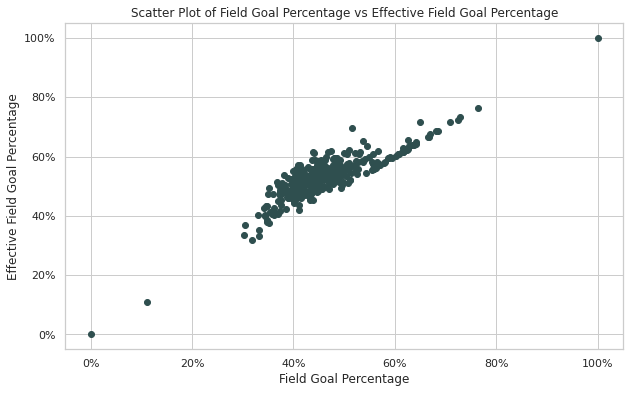

In [107]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['fg_per'], contracts['efg_per'], marker="o", color="darkslategray")
axes.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
axes.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
axes.set_xlabel("Field Goal Percentage")
axes.set_ylabel("Effective Field Goal Percentage")
axes.set_title("Scatter Plot of Field Goal Percentage vs Effective Field Goal Percentage")

plt.show()
plt.close()

While we cannot see exact values to to the clustering, the point is clearly made that they are highly correlated. I will take a closer look comparing each of these to avg_dollars to make a determination about which one to include in the model.

### three_fg and three_per

Next, I will look at the relationship between three point field goals made and three point field goal percentage. While there is likely a relationship between the two features, I am not sure how strong it will be. Mathematically speaking, if someone makes more shots, that will help their percentage of makes. However, it is very possible that someone, especially volume scorers, simply make a lot because they take a lot, not that they are making a higher percentage.

Taking a look at the values of Pearson's and Spearman's correlation coefficients:

In [108]:
print("r   = ", stats.pearsonr( contracts['three_fg'], contracts['three_per'])[0])
print("rho = ", stats.spearmanr( contracts['three_fg'], contracts['three_per'])[0])

r   =  0.4753359137186872
rho =  0.6287167542455576


It appears as if there is a mildly strong relationship between the two. Let's take a look at the scatter plot to get more info.

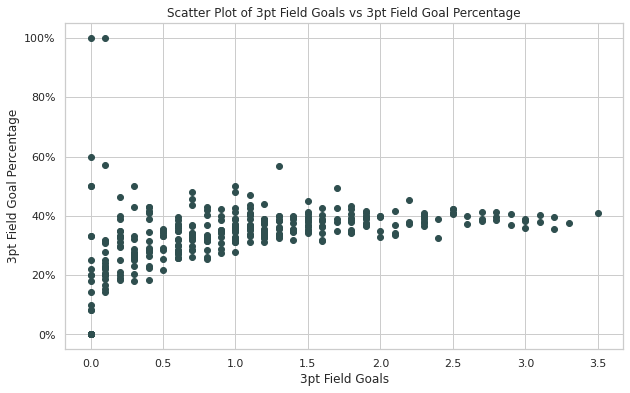

In [109]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['three_fg'], contracts['three_per'], marker="o", color="darkslategray")
axes.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
axes.set_xlabel("3pt Field Goals")
axes.set_ylabel("3pt Field Goal Percentage")
axes.set_title("Scatter Plot of 3pt Field Goals vs 3pt Field Goal Percentage")

plt.show()
plt.close()

It really seems like no matter how many three point shots the a player makes, most players hover between 20% and 45%. At the moment, I am not worried about these two features with regard to multicolinearity.

### fg_per and three_per

Before moving back to relationships with avg_dollars, I want to look at the relationship between field goal percentage and three point field goal percentage. As I mentioned earlier, a lot of players with very high field goal percentages typically take most of their shots around the basket. Thus, they are likely not very good three point shooters. While a player making a higher percentage on the subset of shots they take from three will help the overall percentage, I think the players making a high percentage of three point shots and the players making a high percentage of their overall shots are different players.

Taking a look at the values of Pearson's and Spearman's correlation coefficients:

In [110]:
print("r   = ", stats.pearsonr( contracts['fg_per'], contracts['three_per'])[0])
print("rho = ", stats.spearmanr( contracts['fg_per'], contracts['three_per'])[0])

r   =  -0.16466954981708085
rho =  -0.0077861814931234384


These correlation coeffecient values are very close to zero, suggesting there is very little relationship between the two. A scatter plot to take a look at this visually.

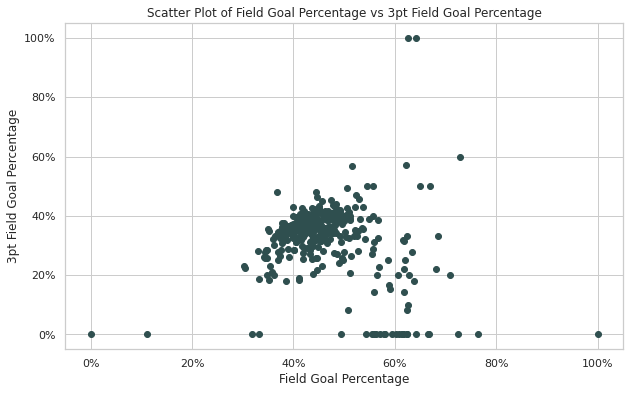

In [111]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['fg_per'], contracts['three_per'], marker="o", color="darkslategray")
axes.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
axes.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
axes.set_xlabel("Field Goal Percentage")
axes.set_ylabel("3pt Field Goal Percentage")
axes.set_title("Scatter Plot of Field Goal Percentage vs 3pt Field Goal Percentage")

plt.show()
plt.close()

There is no trend in this scatter plot to take away.

### avg_dollars vs fg_per

Returning back to average dollars, I will now take a look at the relationship between avg_dollars and field goal percentage. Teams want players who will make more shots, so I think there will be a positive relationship between field goal percentage and salary.

Taking a look at the values of Pearson's and Spearman's correlation coefficients:

In [112]:
print("r   = ", stats.pearsonr( contracts['avg_dollars'], contracts['fg_per'])[0])
print("rho = ", stats.spearmanr( contracts['avg_dollars'], contracts['fg_per'])[0])

r   =  0.06433361098435061
rho =  0.1746476316004869


Interestingly, there is a very low relationship between field goal percentage and avg_dollars. Let's take a look at the scatter plot to see what this looks like visually.

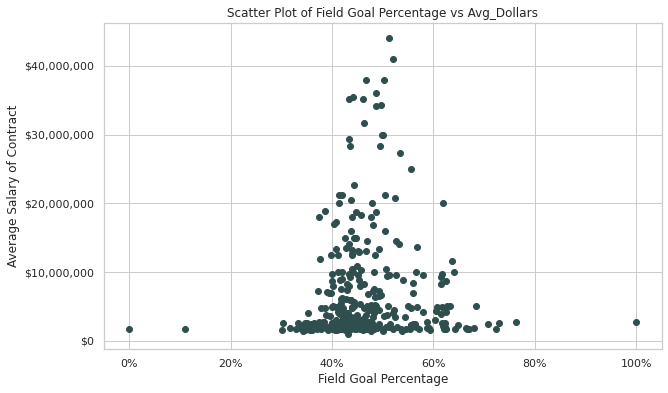

In [113]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['fg_per'], contracts['avg_dollars'], marker="o", color="darkslategray")
axes.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
axes.set_yticks([0, 10000000, 20000000, 30000000, 40000000])
axes.set_yticklabels(['$0', '$10,000,000', '$20,000,000', '$30,000,000', '$40,000,000'])
axes.set_xlabel("Field Goal Percentage")
axes.set_ylabel("Average Salary of Contract")
axes.set_title("Scatter Plot of Field Goal Percentage vs Avg_Dollars")

plt.show()
plt.close()

While up front it would seem like field goal percentage would be a think that led to a higher salary, the scatter plot and correlation coeffecients that increasing one's field goal percentage does not directly lead to a big pay day.

### avg_dollars vs efg_per

Next, I will take a look at effective field goal percentage and avg_dollars. Based on the results comparing avg_dollars and field goal percentage and the correlation between field goal percentage and effective field goal percentage, I don't think there will be much of a relationship between these two features.

Taking a look at the values of Pearson's and Spearman's correlation coefficients:

In [114]:
print("r   = ", stats.pearsonr( contracts['avg_dollars'], contracts['efg_per'])[0])
print("rho = ", stats.spearmanr( contracts['avg_dollars'], contracts['efg_per'])[0])

r   =  0.09093950708559338
rho =  0.17055766517098025


As predicted the relationship between effective field goal percentage and average dollars does not appear to be very strong..

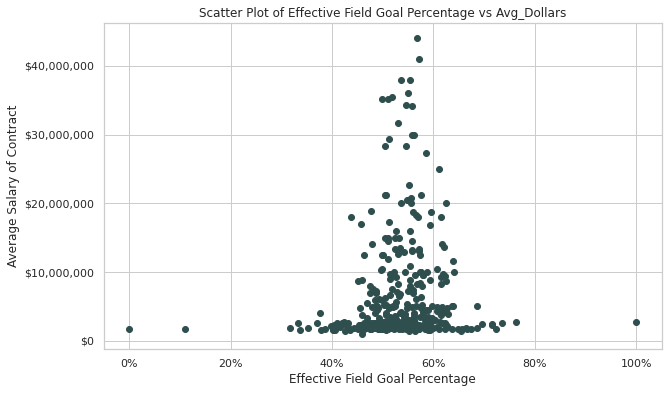

In [115]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['efg_per'], contracts['avg_dollars'], marker="o", color="darkslategray")
axes.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
axes.set_yticks([0, 10000000, 20000000, 30000000, 40000000])
axes.set_yticklabels(['$0', '$10,000,000', '$20,000,000', '$30,000,000', '$40,000,000'])
axes.set_xlabel("Effective Field Goal Percentage")
axes.set_ylabel("Average Salary of Contract")
axes.set_title("Scatter Plot of Effective Field Goal Percentage vs Avg_Dollars")

plt.show()
plt.close()

This scatter plot his almost the same exact shape as field goal percentage and avg_dollars, which is to be expected based on the strong correlation between field goal percentage and effective field goal percentage.

### avg_dollars vs three_fg

Next, I will take a look at three point field goals and avg_dollars. The three point shot is increasing in popularity and importance in today's NBA and teams are always looking to get players who can hit shots from the outside. Thus, I think that increasing the number of three point shots that someone hits will lead to an increased salary.

Taking a look at the values of Pearson's and Spearman's correlation coefficients:

In [116]:
print("r   = ", stats.pearsonr( contracts['avg_dollars'], contracts['three_fg'])[0])
print("rho = ", stats.spearmanr( contracts['avg_dollars'], contracts['three_fg'])[0])

r   =  0.48869378033404626
rho =  0.46118026377295884


The values for the correlation coefficient seem to suggest there is only a mild relationship between three point makes and average dollars. Let's take a look at what the scatter plot of these two features looks like.

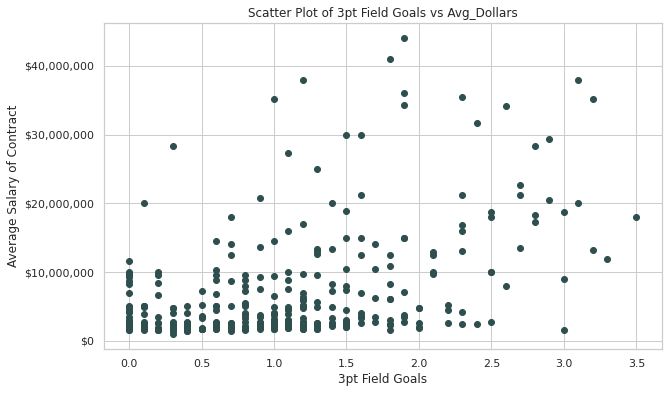

In [117]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['three_fg'], contracts['avg_dollars'], marker="o", color="darkslategray")
axes.set_yticks([0, 10000000, 20000000, 30000000, 40000000])
axes.set_yticklabels(['$0', '$10,000,000', '$20,000,000', '$30,000,000', '$40,000,000'])
axes.set_xlabel("3pt Field Goals")
axes.set_ylabel("Average Salary of Contract")
axes.set_title("Scatter Plot of 3pt Field Goals vs Avg_Dollars")

plt.show()
plt.close()

While the players who make over 2 three point shots per game due tend to have higher salaries, the wide range of salaries for players who make between 0.5 and 2 three point shots per game affects the correlation values.

### avg_dollars vs three_per

Next, I will take a look at three point field goal percentage and avg_dollars. Based on the results comparing avg_dollars with field goal percentage and effective field goal percentage, I don't think there will be much of a relationship between these two features.

Taking a look at the values of Pearson's and Spearman's correlation coefficients:

In [118]:
print("r   = ", stats.pearsonr( contracts['avg_dollars'], contracts['three_per'])[0])
print("rho = ", stats.spearmanr( contracts['avg_dollars'], contracts['three_per'])[0])

r   =  0.15450391760913348
rho =  0.22782938105410178


While I would by no means call these correlations high, they are higher than the correlation coeffecients comparing average dollars with field goal percentage and effective field goal percentage.

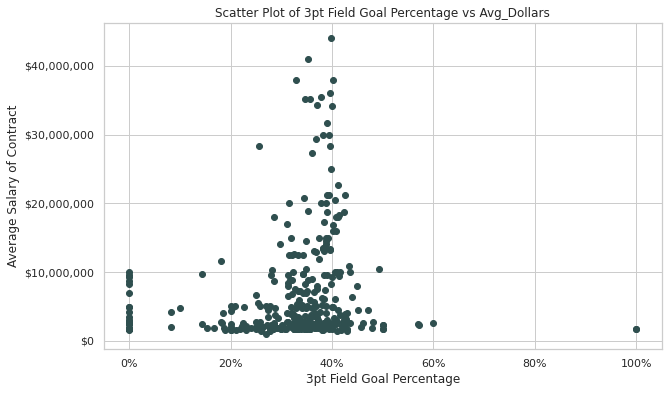

In [119]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['three_per'], contracts['avg_dollars'], marker="o", color="darkslategray")
axes.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
axes.set_yticks([0, 10000000, 20000000, 30000000, 40000000])
axes.set_yticklabels(['$0', '$10,000,000', '$20,000,000', '$30,000,000', '$40,000,000'])
axes.set_xlabel("3pt Field Goal Percentage")
axes.set_ylabel("Average Salary of Contract")
axes.set_title("Scatter Plot of 3pt Field Goal Percentage vs Avg_Dollars")

plt.show()
plt.close()

Again, this relationship is not super linear or strong. However, it does show that players who make above roughly 12 million dollars per season shot at least 30% or so from three.

### avg_dollars vs ft_per

Next, I will take a look at free throw percentage and avg_dollars. There have been plenty of great players in NBA history who have had very low free throw percentages and still signed large contracts, such as Giannis Antentokumpo and Shaquille O'Neal. Thus, it doesn't seem like a low free throw percentage hinders a team's willingness to pay a player, so I don't think there will be much of a relationship between free throw percentage and salary.

Taking a look at the values of Pearson's and Spearman's correlation coefficients:

In [120]:
print("r   = ", stats.pearsonr( contracts['avg_dollars'], contracts['ft_per'])[0])
print("rho = ", stats.spearmanr( contracts['avg_dollars'], contracts['ft_per'])[0])

r   =  0.27508846248894236
rho =  0.27423985978819354


As I expect, the correlation coefficients for this relationship are pretty low. Let's take a look at the scatter plot.

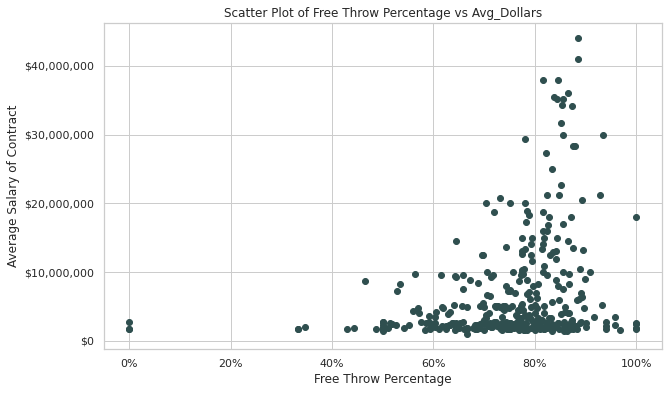

In [121]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( contracts['ft_per'], contracts['avg_dollars'], marker="o", color="darkslategray")
axes.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
axes.set_yticks([0, 10000000, 20000000, 30000000, 40000000])
axes.set_yticklabels(['$0', '$10,000,000', '$20,000,000', '$30,000,000', '$40,000,000'])
axes.set_xlabel("Free Throw Percentage")
axes.set_ylabel("Average Salary of Contract")
axes.set_title("Scatter Plot of Free Throw Percentage vs Avg_Dollars")

plt.show()
plt.close()

There does seem to be a slight increase in salary as free throw percentage increases. However, it this is by no means a home run correlation.

### avg_dollars vs position

To finish up EDA, I will take a look at how some of the categorical variables impact average dollars. First, I will look to see if a player's position effects average dollars. I believe that guards and wings, typically listed as PG, SG, or SF, will typically make more money than bigs, typically PF and C.

First, I will take a look at some descriptive statistics of average dollars for each of the different positions:

In [122]:
describe_by_category(contracts, 'avg_dollars', 'position')

,count,mean,std,min,25%,50%,75%,max
position,,,,,,,,
C,66.00,"5,781,659.94","6,064,590.89","1,445,697.00","2,392,615.00","3,662,650.00","7,268,750.00","37,980,720.00"
PF,79.00,"6,339,180.75","7,040,291.01","1,489,065.00","2,069,724.00","2,641,691.00","7,277,377.00","36,000,000.00"
PG,72.00,"7,731,439.14","8,470,846.93","1,445,697.00","2,028,594.00","3,400,000.00","9,335,150.50","35,197,650.00"
SF,52.00,"8,419,414.17","11,399,410.31","1,500,000.00","2,023,056.75","2,945,485.50","9,547,312.50","44,066,288.00"
SG,86.00,"6,132,279.83","6,580,344.03","898,310.00","1,961,661.00","3,162,500.00","8,000,000.00","37,980,720.00"


All of the positions have players that make under 1.5 million dollars and over 35 million dollars. However, the mean values are highest for PG and SF. Interestingly, C has the lowest mean salary, but the highest median salary. Let's take a look at some side by side box plots to get a better visual understanding of the differences in average dollars between the positions.

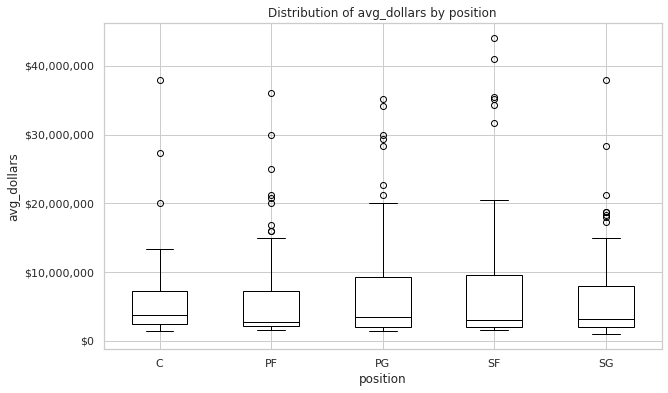

In [123]:
multiboxplot(contracts, 'avg_dollars', 'position', avg_dollars=True)

What these side by side box plots tell me that in the grand scheme of things, there are players at each position that sign large contracts. PF and SF might be slightly higher on average, but not a whole lot of difference by position.

### avg_dollars vs type

Next I will look at type of contract signed and average dollars. As we saw early, there are two types of contracts players can be signed to: Restricted Free Agent Contracts and Unrestricted Free Agent Contracts. Restricted Contracts are reserved for players who just finished there rookie deal and were not extended by their teams prior to the contract expiring. Unrestricted Contracts are for all other free agents. In general, the salaries that first time free agents, those signing restricted contracts, are capped below what someone who has been in the league for longer can make. Additionally, players that are going to sign maximum contracts after there rookie deals were likely extended by their teams and would not be in this data set. Therefore, I believe that people signing Restricted Contracts will not be as high as Unrestricted, but the mean value of these contracts is probaly at or slighlty above the mean for Unrestricted Contracts.

First, I will take a look at some descriptive statistics of average dollars for each of the different contract types:

In [124]:
describe_by_category(contracts, 'avg_dollars', 'type')

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
RFA,53.00,"8,182,842.57","7,849,054.41","1,445,697.00","2,080,000.00","4,374,000.00","12,640,000.00","31,650,600.00"
UFA,302.00,"6,524,978.14","7,872,290.52","898,310.00","2,040,416.50","2,641,691.00","7,875,000.00","44,066,288.00"


All the values for the Restricted Free Agent Contracts are higher than the Unrestricted Contracts, except for the maximum. We can see this visually in side by side box plots.

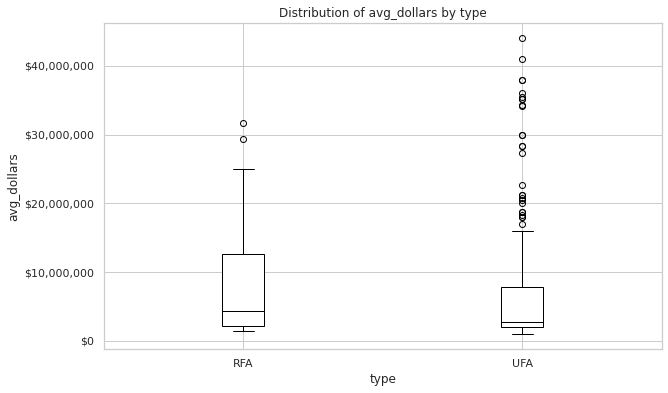

In [125]:
multiboxplot(contracts, 'avg_dollars', 'type', avg_dollars=True)

Another thing to keep in mind about `type` is that there are many more people signing Unrestricted Contracts than Restricted Contracts.

### avg_dollars vs type

Next I will look at whether or not a player resigning with his original team impacts average dollars. In today's NBA, the salary rules are structured so teams are able to offer there own players slighting more money than other teams during free agency. This rule was put into place so teams in smaller market towns, such as Milwaukee or Oklahoma City, would have a better chance of keeping star players who might leave for the New York and Los Angeles of the world if all was equal. This difference is not a lot of money, but if a player is trying to eak out every single penny they can, they can make more money by staying with the same team. Thus, I believe that players who stay with their original team, might make a little bit more money thatn those that change teams.

Taking a look at descritptive statistics split by resigning or not:

In [126]:
describe_by_category(contracts, 'avg_dollars', 'chg_team')

,count,mean,std,min,25%,50%,75%,max
chg_team,,,,,,,,
0,136.00,"7,708,143.88","8,633,831.56","898,310.00","2,231,079.50","4,050,000.00","10,000,000.00","44,066,288.00"
1,219.00,"6,191,445.15","7,333,807.58","1,445,697.00","2,028,594.00","2,641,691.00","7,339,877.00","41,063,925.00"


My prediction of players resigning with their orignal teams making slightly more money appears to be accurate. Let's take a look at the side by side box plots.

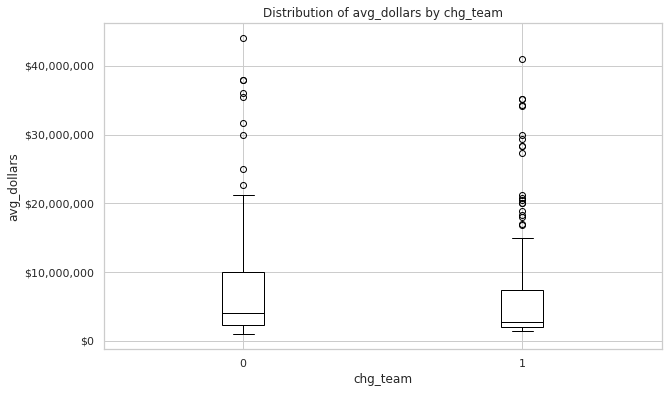

In [127]:
multiboxplot(contracts, 'avg_dollars', 'chg_team', avg_dollars=True)

multiboxplot(contracts, 'avg_dollars', 'chg_team', avg_dollars=True)

Again this is not a huge difference relative to basketball salaries, but a difference does exist.

**Two Variable EDA Thoughts:** When it came to comparing individual features to avg_dollars, outside of points per game, there were not a ton of features that had extremely strong correlations with average dollars on their own. Hopefully, when the features are combined together, a model can be built that accurately predicts how much their contract will be worth.

In baskeball, teams are looking for a variety of players and skills. Everyone wants players that score lots of points. But teams also need bigs who get lots of rebounds and block shots. They also need guards who get lots of assists and make three point shots. Thus, I think that when I get into model building, I will need to build the model that values these different types of players. For example, the model should recognize that a guy who shoots a high percentage, gets a lot of rebounds, and is really tall is likely to earn a lot of money, even if they don't make a lot of threes. Similarly, if a player scores a lot and shoots a high percentage, they will still probably get a large contract even if their rebounds are slow. I will obviously get into this more in model building, but I am thinking that using position, which is usually a way to seperate players into roles or desired skills, to build different interaction terms with the statistical values could be a way to accomplish this.

## Model Building

Now that I have finished ETL and EDA, it's time to move on to model building. Again, the goal will be to build a model that best predicts the average salary of the contracts free agents will sign.

### Mean Model

The simplest model that can be used is a mean model. In this model, we would simply predict each player would get the mean salary.

In [128]:
print('Mean Average Salary:', contracts['avg_dollars'].mean())

Mean Average Salary: 6772490.295774648


In a practical sense, using this model in this context is rather silly. Top tier players would laugh at an offer like this and we would grossly overpaying for a lot of other players.

We can also take a look at the standard deviation of the mean model.

In [129]:
print('Std of Average Salary:', contracts['avg_dollars'].std())

Std of Average Salary: 7879993.542130161


The standard deviation of the avg_dollars variable is almost 8 million dollars! This is an extremely high standard deviation, as it would mean on average, the predicted average salary would be off by 7.8 million dollars. The goal when I build a linear regression model is to lower this standard deviation drastically.

### Linear Regression

I will start by predicting the sign of the coefficients for the different features by predicting how the different features will influence `avg_dollars`. Most of these predictions come directly from EDA.

* **height** - positive: For the most part, I think taller players will make more more than shorter players, with the caveat that the might be a dip in salary when players are on the extreme tall end.
* **weight** - unclear: At the moment, I have no real prediction for how weight will affect the model.
* **age** - positive: For the most part, I think older players will make more money than shorter players, with the caveat that players are likely to earn the most money during there late-middle years.
* **games** - positive: I think that players who play more games will earn more money than those who play less.
* **minutes** - positive: I think that players who play more minutes will earn more money than those who play less.
* **points** - positive: I think that players who score more points will earn more money than those who score less.
* **rebounds** - positive: I think that players who get more rebounds will earn more money than those who get less.
* **assists** - positive: I think that players who get more assists will earn more money than those who get less.
* **steals** - positive: I think that players who get more steals will earn more money than those who get less.
* **blocks** - positive: I think that players who get block more shots will earn more money than those who block less.
* **turnovers** - positive: I think that players who turn the ball over more will earn more money than those who turn the ball over less. While this is counterintuitive, this is the relationship that was discovered in EDA. Again, my hypothesis is that better players have the ball more and having the ball more will lead to more turnovers. (In my opinion, this relationship between turning the ball over and earning more money is a great "Correlation does not equal causation" example.)
* **field goal percentage** - little impact: As I saw in EDA, players with a range of different field goal percentages had a range of different salaries. Thus, I don't think this statistic will have much impact on the model.
* **three point field goals** - positive: I think that players who make more three point shots will make more money than those who make less.
* **three point percentage** - little impact: As I saw in EDA, players with a range of different three point percentage
* **effctive field goal percentage** - little impact: As I saw in EDA, players with a range of different effective field goal percentages had a range of different salaries. Additionally, this is just a weighted version of field goal percentage. Thus, I don't think this statistic will have much impact on the model.
* **free throw percentage** - positive: Albeit slight, I think that players who shoot a higher percentage from the free throw line will make more money than those who shoot worse from the free throw line.
* **type** - I think that players who are signing restricted free agent deals will need to be paid a little more than unrestricted free agents.
* **chg_team** - I think that players who stay with the same team will make more money than those who change teams.
* **length** - I think that players who sign longer contracts will make more money than those who sign shorter contracts.

Before starting to build my first model, I need to create one hot encodings for the position and type variables.

First for `position`

In [130]:
contracts = pd.concat([contracts, pd.get_dummies(contracts['position'])], axis=1)

In [131]:
contracts.head()

,player,year,position,height,weight,age,years_exp,games,min,pts,...,ft_per,type,chg_team,length,avg_dollars,C,PF,PG,SF,SG
0,Klay Thompson,2019,SG,78,215,29.40,7,78,34.00,21.50,...,0.82,UFA,0,5,37980720,0,0,0,0,1
1,Tobias Harris,2019,PF,80,226,26.90,7,82,34.70,20.00,...,0.87,UFA,0,5,36000000,0,1,0,0,0
2,Khris Middleton,2019,SF,79,222,27.80,6,77,31.10,18.30,...,0.84,UFA,0,5,35500000,0,0,0,1,0
3,Kevin Durant,2019,SF,82,240,30.80,11,78,34.60,26.00,...,0.89,UFA,1,4,41063925,0,0,0,1,0
4,Jimmy Butler,2019,SF,79,230,29.80,7,65,33.60,18.70,...,0.85,UFA,1,4,35197650,0,0,0,1,0


And for `type`

In [132]:
contracts = pd.concat([contracts, pd.get_dummies(contracts['type'])], axis=1) 

In [133]:
contracts.head()

,player,year,position,height,weight,age,years_exp,games,min,pts,...,chg_team,length,avg_dollars,C,PF,PG,SF,SG,RFA,UFA
0,Klay Thompson,2019,SG,78,215,29.40,7,78,34.00,21.50,...,0,5,37980720,0,0,0,0,1,0,1
1,Tobias Harris,2019,PF,80,226,26.90,7,82,34.70,20.00,...,0,5,36000000,0,1,0,0,0,0,1
2,Khris Middleton,2019,SF,79,222,27.80,6,77,31.10,18.30,...,0,5,35500000,0,0,0,1,0,0,1
3,Kevin Durant,2019,SF,82,240,30.80,11,78,34.60,26.00,...,1,4,41063925,0,0,0,1,0,0,1
4,Jimmy Butler,2019,SF,79,230,29.80,7,65,33.60,18.70,...,1,4,35197650,0,0,0,1,0,0,1


As the value for change team is already 0 for resigning with the same team and 1 for changing teams, there is no need to make one hot encodings for this variable.

As our target variable is `avg_dollars`, I will go ahead and set the y variable to `avg_dollars`

In [134]:
y = 'avg_dollars'

I will start by creating an initial 'all variables' model.

In [135]:
X = ['PF', 'PG', 'C', 'SG', 'height', 'weight', 'age', 'games', 'min', 'pts',
     'rbs', 'ast', 'stl', 'blk', 'tov', 'fg_per', 'three_fg', 'three_per', 'efg_per',
     'ft_per', 'RFA', 'chg_team', 'length']

In [136]:
result = bootstrap_linear_reg(contracts, X, y)
output_bootstrap_results(result)

,Labels,Values,95% BCI Low,95% BCI High
0,intercept,"-30,137,144.70","-52,949,969.32","-13,693,975.45"
1,PF,"-743,517.21","-2,485,356.92","1,008,434.60"
2,PG,"-1,624,146.92","-3,426,482.85","584,923.97"
3,C,"-1,381,603.17","-3,579,506.46","962,122.96"
4,SG,"-595,019.91","-2,234,567.84","1,147,101.89"
5,height,"300,878.36","75,240.19","589,985.59"
6,weight,"-1,059.14","-36,980.41","28,420.58"
7,age,"177,891.14","37,322.90","291,578.51"
8,games,"18,156.57","-7,705.45","45,009.62"
9,min,"-416,682.67","-625,204.79","-266,397.81"


There is a lot going on in this initial model. The value for $R^2$ is 0.79, which is pretty good to start. The $\bar{R^2}$, which takes into account the number of features in the model, is also at a good starting value of 0.77. The $\sigma$ is 3.7 million dollars, which is almost half of the standard devation of avg_dollars originally.

I hesitate to look to much at the coefficients and residuals of this model simplying because there are so many variables. It is likely that some of these variables are not super impactful in predicting the average salary. Thus, these factors are likely influencing the coefficient values of the other features.

Thus, I will try rerunning the model using only the features that I think have a more significant impact on the model.

In [137]:
X = ['height', 'age', 'min', 'pts',
     'rbs', 'ast', 'stl', 'blk', 'tov', 'three_fg',
     'RFA', 'chg_team', 'length']

In [138]:
result = bootstrap_linear_reg(contracts, X, y)
output_bootstrap_results(result)

,Labels,Values,95% BCI Low,95% BCI High
0,intercept,"-31,054,689.69","-46,312,788.81","-19,556,453.57"
1,height,"278,859.28","136,297.85","448,536.12"
2,age,"151,148.06","30,462.02","250,043.71"
3,min,"-342,145.81","-538,349.25","-200,694.30"
4,pts,"1,093,174.05","827,041.93","1,364,993.48"
5,rbs,"78,074.51","-221,986.90","533,737.46"
6,ast,"1,142,177.79","581,672.38","1,667,162.96"
7,stl,"1,880,840.35","-48,477.99","4,229,898.74"
8,blk,"-1,184,589.92","-3,153,814.12","384,058.04"
9,tov,"-1,676,684.10","-3,290,634.59","244,606.39"


In this second model, I reduced the number of features from 23 to 13 with very little impact on the value of $R^2$, $\bar{R^2}$, and $\sigma$. I removed the four shooting percentage features, the position features, weight, and games. It is here I will begin looking at coefficients and residuals.

Many of the coefficients have the same sign that I predicted before starting to build the model. Minutes, blocks, and steals all have a negative coefficients, which very much surprises me. Also, being a Restricted Free Agent decreases avg_dollars and changing teams increases salary, both of which surprise me.

The next thing that I want to do is look at the residual plots. This will help me to see if there are any trends in the errors that the model is making.

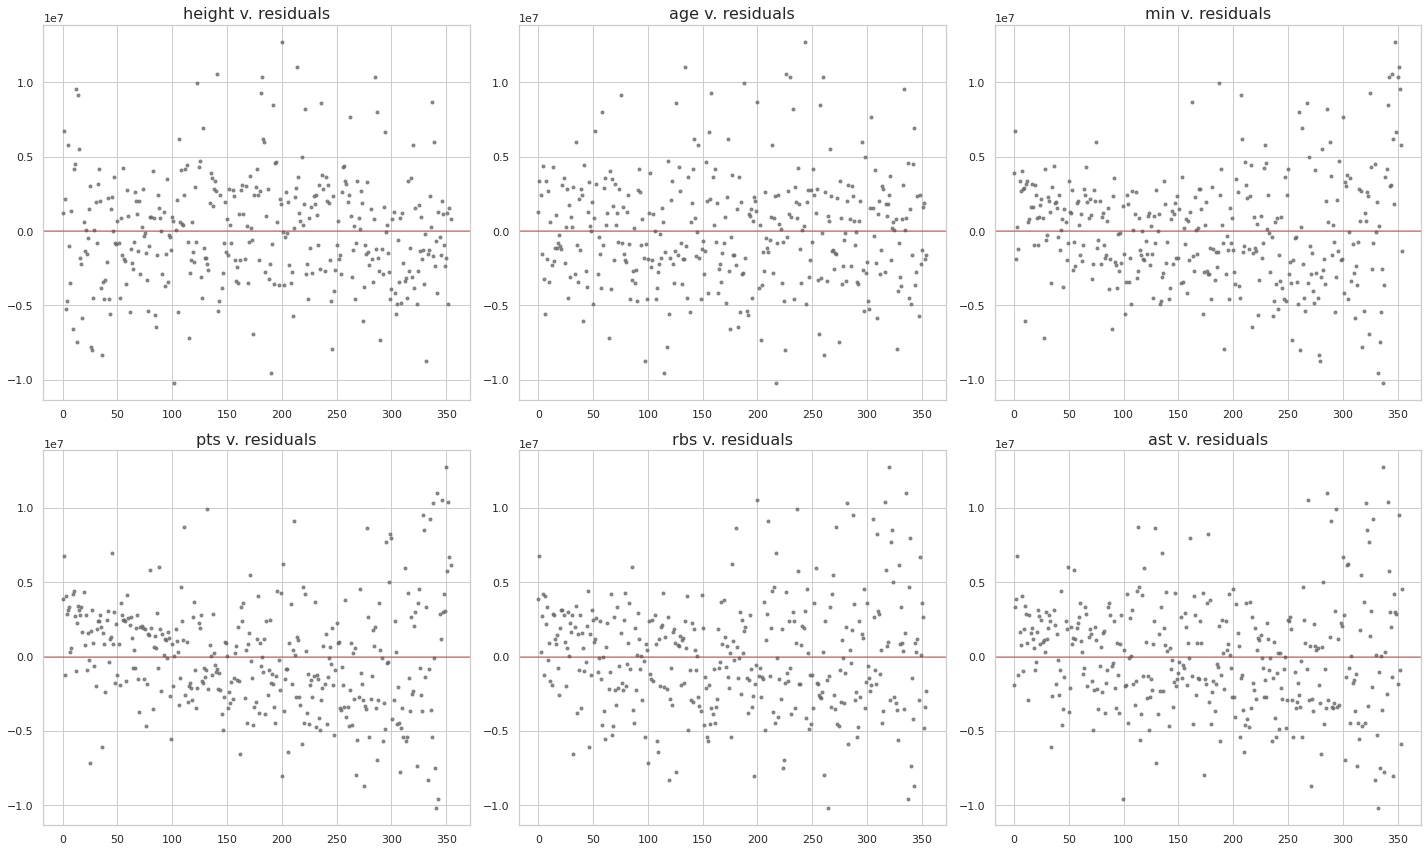

In [139]:
plot_residuals(contracts, ['height', 'age', 'min', 'pts', 'rbs', 'ast'], result, (2, 3), size=(20,12))

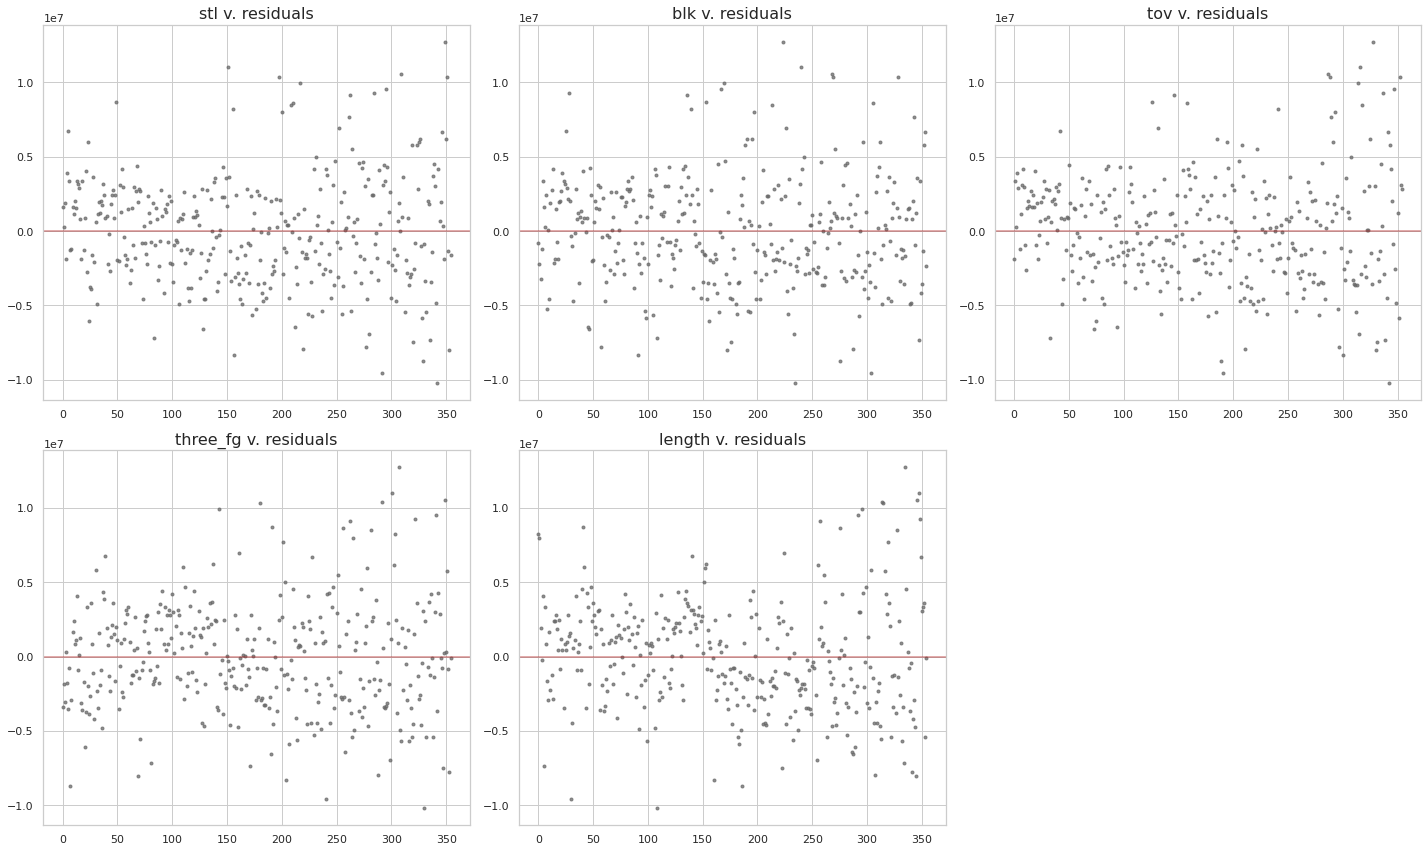

In [140]:
plot_residuals(contracts, ['stl', 'blk', 'tov', 'three_fg', 'length'], result, (2, 3), size=(20,12))

One thing that stands out from a bunch of these residual plots is that the errors are much larger for the higher values for the different variables. This is something that I want to keep an eye on and want to correct.

In EDA, I saw a curved relationships between `pts` and `avg_dollars` and between `min` and `avg_dollars`. Also, the residual plots for these features also have an upward curve. Thus, I want to try running the model with these features squared.

In [141]:
contracts['pts_sq'] = contracts['pts']**2
contracts['min_sq'] = contracts['min']**2

In [142]:
X = ['height', 'age', 'min_sq', 'pts_sq',
     'rbs', 'ast', 'stl', 'blk', 'tov', 'three_fg',
     'RFA', 'chg_team', 'length']

In [143]:
result = bootstrap_linear_reg(contracts, X, y)
output_bootstrap_results(result)

,Labels,Values,95% BCI Low,95% BCI High
0,intercept,"-27,289,806.82","-40,344,988.25","-10,811,220.59"
1,height,"254,464.19","39,926.07","403,749.89"
2,age,"146,710.10","43,118.54","250,260.94"
3,min_sq,"-1,641.40","-4,957.31","1,895.36"
4,pts_sq,"42,457.11","34,660.44","48,604.23"
5,rbs,"23,835.27","-446,990.14","509,775.87"
6,ast,"979,313.80","358,533.53","1,420,200.62"
7,stl,"854,531.58","-580,466.48","2,443,904.20"
8,blk,"-1,315,837.91","-2,741,025.33",582.53
9,tov,"-2,072,249.81","-3,735,217.10","-523,753.52"


This adjustment increased the values of $R^2$, $\bar{R^2}$, and $\sigma$. Let's take a look at the residual plot again.

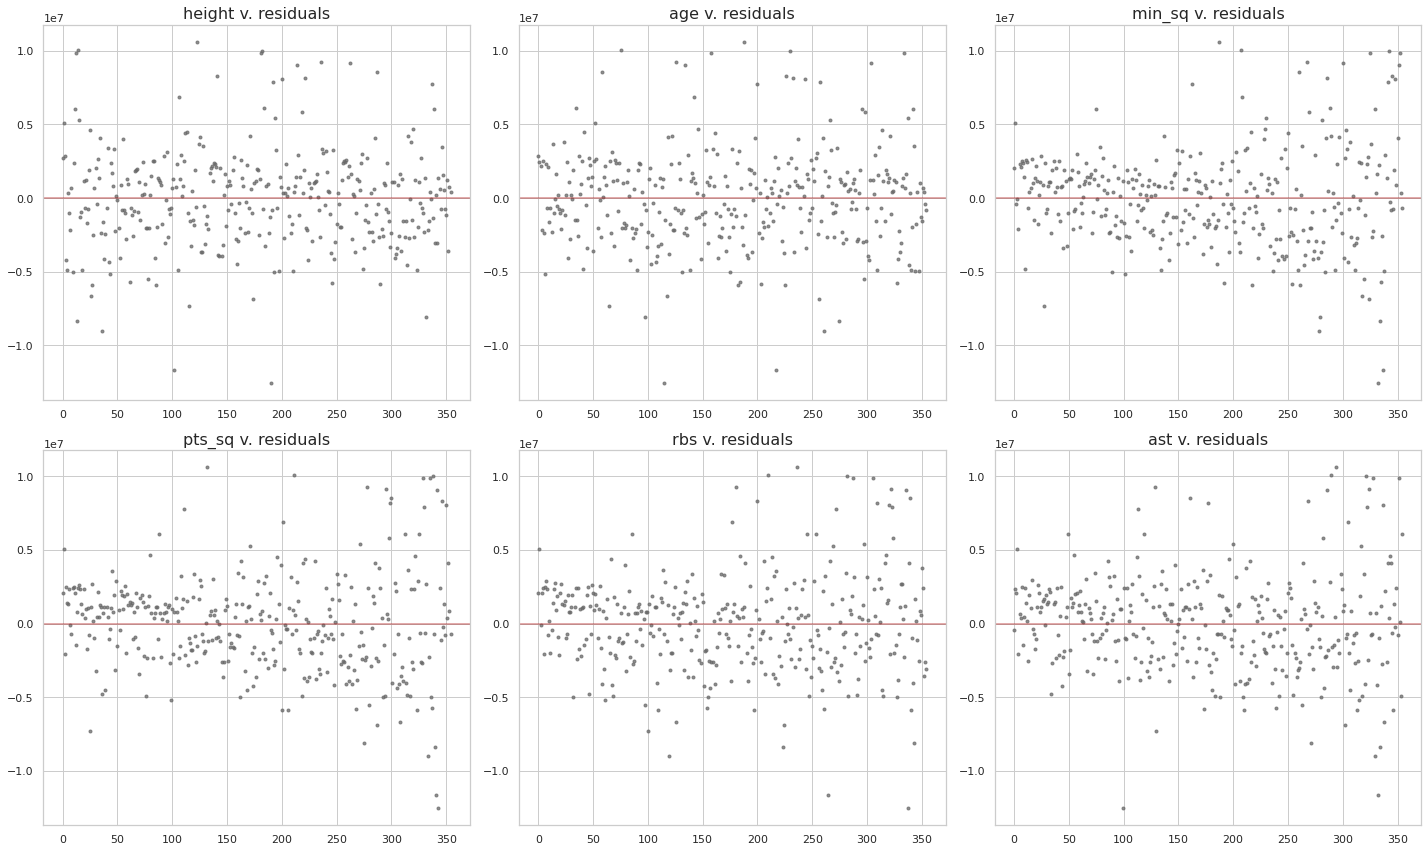

In [144]:
plot_residuals(contracts, ['height', 'age', 'min_sq', 'pts_sq', 'rbs', 'ast'], result, (2, 3), size=(20,12))

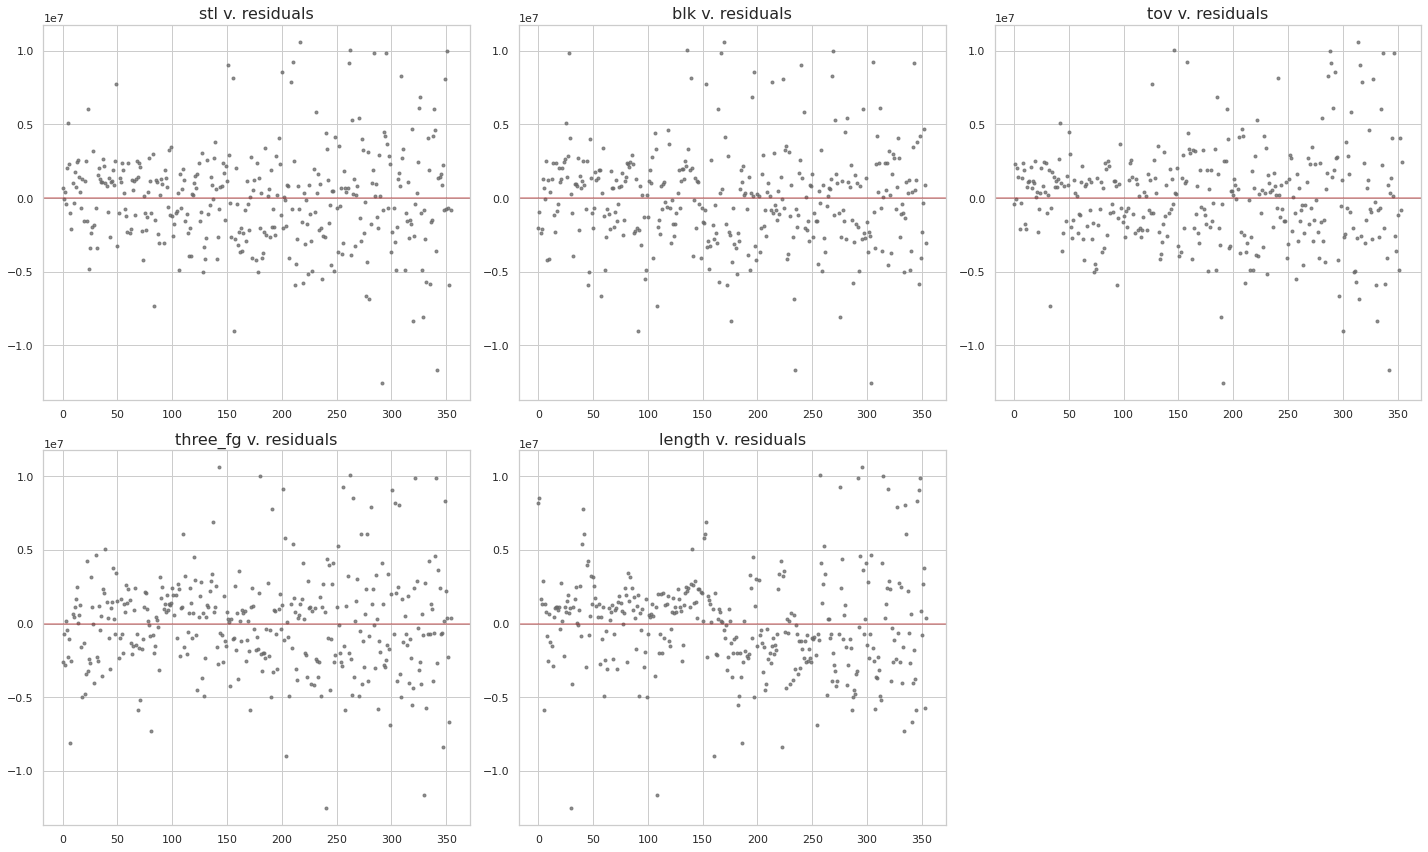

In [145]:
plot_residuals(contracts, ['stl', 'blk', 'tov', 'three_fg', 'length'], result, (2, 3), size=(20,12))

There seems to be a little bit less curve than there was previously in the min and pts errors.

The much larger errors on the higher order features is still something that I want to try and address next. Because the values of `avg_dollars` are so high, I want to try and take the log of average dollars and apply the model to these values.

In [146]:
contracts['log_avg_dollars'] = contracts['avg_dollars'].apply(lambda x: np.log(float(x)))

In [147]:
y = 'log_avg_dollars'
X = ['height', 'age', 'min_sq', 'pts_sq',
     'rbs', 'ast', 'stl', 'blk', 'tov', 'three_fg',
     'RFA', 'chg_team', 'length']

In [148]:
result = bootstrap_linear_reg(contracts, X, y)
output_bootstrap_results(result)

,Labels,Values,95% BCI Low,95% BCI High
0,intercept,11.27,9.65,13.34
1,height,0.02,-0.01,0.04
2,age,0.03,0.02,0.04
3,min_sq,0.00,-0.00,0.00
4,pts_sq,0.00,0.00,0.00
5,rbs,0.04,-0.01,0.09
6,ast,0.04,-0.02,0.11
7,stl,0.17,-0.03,0.34
8,blk,-0.10,-0.26,0.09
9,tov,-0.05,-0.30,0.10


I was not fully sure what to expect from this model and I knew it would make the coefficients and results less interpretable, but I wanted to see if the effect this would have on $R^2$ and $\bar{R^2}$. Since these values are lower, there is no reason to use `log_avg_dollars` again.

In [149]:
y = 'avg_dollars'

**Interaction Terms**

One thing that I discussed at the end of the EDA section was that I want to incorporate some interaction terms into the model that related to positions. In basketball, players who play guard or small forward are often expected to get more assists, steals, and shoot more three point shots than power forwards and centers. Similarly, power fowards and centers are usually expected to get more rebounds, block more shots, and have a higher field goal percentage than guards and small forwards. Thus, I want to add some interaction terms into the model to see if this has any effect on the model.

To do so, I will start by making a binary feature `big`. If the player is a guard or small forward, then their value for big will be 0. If they are a power forward or center, their value will be one.

In [150]:
contracts['big'] = [1 if x[0] + x[1] != 0 else 0 for x in zip(contracts['PF'], contracts['C'])]

I will take the value counts just to see the distribution of "bigs" and "littles" in the data set.

In [151]:
pd.DataFrame(contracts['big'].value_counts())

,big
0,210
1,145


It looks like there are more "littles" in the data set, which makes sense because 3 positions make up "littles" while only 2 make up "bigs".

Now, I will add the interaction terms to the data set.

In [152]:
contracts['big:rbs'] = contracts['big'] * contracts['rbs']
contracts['big:blk'] = contracts['big'] * contracts['blk']
contracts['big:efg_per'] = contracts['big'] * contracts['efg_per']

contracts['big:ast'] = contracts['big'] * contracts['ast']
contracts['big:stl'] = contracts['big'] * contracts['stl']
contracts['big:three_fg'] = contracts['big'] * contracts['three_fg']

In [153]:
X = ['height', 'age', 'min_sq', 'pts_sq',
     'rbs', 'ast', 'stl', 'blk', 'tov', 'three_fg',
     'RFA', 'chg_team', 'length',
     'big:rbs', 'big:blk', 'big:efg_per',
     'big:ast', 'big:stl', 'big:three_fg']

In [154]:
result = bootstrap_linear_reg(contracts, X, y)
output_bootstrap_results(result)

,Labels,Values,95% BCI Low,95% BCI High
0,intercept,"-25,598,989.51","-44,629,275.48","-7,067,582.13"
1,height,"232,262.39","8,812.25","451,051.51"
2,age,"141,138.74","17,726.69","256,981.13"
3,min_sq,"-1,708.14","-4,926.60","2,901.39"
4,pts_sq,"42,602.12","29,605.60","51,118.77"
5,rbs,"92,540.87","-1,022,485.58","775,963.52"
6,ast,"931,931.63","462,347.62","1,489,074.41"
7,stl,"1,192,827.88","-948,264.24","3,478,418.82"
8,blk,"-1,202,622.99","-5,054,508.07","2,970,039.38"
9,tov,"-2,041,243.36","-4,592,605.20","-473,920.16"


The value for $\sigma$ actually increased slightly. However, while the values for $R^2$ and $\bar{R^2}$ did not change, the both the low and upper bounds of the Bayesian Interval actually increased. Thus, I will leave the interaction terms in the model for now. 

Let's again take a look at the residual plots.

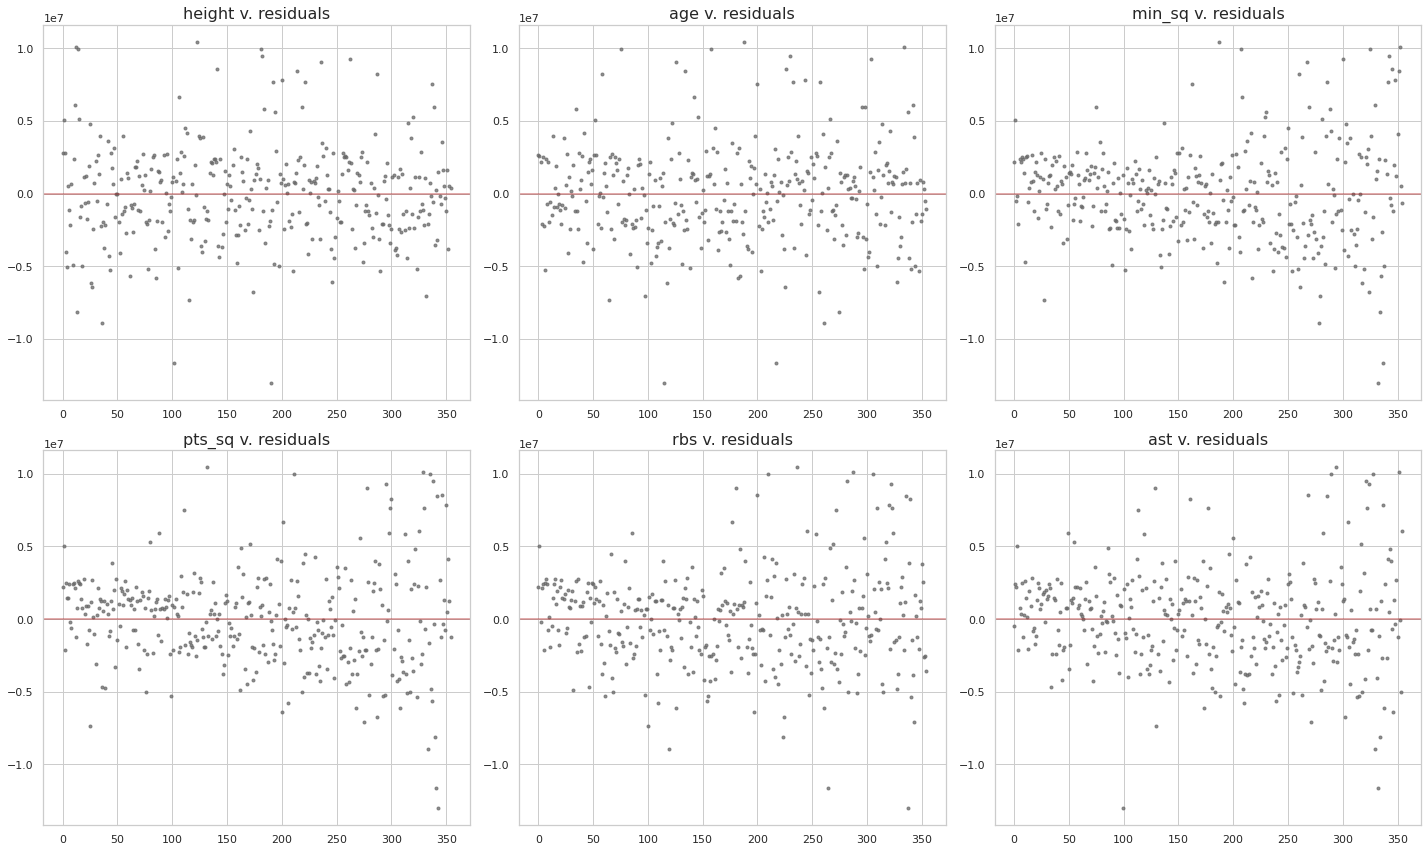

In [155]:
plot_residuals(contracts, ['height', 'age', 'min_sq', 'pts_sq', 'rbs', 'ast'], result, (2, 3), size=(20,12))

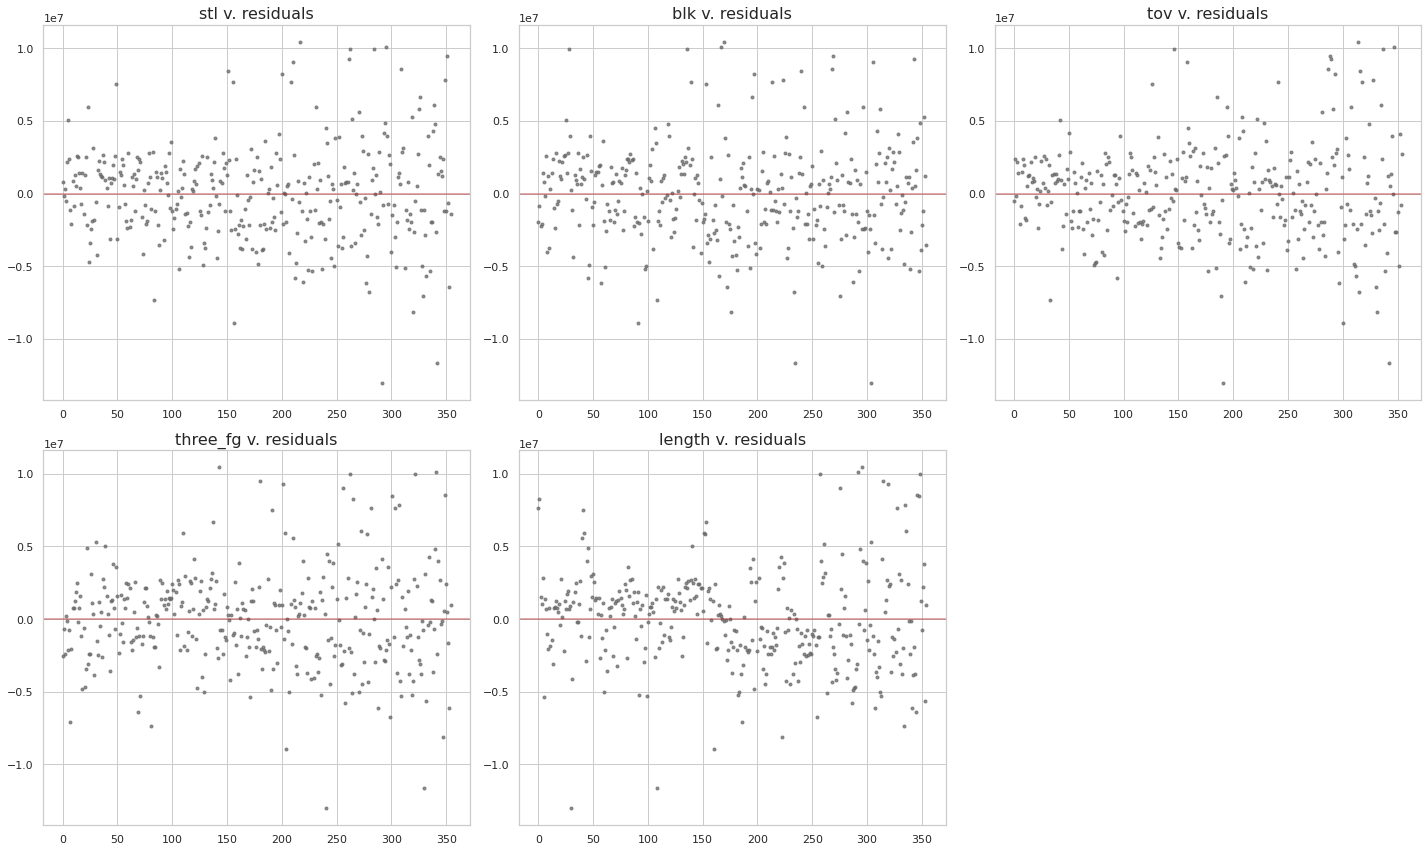

In [156]:
plot_residuals(contracts, ['stl', 'blk', 'tov', 'three_fg', 'length'], result, (2, 3), size=(20,12))

The residual plots still look much the same. I am still seeing the greater errors at the high end of the features.

Next, I want to try using height in the interaction term instead of position. As I noted early, position is often based upon height, and using the player's actual height will give us more control about which players are in each group.

To do this, I will make a short, medium and tall group. The short group will include players 76 inches and shorter (6'4 and shorter). The medium group will include players between 77 inches and 81 inches (6'5 to 6'9). The tall group will have players that are 82 inches and taller (6'10 and above).

In [157]:
contracts['short'] = [1 if x<=76 else 0 for x in contracts['height']]
contracts['tall'] = [1 if x>=82 else 0 for x in contracts['height']]
contracts['medium'] = [1 if x[0]+x[1] != 1 else 0 for x in zip(contracts['short'], contracts['tall'])]

Now I will check how many players are in each of the short, medium, and tall groups.

In [158]:
print('Number in the short group:', contracts['short'].value_counts()[1])
print('Number in the medium group:', contracts['medium'].value_counts()[1])
print('Number in the tall group:', contracts['tall'].value_counts()[1])

Number in the short group: 104
Number in the medium group: 181
Number in the tall group: 70


I will now create the new interaction features. I will only make interaction terms using the short and the tall groups because I only need to include n-1 binary features for this and the medium group has the most players in it.

In [159]:
contracts['short:rbs'] = contracts['short'] * contracts['rbs']
contracts['short:blk'] = contracts['short'] * contracts['blk']
contracts['short:efg_per'] = contracts['short'] * contracts['efg_per']
contracts['short:ast'] = contracts['short'] * contracts['ast']
contracts['short:stl'] = contracts['short'] * contracts['stl']
contracts['short:three_fg'] = contracts['short'] * contracts['three_fg']

contracts['tall:rbs'] = contracts['tall'] * contracts['rbs']
contracts['tall:blk'] = contracts['tall'] * contracts['blk']
contracts['tall:efg_per'] = contracts['tall'] * contracts['efg_per']
contracts['tall:ast'] = contracts['tall'] * contracts['ast']
contracts['tall:stl'] = contracts['tall'] * contracts['stl']
contracts['tall:three_fg'] = contracts['tall'] * contracts['three_fg']

I will now run the model using these new interaction terms instead of the position interaction terms.

In [160]:
X = ['height', 'age', 'min_sq', 'pts_sq',
     'rbs', 'ast', 'stl', 'blk', 'tov', 'three_fg',
     'RFA', 'chg_team', 'length',
     'short:rbs', 'short:blk', 'short:efg_per',
     'short:ast', 'short:stl', 'short:three_fg',
     'tall:rbs', 'tall:blk', 'tall:efg_per',
     'tall:ast', 'tall:stl', 'tall:three_fg']
result = bootstrap_linear_reg(contracts, X, y)
output_bootstrap_results(result)

,Labels,Values,95% BCI Low,95% BCI High
0,intercept,"-13,605,592.62","-38,534,956.66","9,840,604.51"
1,height,"72,754.50","-251,633.00","381,914.51"
2,age,"146,281.14","19,614.81","239,100.10"
3,min_sq,"-3,650.54","-6,555.36",231.15
4,pts_sq,"42,634.84","31,929.14","51,802.54"
5,rbs,"125,350.18","-480,316.38","494,084.01"
6,ast,"1,821,656.43","800,631.35","3,044,664.78"
7,stl,"858,624.88","-1,951,984.87","3,428,158.59"
8,blk,"-1,261,778.30","-4,292,679.68","2,132,082.22"
9,tov,"-1,815,892.10","-3,359,397.67","-190,669.45"


Using these new interaction terms slightly increased the values for $R^2$ and $\bar{R^2}$ and slightly decreased the value for $\sigma$. This means this is probably a better model than the model with the position-based interaction terms. Having a look at the residual plots again.

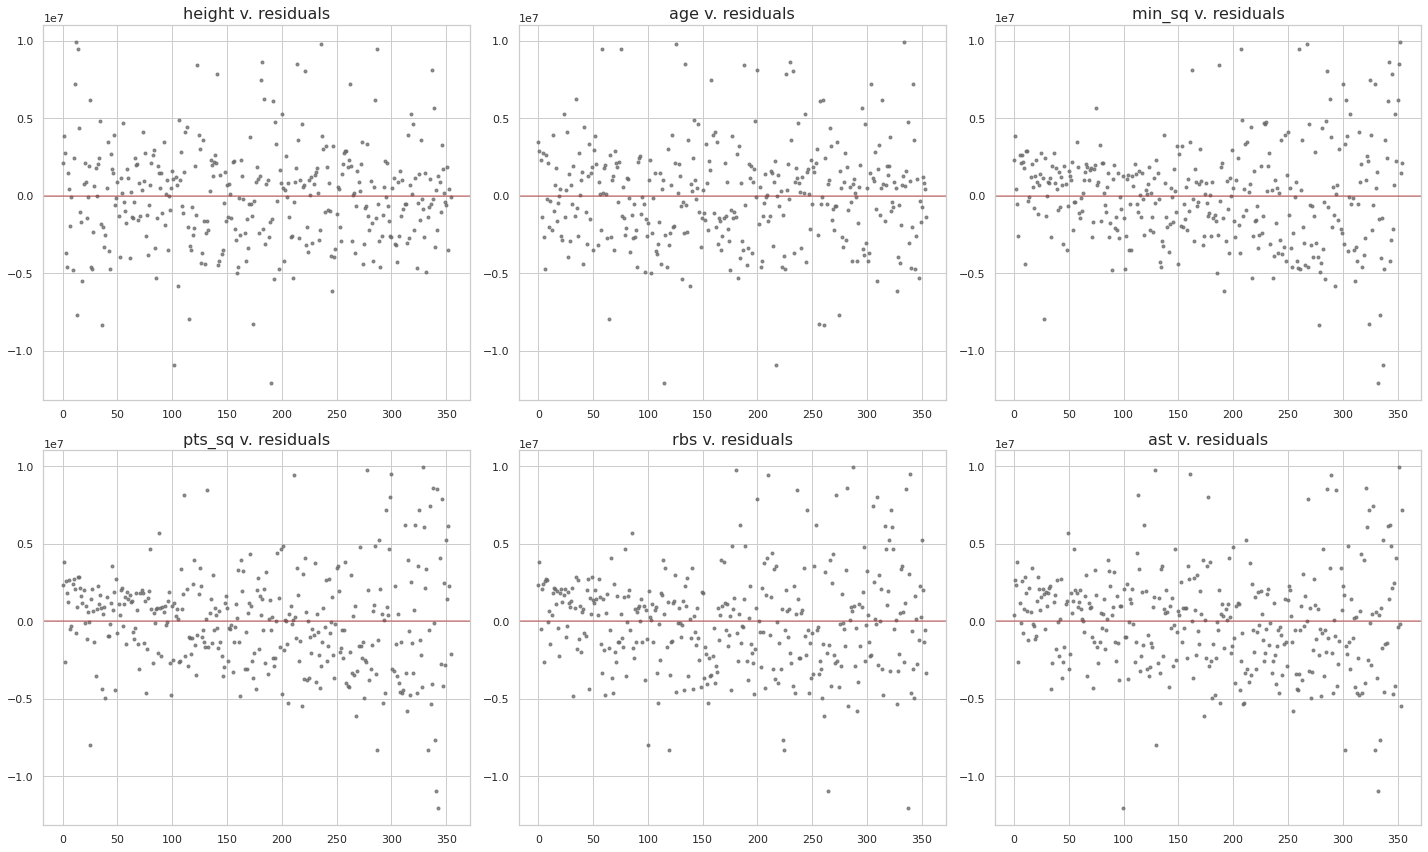

In [161]:
plot_residuals(contracts, ['height', 'age', 'min_sq', 'pts_sq', 'rbs', 'ast'], result, (2, 3), size=(20,12))

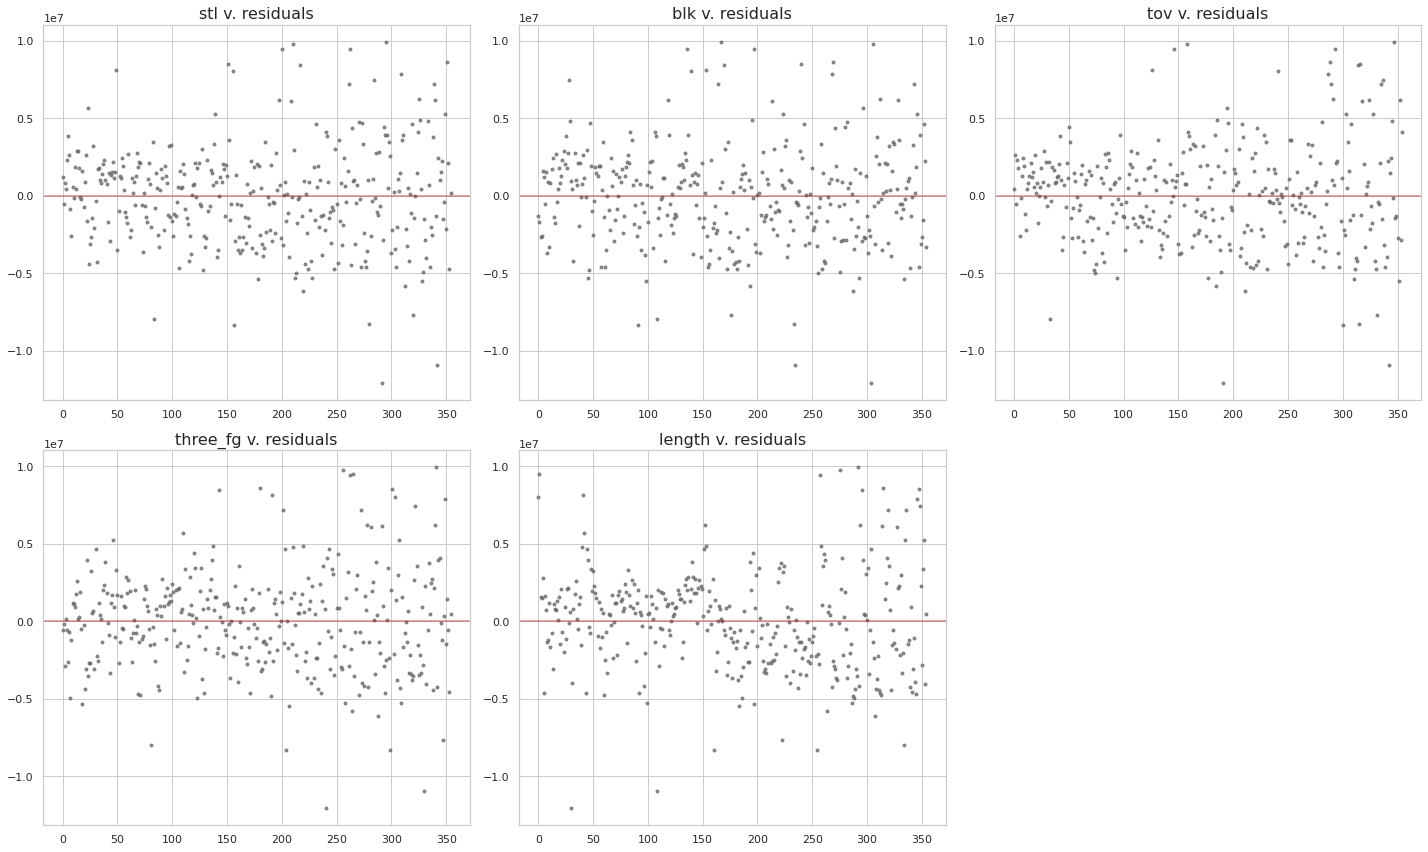

In [162]:
plot_residuals(contracts, ['stl', 'blk', 'tov', 'three_fg', 'length'], result, (2, 3), size=(20,12))

While there still appears to be a greater likelihood that large errors are made on the high end of the statistical values, it looks like this might have improved with this round of residual plots. This could be because players getting the most rebounds and blocks are tall and players getting the most assists and steals are shorter and the interaction terms have helped this.

At this point, I have not included an interaction term for points because teams want players that score no matter how tall they are. But I would like to experiment with what would have if I included an interaction term with points.

In [163]:
contracts['short:pts'] = contracts['short'] * contracts['pts']
contracts['tall:pts'] = contracts['tall'] * contracts['pts']

Running the model with this interaction term.

In [164]:
X = ['height', 'age', 'min_sq', 'pts_sq',
     'rbs', 'ast', 'stl', 'blk', 'tov', 'three_fg',
     'RFA', 'chg_team', 'length',
     'short:pts', 'short:rbs', 'short:blk', 'short:efg_per',
     'short:ast', 'short:stl', 'short:three_fg',
     'tall:pts', 'tall:rbs', 'tall:blk', 'tall:efg_per',
     'tall:ast', 'tall:stl', 'tall:three_fg']
result = bootstrap_linear_reg(contracts, X, y)
output_bootstrap_results(result)

,Labels,Values,95% BCI Low,95% BCI High
0,intercept,"-15,160,383.39","-39,891,716.91","3,251,316.98"
1,height,"96,136.57","-134,364.35","410,255.72"
2,age,"151,641.79","33,346.42","247,080.96"
3,min_sq,"-3,206.44","-6,325.05",347.66
4,pts_sq,"46,245.42","34,487.47","58,245.72"
5,rbs,"-20,555.26","-725,666.76","491,470.56"
6,ast,"1,546,090.61","483,225.56","2,849,722.53"
7,stl,"778,447.43","-1,636,238.21","3,149,295.29"
8,blk,"-1,254,283.37","-4,357,423.28","1,705,812.13"
9,tov,"-1,479,700.25","-3,212,620.83","-24,477.46"


This model produces the best values of $R^2$, $\bar{R^2}$, and $\sigma$ yet. As switching from `pts` to `pts_sq` helped the model, what if I switched the interaction terms to use pts_sq?

In [165]:
contracts['short:pts_sq'] = contracts['short'] * contracts['pts_sq']
contracts['tall:pts_sq'] = contracts['tall'] * contracts['pts_sq']

Running the model with this interaction term.

In [166]:
X = ['height', 'age', 'min_sq', 'pts_sq',
     'rbs', 'ast', 'stl', 'blk', 'tov', 'three_fg',
     'RFA', 'chg_team', 'length',
     'short:pts_sq', 'short:rbs', 'short:blk', 'short:efg_per',
     'short:ast', 'short:stl', 'short:three_fg',
     'tall:pts_sq', 'tall:rbs', 'tall:blk', 'tall:efg_per',
     'tall:ast', 'tall:stl', 'tall:three_fg']
result = bootstrap_linear_reg(contracts, X, y)
output_bootstrap_results(result)

,Labels,Values,95% BCI Low,95% BCI High
0,intercept,"-15,956,148.19","-43,097,360.31","1,963,886.78"
1,height,"103,360.12","-105,980.91","438,373.36"
2,age,"148,123.27","34,766.17","233,020.85"
3,min_sq,"-3,855.14","-7,056.26",982.66
4,pts_sq,"43,973.04","30,471.71","56,818.62"
5,rbs,"95,531.01","-488,430.81","491,140.61"
6,ast,"1,777,340.58","757,961.56","3,207,141.59"
7,stl,"923,557.44","-1,611,017.79","3,418,474.29"
8,blk,"-1,278,018.04","-4,119,893.28","2,204,067.88"
9,tov,"-1,814,725.41","-3,444,022.91","-148,438.78"


While only slightly, this model does not perform as well. I will revert back to using the interaction terms with pts instead of pts_sq.

Switching from `min` and `pts` to `min_sq` and `pts_sq` really seemed to help the model. For experiment purposes, I want to try squaring the other statistical features to see if this will improve the model.

First, creating the new squared features:

In [167]:
contracts['rbs_sq'] = contracts['rbs']**2
contracts['ast_sq'] = contracts['ast']**2
contracts['stl_sq'] = contracts['stl']**2
contracts['blk_sq'] = contracts['blk']**2
contracts['tov_sq'] = contracts['tov']**2
contracts['three_fg_sq'] = contracts['three_fg']**2

Running the model with these features:

In [168]:
X = ['height', 'age', 'min_sq', 'pts_sq',
     'rbs_sq', 'ast_sq', 'stl_sq', 'blk_sq', 'tov_sq', 'three_fg_sq',
     'RFA', 'chg_team', 'length',
     'short:pts', 'short:rbs', 'short:blk', 'short:efg_per',
     'short:ast', 'short:stl', 'short:three_fg',
     'tall:pts', 'tall:rbs', 'tall:blk', 'tall:efg_per',
     'tall:ast', 'tall:stl', 'tall:three_fg']
result = bootstrap_linear_reg(contracts, X, y)
output_bootstrap_results(result)

,Labels,Values,95% BCI Low,95% BCI High
0,intercept,"-9,031,205.86","-29,722,394.85","9,738,681.33"
1,height,"25,034.79","-232,255.79","288,943.63"
2,age,"135,944.71","35,097.64","228,447.91"
3,min_sq,"-3,016.93","-5,772.19",-75.35
4,pts_sq,"43,455.44","28,423.06","55,961.30"
5,rbs_sq,"3,629.18","-41,311.39","59,773.46"
6,ast_sq,"253,684.79","143,387.53","434,994.97"
7,stl_sq,"765,049.02","-1,199,399.87","2,001,943.51"
8,blk_sq,"-231,607.43","-1,908,048.28","1,194,270.99"
9,tov_sq,"-413,319.31","-1,174,815.67","334,883.86"


This increased the value of $R^2$ and slightly decreased the value for $\sigma$. However, the reason I switched to `min_sq` and `pts_sq` originally was due to the shape of the residual plots for `min` and `pts`. As tried these squared features to see what the results would be, I am very interested to see if and how this affected the residual plots before being sure this is the right adjustment to make.

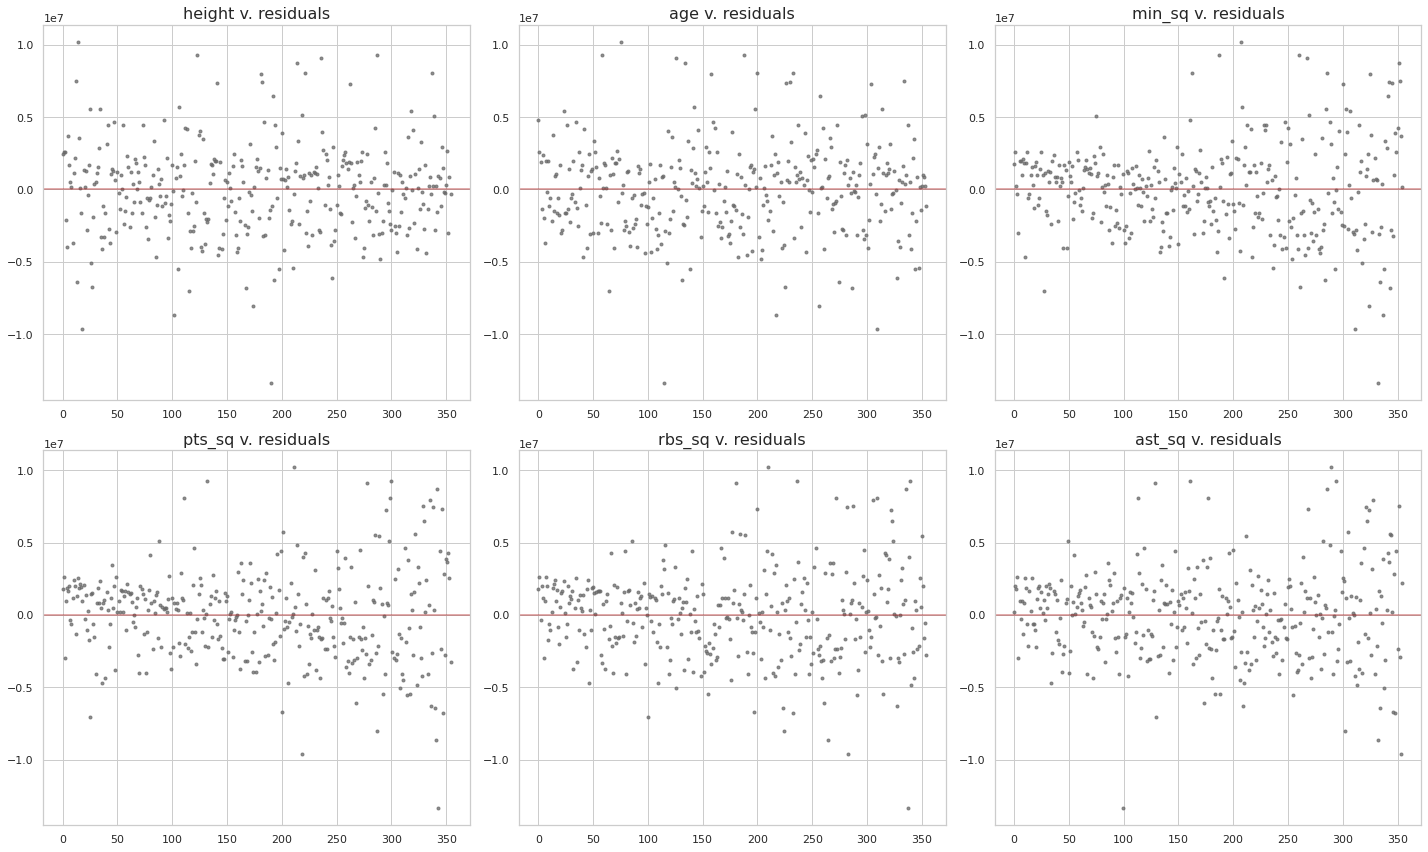

In [169]:
plot_residuals(contracts, ['height', 'age', 'min_sq', 'pts_sq', 'rbs_sq', 'ast_sq'], result, (2, 3), size=(20,12))

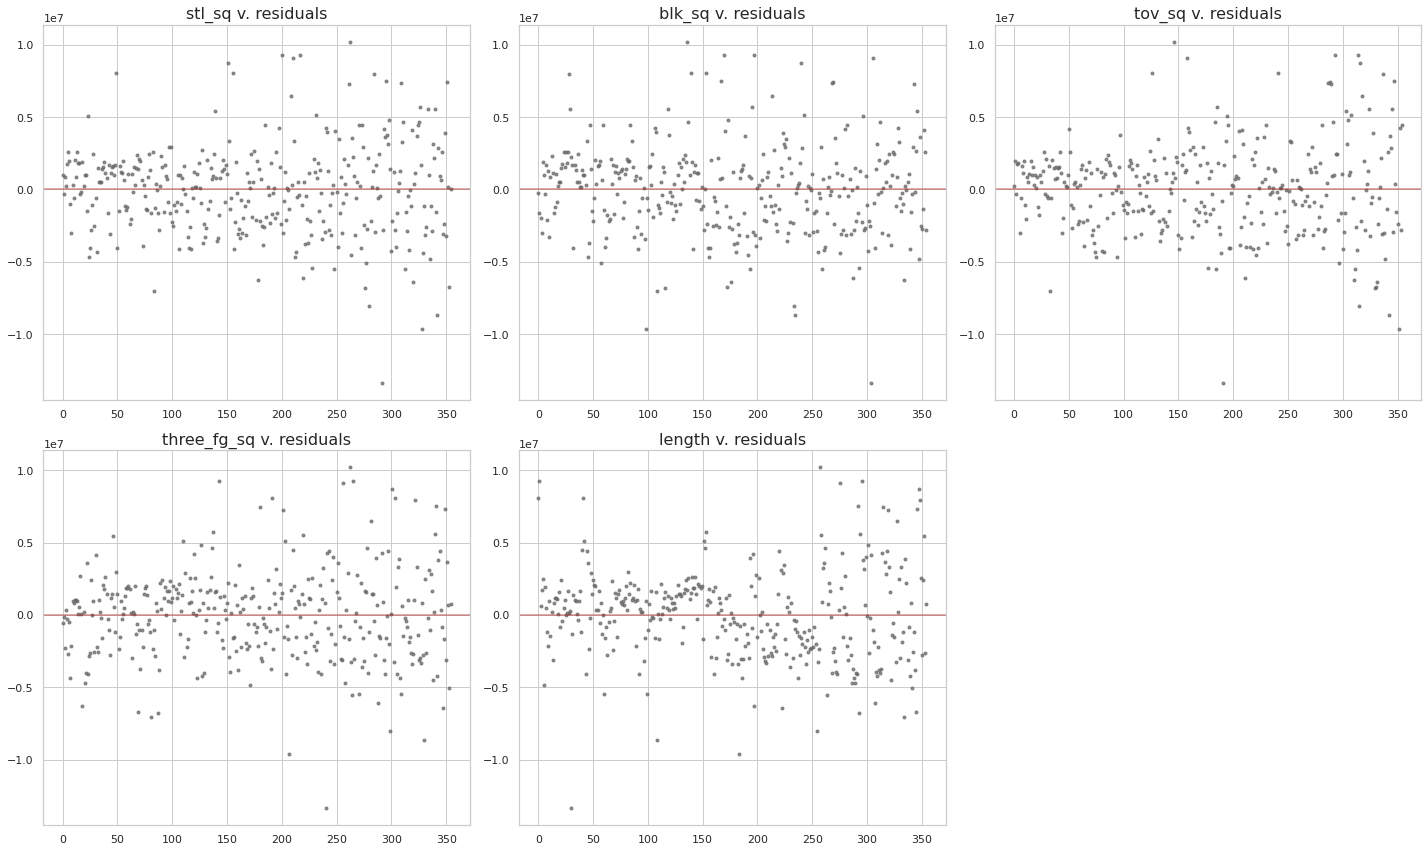

In [170]:
plot_residuals(contracts, ['stl_sq', 'blk_sq', 'tov_sq', 'three_fg_sq', 'length'], result, (2, 3), size=(20,12))

These residual plots look very similar to the model using the regular statistic features, so I think using these squared statistics is a good avenue to take.

I want to dive a little deeper into the `length` statistic. Length is a statistic that I passed over in EDA when comparing the different features to `avg_dollars` because I didn't think it would be very influential. However, as I think about it now, NBA contracts often fall into three categories: minimum contracts, medium contracts, and high contracts. Minimum contracts are for the lowest amount the team can offer the player and are used by teams to fill out their roster. These contracts are often for one year so teams can retain roster flexibility. High contracts are given to the best players. These players often want to lock in these high salaries for a longer time and thus, are often for 4 or 5 years. Medium contracts are for players who are definitely worth more than the minimum, but not quite worth a high contract. These contracts are often for two or three years, so the player can lock in some security but also allow himself to potentially sign a bigger contract in a few years if their play warrants it.

Because of this, I want to experiment with the idea of looking at `length` as a categorical variable. If different length contracts are correlated to different average salary ranges, this might be very beneficial to the model. To start, I want to plot side by side box plots of `length` and `avg_dollars` to see if this might be the case.

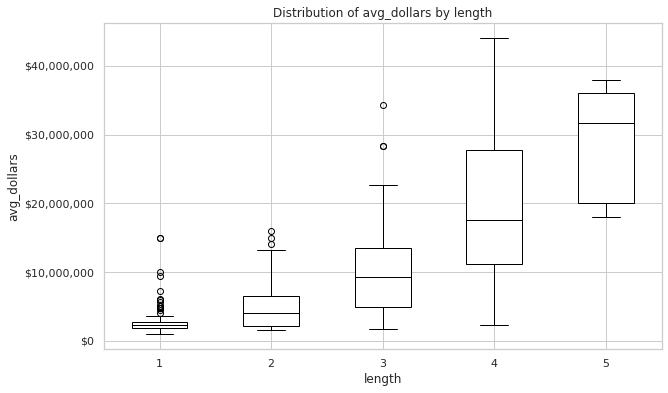

In [171]:
multiboxplot(contracts, 'avg_dollars', 'length', avg_dollars=True)

As a reminder from single variable EDA, it is important to remember that there are much less examples of 5 year contracts than the other contracts. However, based on the box plots, it might be beneficial for the model to know if a contract is 1 year, 2 or 3 years, or 4 or 5 years. The 1 year contracts are typically very, very low, which validates the claim that these are often minimum deals. The 4 and 5 year deals are often the big money deals, so this would also be helpful for the model.

Thus, I will try creating these features and see what the results are on the model.

In [172]:
contracts['one_yr'] = [1 if x==1 else 0 for x in contracts['length']]
contracts['four_five_yr'] = [1 if x>=4 else 0 for x in contracts['length']]
contracts['two_three_yr'] = [1 if x[0]+x[1] != 1 else 0 for x in zip(contracts['one_yr'], contracts['four_five_yr'])]

Checking the numbers in each contract length group:

In [173]:
print('1 year contracts:', contracts['one_yr'].value_counts()[1])
print('2 and 3 year contracts:', contracts['four_five_yr'].value_counts()[1])
print('4 and 5 year contracts:', contracts['two_three_yr'].value_counts()[1])

1 year contracts: 151
2 and 3 year contracts: 41
4 and 5 year contracts: 163


Now, I will insert these features into the model instead of `length`. From above, I know that the 2 and 3 year contracts group has the most contracts, but I will have the 1 year contract feature be the one I leave out of the model. This is because these should be the lowest value contracts. This means `two_three_yr` should have a positive coefficient and `four_five_yr` should have a larger positive coefficient.

In [174]:
X = ['height', 'age', 'min_sq', 'pts_sq',
     'rbs_sq', 'ast_sq', 'stl_sq', 'blk_sq', 'tov_sq', 'three_fg_sq',
     'RFA', 'chg_team', 'two_three_yr', 'four_five_yr',
     'short:pts', 'short:rbs', 'short:blk', 'short:efg_per',
     'short:ast', 'short:stl', 'short:three_fg',
     'tall:pts', 'tall:rbs', 'tall:blk', 'tall:efg_per',
     'tall:ast', 'tall:stl', 'tall:three_fg']
result = bootstrap_linear_reg(contracts, X, y)
output_bootstrap_results(result)

,Labels,Values,95% BCI Low,95% BCI High
0,intercept,"1,368,903.29","-19,221,717.10","24,086,787.06"
1,height,"-56,152.42","-333,338.44","208,712.21"
2,age,"113,453.06","7,218.64","206,355.22"
3,min_sq,"-1,221.04","-4,251.76","2,086.79"
4,pts_sq,"44,396.45","26,036.64","55,999.53"
5,rbs_sq,"18,671.80","-31,945.75","57,201.16"
6,ast_sq,"227,890.90","127,408.08","413,771.46"
7,stl_sq,"592,871.68","-930,107.96","1,731,955.60"
8,blk_sq,"-476,882.19","-2,624,224.37","1,461,105.06"
9,tov_sq,"-549,891.62","-1,557,916.15","285,692.33"


Although my prediction about the coefficients was correct, this model performs worse than previous model. What if I added length into the model as well?

In [175]:
X = ['height', 'age', 'min_sq', 'pts_sq',
     'rbs_sq', 'ast_sq', 'stl_sq', 'blk_sq', 'tov_sq', 'three_fg_sq',
     'RFA', 'chg_team', 'two_three_yr', 'four_five_yr', 'length',
     'short:pts', 'short:rbs', 'short:blk', 'short:efg_per',
     'short:ast', 'short:stl', 'short:three_fg',
     'tall:pts', 'tall:rbs', 'tall:blk', 'tall:efg_per',
     'tall:ast', 'tall:stl', 'tall:three_fg']
result = bootstrap_linear_reg(contracts, X, y)
output_bootstrap_results(result)

,Labels,Values,95% BCI Low,95% BCI High
0,intercept,"-11,686,654.34","-31,888,956.69","6,004,676.95"
1,height,"57,278.89","-177,465.88","301,185.40"
2,age,"116,477.02","4,894.81","200,493.55"
3,min_sq,"-2,137.18","-5,825.79",998.56
4,pts_sq,"40,378.57","29,032.38","55,458.90"
5,rbs_sq,"6,432.15","-32,339.55","58,829.27"
6,ast_sq,"241,141.08","112,706.09","403,493.04"
7,stl_sq,"929,328.89","-697,379.68","1,813,525.89"
8,blk_sq,"-376,273.28","-2,196,522.79","1,762,469.26"
9,tov_sq,"-434,654.38","-1,264,159.42","256,178.17"


This model provides the best results so far, with an $R^2$ of 0.85, $\bar{R^2}$ of 0.84 and $\sigma$ of just under 3.15 million. Taking a look at the residual plots:

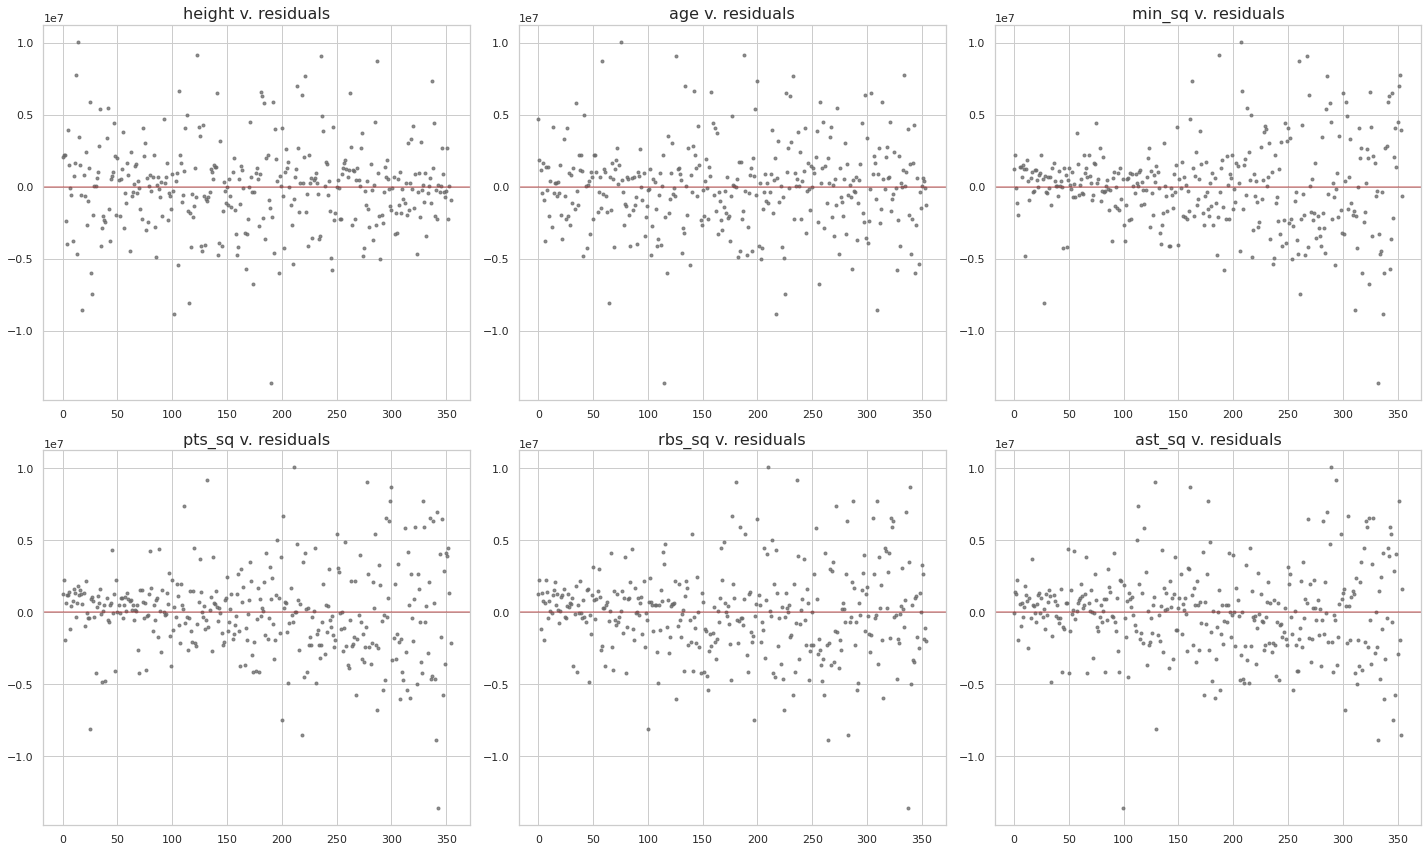

In [176]:
plot_residuals(contracts, ['height', 'age', 'min_sq', 'pts_sq', 'rbs_sq', 'ast_sq'], result, (2, 3), size=(20,12))

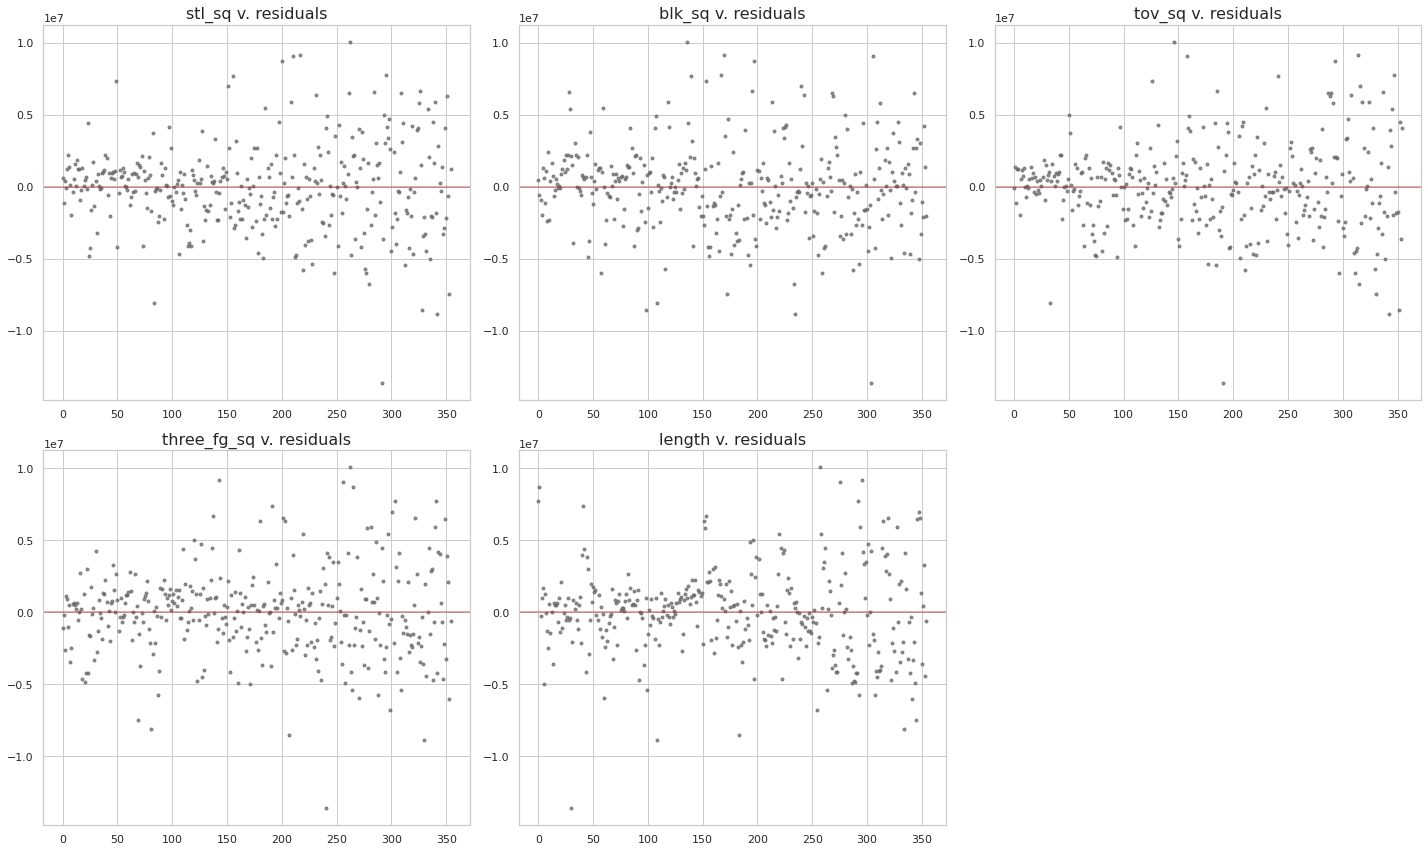

In [177]:
plot_residuals(contracts, ['stl_sq', 'blk_sq', 'tov_sq', 'three_fg_sq', 'length'], result, (2, 3), size=(20,12))

These residual plots look very similar to the ones in the recent models I have been working with.

One final thing to note about length: All of the other features are things that we would know about the player before signing the new contract, such as personal information, statistics, the type of contract they will be signing, and the fact that they are changing teams. The length of the contract, like average dollars is something that will be discussed with the player in the negotiations, which means I am hesitant to include it in the model. What happens if I remove all length features from the model entirely?

In [178]:
X = ['height', 'age', 'min_sq', 'pts_sq',
     'rbs_sq', 'ast_sq', 'stl_sq', 'blk_sq', 'tov_sq', 'three_fg_sq',
     'RFA', 'chg_team',
     'short:pts', 'short:rbs', 'short:blk', 'short:efg_per',
     'short:ast', 'short:stl', 'short:three_fg',
     'tall:pts', 'tall:rbs', 'tall:blk', 'tall:efg_per',
     'tall:ast', 'tall:stl', 'tall:three_fg']
result = bootstrap_linear_reg(contracts, X, y)
output_bootstrap_results(result)

,Labels,Values,95% BCI Low,95% BCI High
0,intercept,"3,585,265.46","-28,199,836.80","29,028,640.37"
1,height,"-33,926.85","-371,486.55","371,896.07"
2,age,"-10,227.35","-127,015.57","116,322.46"
3,min_sq,263.27,"-3,051.00","5,445.76"
4,pts_sq,"49,674.91","33,888.70","69,352.98"
5,rbs_sq,"38,686.73","-22,505.22","101,324.64"
6,ast_sq,"350,682.65","180,198.23","646,506.62"
7,stl_sq,"88,544.10","-1,950,598.15","2,519,381.59"
8,blk_sq,"-546,132.46","-3,223,720.05","2,584,178.75"
9,tov_sq,"-790,450.43","-1,619,699.33","51,976.49"


The performance of the model worsens significantly, so I will leave these features in the model. But this is definitely something I will need to keep in the back of my head.

Lastly, after adding all the interaction terms, I want to take one final look at the coefficients, specifically the ones that differ from my original predictions.

In [179]:
X = ['height', 'age', 'min_sq', 'pts_sq',
     'rbs_sq', 'ast_sq', 'stl_sq', 'blk_sq', 'tov_sq', 'three_fg_sq',
     'RFA', 'chg_team', 'two_three_yr', 'four_five_yr', 'length',
     'short:pts', 'short:rbs', 'short:blk', 'short:efg_per',
     'short:ast', 'short:stl', 'short:three_fg',
     'tall:pts', 'tall:rbs', 'tall:blk', 'tall:efg_per',
     'tall:ast', 'tall:stl', 'tall:three_fg']
result = bootstrap_linear_reg(contracts, X, y)
output_bootstrap_results(result)

,Labels,Values,95% BCI Low,95% BCI High
0,intercept,"-11,686,654.34","-36,211,314.26","4,355,370.55"
1,height,"57,278.89","-149,183.79","367,094.20"
2,age,"116,477.02","31,664.55","221,659.00"
3,min_sq,"-2,137.18","-4,933.79",254.59
4,pts_sq,"40,378.57","29,780.59","49,748.58"
5,rbs_sq,"6,432.15","-41,156.36","45,900.43"
6,ast_sq,"241,141.08","142,252.35","404,133.61"
7,stl_sq,"929,328.89","-227,224.69","2,205,653.13"
8,blk_sq,"-376,273.28","-1,877,392.81","1,468,250.21"
9,tov_sq,"-434,654.38","-948,022.96","180,783.82"


The coefficients for min_sq, blk_sq, tov_sq, three_fg_sq, type, chg_team, two_three_year, and four_five year are all different signs than I would have expected. Since their Bayesian Credible Intervals contain zero, let's see how the model runs if I remove these features entirely from the model.

In [180]:
X = ['height', 'age', 'pts_sq',
     'rbs_sq', 'ast_sq', 'stl_sq',
     'length',
     'short:pts', 'short:rbs', 'short:blk', 'short:efg_per',
     'short:ast', 'short:stl', 'short:three_fg',
     'tall:pts', 'tall:rbs', 'tall:blk', 'tall:efg_per',
     'tall:ast', 'tall:stl', 'tall:three_fg']
result = bootstrap_linear_reg(contracts, X, y)
output_bootstrap_results(result)

,Labels,Values,95% BCI Low,95% BCI High
0,intercept,"-8,960,022.70","-29,701,554.36","8,590,168.26"
1,height,"27,592.64","-222,074.36","294,105.66"
2,age,"114,911.59","13,955.87","197,019.84"
3,pts_sq,"37,485.07","29,523.22","46,828.20"
4,rbs_sq,"-12,369.51","-55,421.93","15,386.32"
5,ast_sq,"225,707.37","90,220.89","446,343.92"
6,stl_sq,"424,599.71","-1,272,458.92","1,570,103.66"
7,length,"3,010,718.94","2,505,211.08","3,399,033.70"
8,short:pts,"-421,964.70","-907,680.78","51,195.58"
9,short:rbs,"542,846.53","-583,151.95","1,793,561.32"


The model does perform slightly worse than the last model. Let's take a look at the residual plot.

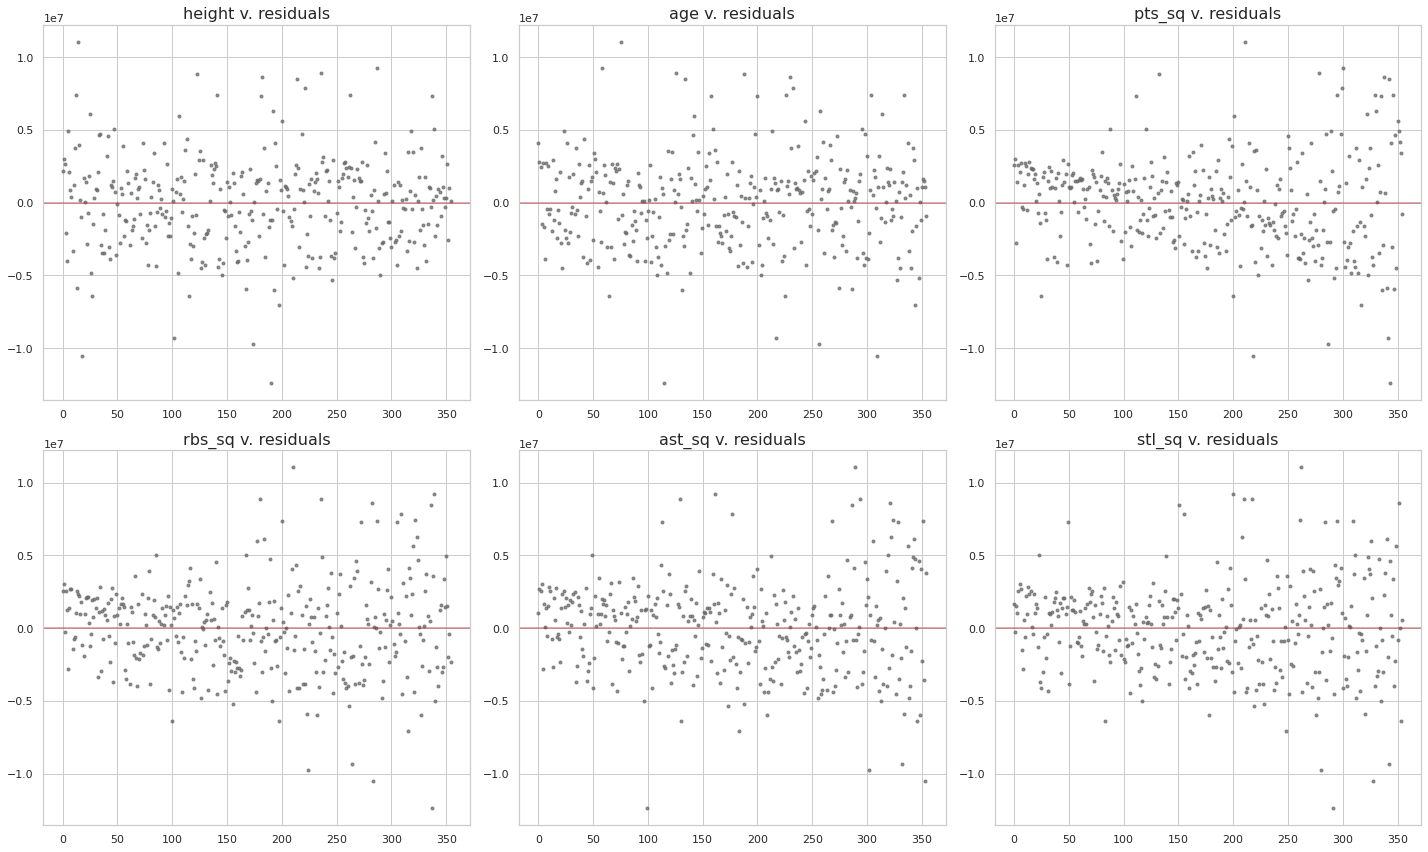

In [181]:
plot_residuals(contracts, ['height', 'age', 'pts_sq', 'rbs_sq', 'ast_sq', 'stl_sq'], result, (2, 3), size=(20,12))

These residual plots still look very similar to the previous model, as the higher errors are occuring at the higher values for each feature. Because the values of $R^2$, $\bar{R^2}$, and $\sigma$ all worsened, I will revert back to the previous model.

In [182]:
X = ['height', 'age', 'min_sq', 'pts_sq',
     'rbs_sq', 'ast_sq', 'stl_sq', 'blk_sq', 'tov_sq', 'three_fg_sq',
     'RFA', 'chg_team', 'two_three_yr', 'four_five_yr', 'length',
     'short:pts', 'short:rbs', 'short:blk', 'short:efg_per',
     'short:ast', 'short:stl', 'short:three_fg',
     'tall:pts', 'tall:rbs', 'tall:blk', 'tall:efg_per',
     'tall:ast', 'tall:stl', 'tall:three_fg']

### Model Evaluation

**Validation Curves**

For model evaluation, I am going to start by using validation curves to decide the best exponent to raise `pts` to. So far I have used `pts_sq` and normally validation curves are not used to pick the power to which you raise a feature. However, because points is so highly correlated with avg_dollars compared to the other features, I want to make sure squaring points is the right thing to do.

First I will make some additional features that relate to different powers of pts.

In [183]:
contracts['pts_3'] = contracts['pts']**3
contracts['pts_4'] = contracts['pts']**4
contracts['pts_5'] = contracts['pts']**5
contracts['pts_6'] = contracts['pts']**6
contracts['pts_7'] = contracts['pts']**7
contracts['pts_8'] = contracts['pts']**8
contracts['pts_9'] = contracts['pts']**9

Next, I need to set X to include all the features in the model except for `pts_sq`.

In [184]:
X_no_pts = ['height', 'age', 'min_sq',
     'rbs_sq', 'ast_sq', 'stl_sq', 'blk_sq', 'tov_sq', 'three_fg_sq',
     'RFA', 'chg_team', 'two_three_yr', 'four_five_yr', 'length',
     'short:pts', 'short:rbs', 'short:blk', 'short:efg_per',
     'short:ast', 'short:stl', 'short:three_fg',
     'tall:pts', 'tall:rbs', 'tall:blk', 'tall:efg_per',
     'tall:ast', 'tall:stl', 'tall:three_fg']

Next I will calculate and plot validation curves where the model performs cross validation on different models, where each model contains a different points feature.

In [185]:
result = validation_curves_features(contracts, X_no_pts, y,
                                    [['pts'], ['pts_sq'], ['pts_3'], ['pts_4'], ['pts_5'], ['pts_6'], ['pts_7'], ['pts_8'], ['pts_9']],
                                    lambda x: (x['sigma']), fold_count=10, seed=14141423)

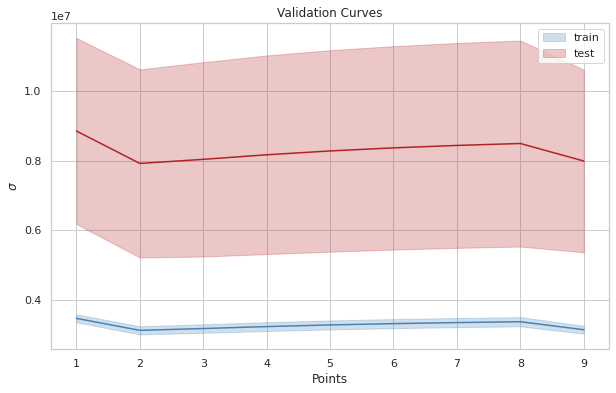

In [186]:
plot_validation_curves(result, '$\sigma$', 'Points', list(range(1,10)))

We see here that $\sigma$ is at a minimum when points is squared. Originally, I chose to square points based on the shape of the residual plot and what I saw in EDA. If another feature had shown a lower $\sigma$, I would have considered using it only after looking at the residual plots and the effect it had on the model. Nevertheless, seeing that the minimum $\sigma$ is achieved with points squared is good and I will proceed.

**k Fold Cross Validation**

Next, I would like to perform k fold cross validation on the model to test how the model performs against unseen data. To start, I will perform 3 repititions of 10 fold cross validation.

In [187]:
result = cross_validation(contracts, X, y, lambda x: (x['sigma']), fold_count=10, seed=14141424)

We can look at the mean $\sigma$ across the cross validation.

In [188]:
print("mean sigma: ", np.mean(result))

mean sigma:  6968032.953670354


The mean $\sigma$ is just under 7 million dollars. To be honest, this is higher than expected, especially since the $\sigma$ for the model was around 3.1 million dollars. This means that the model performs much worse on data that it has not seen, which is not great.

Let's see what happens if I change the fold count to 5.

In [189]:
result = cross_validation(contracts, X, y, lambda x: (x['sigma']), fold_count=5, seed=14141425)
print("mean sigma: ", np.mean(result))

mean sigma:  3990527.7378494716


Interesting. Even though the model trains on less data, the mean $\sigma$ is lower. What if I do a fold count of 3?

In [190]:
result = cross_validation(contracts, X, y, lambda x: (x['sigma']), fold_count=3, seed=14141426)
print("mean sigma: ", np.mean(result))

mean sigma:  3678239.9477819535


This $\sigma$ is even better. Unfortunately, due to the relatively small size of the data set, I cannot test larger values for the fold count. This is because if I increase the number of folds there will be less observations than features, which is no good.

My interpretation of this is that the there are some observations that the model does exceptionally bad on. When the number of folds is high, there are a low number of observations in the test set. If one of these observations is in this small test set, then that value of $\sigma$ is going to be contributing to the mean $\sigma$. As there are not that many test observations, there are less observations to balance out the overall average.

For now, I will move forward using 8 folds.

In [191]:
result = cross_validation(contracts, X, y, lambda x: (x['sigma']), fold_count=8, seed=14141427)
print("mean sigma: ", np.mean(result))

mean sigma:  5061699.763413427


Also, I can estimate creible bounds, as 3 rounds of 10 fold cross validation is essentially a Bootstrap estimate of the metric.

In [192]:
print(r"95% CI for sigma:", stats.mstats.mquantiles(result, [0.025, 0.975]))

95% CI for sigma: [4004171.59578246 6312499.01755691]


Also, I can take a bootstrap of the results to estimate the average performance of the model when performing 3 repetitions of 10 fold cross validation on this data. I will take the 1000 random samples of the `result` array and compute the mean of this sample.

In [193]:
np.random.seed(14)

bootstrap_sigma = np.array([np.mean(s) for s in [resample(result) for i in range( 0, 1000)]])

I can use these Bootstraps to compute the 95% Credible Intervals for $\sigma$

In [194]:
print(r"95% CI for *mean* sigma:", stats.mstats.mquantiles(bootstrap_sigma, [0.025, 0.975]))

95% CI for *mean* sigma: [4790489.70839021 5349291.54636237]


The 95% Credible Interval for \*mean\* $\sigma$ is between 4.79 million and 5.35 million. This means that there is a 95% chance that the true \*mean\* $\sigma$ for this model when performing 3 repetitions of 8 fold cross validation on this data is between 4.79 and 5.35 million.

**Learning Curves**

Next, I want to use learning curves to assess the bias/variance tradeoff and ways to potentially improve the model.

In [195]:
result = learning_curves(contracts, X, y, lambda r: r["sigma"], fold_count=8, increment=4, seed=14141429)

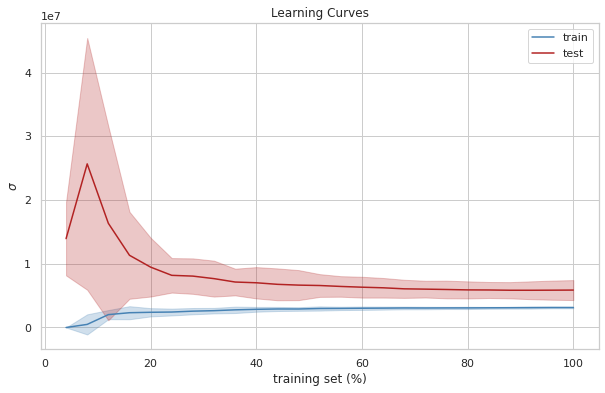

In [196]:
plot_learning_curves(result, r'$\sigma$')

From this view, it seems as if the values of $\sigma$ have leveled off for both the training set and the test set. However, this is a weird scale, so zooming in might help to see this better.

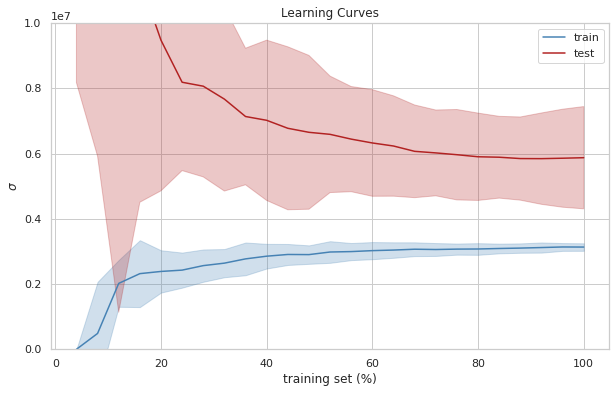

In [197]:
plot_learning_curves(result, r'$\sigma$', zoom=(0,10000000))

While the values of $\sigma$ do not level off quite as quickly as it appeared in the last view, they do seem to level off after the training set is 80% of the training set chunk. For experiment sake, what would have if we looked at 10 fold cross validation instead of 8?

In [198]:
result = learning_curves(contracts, X, y, lambda r: r["sigma"], fold_count=10, increment=4, seed=14141429)

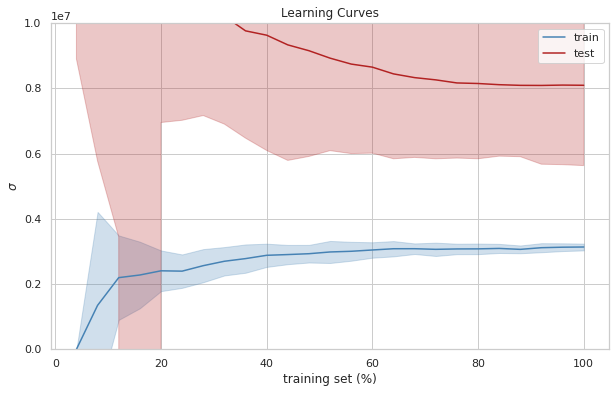

In [199]:
plot_learning_curves(result, r'$\sigma$', zoom=(0,10000000))

We can see again that values of $\sigma$ do level off around the 80% of the training set mark. However, as expected with this particular model and data set, the value for $\sigma$ is higher for the 10 fold cross validation.

In terms of bias/variance tradeoff, the model leans on the bias side of the tradeoff. I think this because the values displayed in the learning curve have leveled off before reaching 100% of the trading set. Thus, adding data likely would not make a huge difference. Ultimately, the success of the model comes down to if it is at or below the accepted error. If we said the accepted error was $\sigma = 5,000,000$:

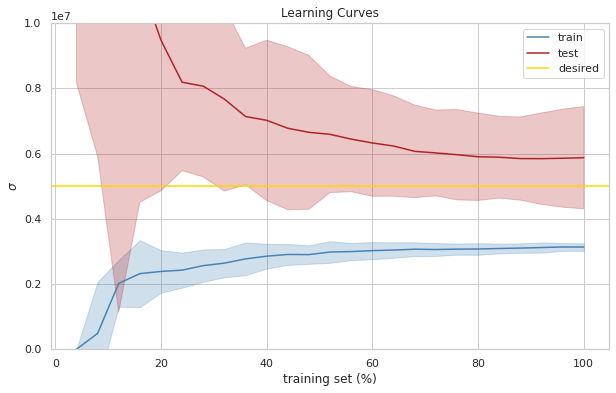

In [200]:
result = learning_curves(contracts, X, y, lambda r: r["sigma"], fold_count=8, increment=4, seed=14141429)
plot_learning_curves(result, r'$\sigma$', desired=5000000, zoom=(0,10000000))

We can see that model 5 million is in the credible interval for the test set, but it the actual value of $\sigma$ is above it around 6 million. The training set value for $\sigma$ is way below this. If I wanted to try and improve this model, I would look to add more features, maybe by finding more statistics to use, or decreasing regularization. I will also add that while this learning curve shows tht getting more data might not help the model that much, it would be nice to have slighly bigger test sets when running cross validation, espicially based on the number of features in the model. Therefore, if data on free agents was able further back than the last 3 seasons, that would be nice to get.

## Final Thoughts

Ultimately, the Linear Regression model that I created has decent values for $R^2$, $\bar{R^2}$, and $\sigma$. However, the value for $\sigma$ is not as good when tested on unseen data. The model tends to perform worst on data that is near the higher values for different statistical categories, such as points or rebounds. We see this in the residual plots for these statistics. Thus, the model probably performs worst on players who are set to receive larger contracts. There is a general concesus in the league as to which players will receive "max" contracts. Thus, the model may not be needed for these particular players, which is where the model performs the worst. The situations where the model is needed is for players that will be receiving between minimum and maximum contracts. This model likely performs much better for these players.

In [201]:
y = 'avg_dollars'
X = ['height', 'age', 'min_sq', 'pts_sq',
     'rbs_sq', 'ast_sq', 'stl_sq', 'blk_sq', 'tov_sq', 'three_fg_sq',
     'RFA', 'chg_team', 'two_three_yr', 'four_five_yr', 'length',
     'short:pts', 'short:rbs', 'short:blk', 'short:efg_per',
     'short:ast', 'short:stl', 'short:three_fg',
     'tall:pts', 'tall:rbs', 'tall:blk', 'tall:efg_per',
     'tall:ast', 'tall:stl', 'tall:three_fg']
result = bootstrap_linear_reg(contracts, X, y)

## Predictions

Now that the model is built, the front office is able to bring us players that they want salary esitmates for. As the list of free agents for 2022 is [already available](https://www.spotrac.com/nba/free-agents/), the team has given us the following players to look into:

**Montrez Harrell**

**Dennis Schroder**

**Pat Connaughton**

### Montrez Harrell

Montrez Harrell is an interesting player currently playing for the Washington Wizards. Montrez Harrell won the 6th Man of the Year award in 2020, but had a really poor showing in the 2020 playoffs, with many media members critizing his defensive ability. After an up and down 2021 season, Montrez Harrell was traded to the Washington Wizards. Set to enter free agency in 2022, Montrez Harrell currently has the following stats for this season [(via BasketballReference)](https://www.basketball-reference.com/players/h/harremo01.html)

Min: 26.1
<br>Pts: 14.9
<br>Rbs: 7.9
<br>Ast: 2.1
<br>Stl: 0.6
<br>Blk: 0.7
<br>Tov: 1.3
<br>Three_FG: 0.1
<br>eFG_per: 0.647

Harrell is 6'7 (79 inches) and will be 28.5 when free agency happens next summer. He will be an Unrestricted Free Agent and is said to be looking for a 3 year contract.

I will start by creating a new DataFrame `free_agents` and adding Harrell to it. 

In [202]:
free_agents = pd.DataFrame(data={}, columns=['name', 'height', 'age', 'min', 'pts', 'rbs', 'ast', 'stl',
                                             'blk', 'tov', 'three_fg', 'efg_per'])

In [203]:
free_agents.loc[0] = ['Montrez Harrell', 79, 28.5, 26.1, 14.9, 7.9, 2.1, 0.6, 0.7, 1.3, 0.1, 0.647]

In [204]:
free_agents.head()

,name,height,age,min,pts,rbs,ast,stl,blk,tov,three_fg,efg_per
0,Montrez Harrell,79,28.50,26.10,14.90,7.90,2.10,0.60,0.70,1.30,0.10,0.65


Now, I will create the necessary features for the model. First I will get the squared features

In [205]:
free_agents['pts_sq'] = free_agents['pts']**2
free_agents['min_sq'] = free_agents['min']**2
free_agents['rbs_sq'] = free_agents['rbs']**2
free_agents['ast_sq'] = free_agents['ast']**2
free_agents['stl_sq'] = free_agents['stl']**2
free_agents['blk_sq'] = free_agents['blk']**2
free_agents['tov_sq'] = free_agents['tov']**2
free_agents['three_fg_sq'] = free_agents['three_fg']**2

Next, I will decide which height group the player falls into and compute the various interaction terms.

In [206]:
free_agents['short'] = [1 if x<=76 else 0 for x in free_agents['height']]
free_agents['tall'] = [1 if x>=82 else 0 for x in free_agents['height']]
free_agents['medium'] = [1 if x[0]+x[1] != 1 else 0 for x in zip(free_agents['short'], free_agents['tall'])]

In [207]:
free_agents['short:pts'] = free_agents['short'] * free_agents['pts']
free_agents['short:rbs'] = free_agents['short'] * free_agents['rbs']
free_agents['short:blk'] = free_agents['short'] * free_agents['blk']
free_agents['short:efg_per'] = free_agents['short'] * free_agents['efg_per']
free_agents['short:ast'] = free_agents['short'] * free_agents['ast']
free_agents['short:stl'] = free_agents['short'] * free_agents['stl']
free_agents['short:three_fg'] = free_agents['short'] * free_agents['three_fg']

free_agents['tall:pts'] = free_agents['tall'] * free_agents['pts']
free_agents['tall:rbs'] = free_agents['tall'] * free_agents['rbs']
free_agents['tall:blk'] = free_agents['tall'] * free_agents['blk']
free_agents['tall:efg_per'] = free_agents['tall'] * free_agents['efg_per']
free_agents['tall:ast'] = free_agents['tall'] * free_agents['ast']
free_agents['tall:stl'] = free_agents['tall'] * free_agents['stl']
free_agents['tall:three_fg'] = free_agents['tall'] * free_agents['three_fg']

Next, I will set `RFA` and `chg_team`.

In [208]:
free_agents['RFA'] = 0
free_agents['chg_team'] = 1

Lastly, I will define the length and length binary features for Montrez.

In [209]:
free_agents['length'] = 3
free_agents['two_three_yr'] = 1
free_agents['four_five_yr'] = 0

In [210]:
free_agents.head()

,name,height,age,min,pts,rbs,ast,stl,blk,tov,...,tall:blk,tall:efg_per,tall:ast,tall:stl,tall:three_fg,RFA,chg_team,length,two_three_yr,four_five_yr
0,Montrez Harrell,79,28.50,26.10,14.90,7.90,2.10,0.60,0.70,1.30,...,0.00,0.00,0.00,0.00,0.00,0,1,3,1,0


Now, that Harrell's feature values have been calculated, I will predict his upcoming salary using the model.

In [211]:
m_harrell = [x for x in free_agents.loc[0][X].values]

In [212]:
predict(result, [m_harrell])

[array([15117095.02955979])]

The model predicts that Harrell will make just over 15 million dollars next season. This is an upgrade over the 9.7 million he is making this year. So far this season, Harrell is having a very good year, which explains the increase in pay from his last contract.

### Dennis Schroder

Dennis Schroder finished second in 6th Man of the Year voting to Montrez Harrell in 2020, but was traded to the Los Angeles Lakers in the offseason. In an now famous story, Schroder turned down a contract extension with the Lakers reportedly worth 21 million dollars annually over 4 years in hopes of earning more in free agency. However, the big offer never came and Schroder was forced to sign a 5.9 million dollar offer with the Boston Celtics. The reason Schroder chose the Celtics is that he thought the playing time and role the Celtics were offering him would allow him to rebuild his value to reenter free agency in 2022. So far in the season, here are Schroder's stats:

Min: 33.4
<br>Pts: 17.5
<br>Rbs: 3.6
<br>Ast: 4.9
<br>Stl: 0.9
<br>Blk: 0.0
<br>Tov: 2.6
<br>Three_FG: 1.6
<br>eFG_per: 0.500

Schroder is 6'3 (75 inches) and will be 28.8 when free agency happens next summer. He will be an Unrestricted Free Agent and is said to be looking for a 4 year contract.

I will start by adding Schroder to the `free_agents` DataFrame. 

In [213]:
free_agents.loc[1] = ['Dennis Schoder', 75, 28.8, 33.4, 17.5, 3.6, 4.9, 0.9, 0.0, 2.6, 1.6, 0.5] + 30*[0]

In [214]:
free_agents.head()

,name,height,age,min,pts,rbs,ast,stl,blk,tov,...,tall:blk,tall:efg_per,tall:ast,tall:stl,tall:three_fg,RFA,chg_team,length,two_three_yr,four_five_yr
0,Montrez Harrell,79,28.50,26.10,14.90,7.90,2.10,0.60,0.70,1.30,...,0.00,0.00,0.00,0.00,0.00,0,1,3,1,0
1,Dennis Schoder,75,28.80,33.40,17.50,3.60,4.90,0.90,0.00,2.60,...,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0


Now, I will create the necessary features for Schroder. First I will get the squared features.

In [215]:
free_agents.at[1,'pts_sq'] = free_agents.at[1,'pts']**2
free_agents.at[1,'min_sq'] = free_agents.at[1,'min']**2
free_agents.at[1,'rbs_sq'] = free_agents.at[1,'rbs']**2
free_agents.at[1,'ast_sq'] = free_agents.at[1,'ast']**2
free_agents.at[1,'stl_sq'] = free_agents.at[1,'stl']**2
free_agents.at[1,'blk_sq'] = free_agents.at[1,'blk']**2
free_agents.at[1,'tov_sq'] = free_agents.at[1,'tov']**2
free_agents.at[1,'three_fg_sq'] = free_agents.at[1,'three_fg']**2

Next, I will decide which height group Schroder falls into and compute the various interaction terms.

In [216]:
if free_agents.at[1,'height']<=76:
    free_agents.at[1,'short']=1
    free_agents.at[1,'medium']=0
    free_agents.at[1,'tall']=0
elif free_agents.at[1,'height']<=81:
    free_agents.at[1,'short']=0
    free_agents.at[1,'medium']=1
    free_agents.at[1,'tall']=0
else:
    free_agents.at[1,'short']=0
    free_agents.at[1,'medium']=0
    free_agents.at[1,'tall']=1

In [217]:
free_agents.at[1,'short:pts'] = free_agents.at[1,'short'] * free_agents.at[1,'pts']
free_agents.at[1,'short:rbs'] = free_agents.at[1,'short'] * free_agents.at[1,'rbs']
free_agents.at[1,'short:blk'] = free_agents.at[1,'short'] * free_agents.at[1,'blk']
free_agents.at[1,'short:efg_per'] = free_agents.at[1,'short'] * free_agents.at[1,'efg_per']
free_agents.at[1,'short:ast'] = free_agents.at[1,'short'] * free_agents.at[1,'ast']
free_agents.at[1,'short:stl'] = free_agents.at[1,'short'] * free_agents.at[1,'stl']
free_agents.at[1,'short:three_fg'] = free_agents.at[1,'short'] * free_agents.at[1,'three_fg']

free_agents.at[1,'tall:pts'] = free_agents.at[1,'tall'] * free_agents.at[1,'pts']
free_agents.at[1,'tall:rbs'] = free_agents.at[1,'tall'] * free_agents.at[1,'rbs']
free_agents.at[1,'tall:blk'] = free_agents.at[1,'tall'] * free_agents.at[1,'blk']
free_agents.at[1,'tall:efg_per'] = free_agents.at[1,'tall'] * free_agents.at[1,'efg_per']
free_agents.at[1,'tall:ast'] = free_agents.at[1,'tall'] * free_agents.at[1,'ast']
free_agents.at[1,'tall:stl'] = free_agents.at[1,'tall'] * free_agents.at[1,'stl']
free_agents.at[1,'tall:three_fg'] = free_agents.at[1,'tall'] * free_agents.at[1,'three_fg']

Next, I will set `RFA` and `chg_team`.

In [218]:
free_agents.at[1,'RFA'] = 0
free_agents.at[1,'chg_team'] = 1

Lastly, I will define the length and length binary features for Dennis.

In [219]:
free_agents.at[1,'length'] = 4
free_agents.at[1,'two_three_yr'] = 0
free_agents.at[1,'four_five_yr'] = 1

In [220]:
free_agents.head()

,name,height,age,min,pts,rbs,ast,stl,blk,tov,...,tall:blk,tall:efg_per,tall:ast,tall:stl,tall:three_fg,RFA,chg_team,length,two_three_yr,four_five_yr
0,Montrez Harrell,79,28.50,26.10,14.90,7.90,2.10,0.60,0.70,1.30,...,0.00,0.00,0.00,0.00,0.00,0,1,3,1,0
1,Dennis Schoder,75,28.80,33.40,17.50,3.60,4.90,0.90,0.00,2.60,...,0.00,0.00,0.00,0.00,0.00,0,1,4,0,1


Now, that Schroder's feature values have been calculated, I will predict his upcoming salary using the model.

In [221]:
d_schroder = [x for x in free_agents.loc[1][X].values]

In [222]:
predict(result, [d_schroder])

[array([17356858.80622774])]

The model predicts that Schroder will make roughly 17.3 million dollars per year for the next four years. This is not quite the 21 million dollars per year that he turned down, but it is still a lot of money!

### Pat Connaughton

While both Montrez Harrell and Dennis Schroder are really good players, they are not known for their shooting. Harrell is known for his inside game and toughness and Schroder is known for his playmaking and quickness. In today's NBA, you also need guys who can knock down threes. Enter Pat Connaughton. Pat Connaughton shot 37% from three in the 2020-21 season, but is currently shooting 43% to start the 2021-2022 season. If he keeps this pace up, he could be in line for a nice new contract in the offseason. Let's see what the model says about Connaughton. Here are his statistics at the current moment.

Min: 28.8
<br>Pts: 12.1
<br>Rbs: 4.6
<br>Ast: 1.3
<br>Stl: 1.0
<br>Blk: 0.4
<br>Tov: 0.8
<br>Three_FG: 2.7
<br>eFG_per: 0.653

Connaughton is 6'5 (77 inches) and will be 29.5 when free agency happens next summer. He will be an Unrestricted Free Agent and is said to be looking for a 4 year contract.

I will start by adding Connaughton to the `free_agents` DataFrame. 

In [223]:
free_agents.loc[2] = ['Pat Connaughton', 77, 29.5, 28.8, 12.1, 4.6, 1.3, 1.0, 0.4, 0.8, 2.7, 0.653] + 30*[0]

In [224]:
free_agents

,name,height,age,min,pts,rbs,ast,stl,blk,tov,...,tall:blk,tall:efg_per,tall:ast,tall:stl,tall:three_fg,RFA,chg_team,length,two_three_yr,four_five_yr
0,Montrez Harrell,79,28.50,26.10,14.90,7.90,2.10,0.60,0.70,1.30,...,0.00,0.00,0.00,0.00,0.00,0,1,3,1,0
1,Dennis Schoder,75,28.80,33.40,17.50,3.60,4.90,0.90,0.00,2.60,...,0.00,0.00,0.00,0.00,0.00,0,1,4,0,1
2,Pat Connaughton,77,29.50,28.80,12.10,4.60,1.30,1.00,0.40,0.80,...,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0


Now, I will create the necessary features for Connaughton. First I will get the squared features.

In [225]:
free_agents.at[2,'pts_sq'] = free_agents.at[2,'pts']**2
free_agents.at[2,'min_sq'] = free_agents.at[2,'min']**2
free_agents.at[2,'rbs_sq'] = free_agents.at[2,'rbs']**2
free_agents.at[2,'ast_sq'] = free_agents.at[2,'ast']**2
free_agents.at[2,'stl_sq'] = free_agents.at[2,'stl']**2
free_agents.at[2,'blk_sq'] = free_agents.at[2,'blk']**2
free_agents.at[2,'tov_sq'] = free_agents.at[2,'tov']**2
free_agents.at[2,'three_fg_sq'] = free_agents.at[2,'three_fg']**2

Next, I will decide which height group Connaughton falls into and compute the various interaction terms.

In [226]:
if free_agents.at[2,'height']<=76:
    free_agents.at[2,'short']=1
    free_agents.at[2,'medium']=0
    free_agents.at[2,'tall']=0
elif free_agents.at[2,'height']<=81:
    free_agents.at[2,'short']=0
    free_agents.at[2,'medium']=1
    free_agents.at[2,'tall']=0
else:
    free_agents.at[2,'short']=0
    free_agents.at[2,'medium']=0
    free_agents.at[2,'tall']=1

In [227]:
free_agents.at[2,'short:pts'] = free_agents.at[2,'short'] * free_agents.at[2,'pts']
free_agents.at[2,'short:rbs'] = free_agents.at[2,'short'] * free_agents.at[2,'rbs']
free_agents.at[2,'short:blk'] = free_agents.at[2,'short'] * free_agents.at[2,'blk']
free_agents.at[2,'short:efg_per'] = free_agents.at[2,'short'] * free_agents.at[2,'efg_per']
free_agents.at[2,'short:ast'] = free_agents.at[2,'short'] * free_agents.at[2,'ast']
free_agents.at[2,'short:stl'] = free_agents.at[2,'short'] * free_agents.at[2,'stl']
free_agents.at[2,'short:three_fg'] = free_agents.at[2,'short'] * free_agents.at[2,'three_fg']

free_agents.at[2,'tall:pts'] = free_agents.at[2,'tall'] * free_agents.at[2,'pts']
free_agents.at[2,'tall:rbs'] = free_agents.at[2,'tall'] * free_agents.at[2,'rbs']
free_agents.at[2,'tall:blk'] = free_agents.at[2,'tall'] * free_agents.at[2,'blk']
free_agents.at[2,'tall:efg_per'] = free_agents.at[2,'tall'] * free_agents.at[2,'efg_per']
free_agents.at[2,'tall:ast'] = free_agents.at[2,'tall'] * free_agents.at[2,'ast']
free_agents.at[2,'tall:stl'] = free_agents.at[2,'tall'] * free_agents.at[2,'stl']
free_agents.at[2,'tall:three_fg'] = free_agents.at[2,'tall'] * free_agents.at[2,'three_fg']

Next, I will set `RFA` and `chg_team`.

In [228]:
free_agents.at[2,'RFA'] = 0
free_agents.at[2,'chg_team'] = 1

Lastly, I will define the length and length binary features for Pat.

In [229]:
free_agents.at[2,'length'] = 4
free_agents.at[2,'two_three_yr'] = 0
free_agents.at[2,'four_five_yr'] = 1

In [230]:
free_agents.head()

,name,height,age,min,pts,rbs,ast,stl,blk,tov,...,tall:blk,tall:efg_per,tall:ast,tall:stl,tall:three_fg,RFA,chg_team,length,two_three_yr,four_five_yr
0,Montrez Harrell,79,28.50,26.10,14.90,7.90,2.10,0.60,0.70,1.30,...,0.00,0.00,0.00,0.00,0.00,0,1,3,1,0
1,Dennis Schoder,75,28.80,33.40,17.50,3.60,4.90,0.90,0.00,2.60,...,0.00,0.00,0.00,0.00,0.00,0,1,4,0,1
2,Pat Connaughton,77,29.50,28.80,12.10,4.60,1.30,1.00,0.40,0.80,...,0.00,0.00,0.00,0.00,0.00,0,1,4,0,1


Now, that Connaughton's feature values have been calculated, I will predict his upcoming salary using the model.

In [231]:
p_connaughton = [x for x in free_agents.loc[2][X].values]

In [232]:
predict(result, [p_connaughton])

[array([15272202.66749128])]

The model predicts that Connaughton will make just over 15 million dollars next year, which is about 10 million more than he is making this season. This might be an example of one of the very high miscalculations by the model, but as the contract has not been signed yet, there is no way to know that at this point.

The front office does not want to spend that much money on Connaughton, especially when he has not really proved that level of shooting until this season. They are still interested in guards who can shoot to round out the team and have asked me to find a player like this who might be a little cheaper.

### Bryn Forbes

One option to target instead of Connaughton would be Bryn Forbes. Forbes currently is a SG for the San Antonio Spurs and is shooting 42.5% from three so far, albeit on lower attempts. Here are his other statistical numbers.

Min: 14.3
<br>Pts: 7.2
<br>Rbs: 1.2
<br>Ast: 0.7
<br>Stl: 0.4
<br>Blk: 0.0
<br>Tov: 0.9
<br>Three_FG: 1.2
<br>eFG_per: 0.564

Forbes is 6'2 (74 inches) and will be 29 when free agency happens next summer. He will be an Unrestricted Free Agent and is said to be looking for a 2 year contract.

I will start by adding Forbes to the `free_agents` DataFrame. 

In [233]:
free_agents.loc[3] = ['Bryn Forbes', 74, 29.0, 14.3, 7.2, 1.2, 0.7, 0.4, 0.0, 0.9, 1.2, 0.564] + 30*[0]

In [234]:
free_agents

,name,height,age,min,pts,rbs,ast,stl,blk,tov,...,tall:blk,tall:efg_per,tall:ast,tall:stl,tall:three_fg,RFA,chg_team,length,two_three_yr,four_five_yr
0,Montrez Harrell,79,28.50,26.10,14.90,7.90,2.10,0.60,0.70,1.30,...,0.00,0.00,0.00,0.00,0.00,0,1,3,1,0
1,Dennis Schoder,75,28.80,33.40,17.50,3.60,4.90,0.90,0.00,2.60,...,0.00,0.00,0.00,0.00,0.00,0,1,4,0,1
2,Pat Connaughton,77,29.50,28.80,12.10,4.60,1.30,1.00,0.40,0.80,...,0.00,0.00,0.00,0.00,0.00,0,1,4,0,1
3,Bryn Forbes,74,29.00,14.30,7.20,1.20,0.70,0.40,0.00,0.90,...,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0


Now, I will create the necessary features for Forbes. First I will get the squared features.

In [235]:
free_agents.at[3,'pts_sq'] = free_agents.at[3,'pts']**2
free_agents.at[3,'min_sq'] = free_agents.at[3,'min']**2
free_agents.at[3,'rbs_sq'] = free_agents.at[3,'rbs']**2
free_agents.at[3,'ast_sq'] = free_agents.at[3,'ast']**2
free_agents.at[3,'stl_sq'] = free_agents.at[3,'stl']**2
free_agents.at[3,'blk_sq'] = free_agents.at[3,'blk']**2
free_agents.at[3,'tov_sq'] = free_agents.at[3,'tov']**2
free_agents.at[3,'three_fg_sq'] = free_agents.at[3,'three_fg']**2

Next, I will decide which height group Forbes falls into and compute the various interaction terms.

In [236]:
if free_agents.at[3,'height']<=76:
    free_agents.at[3,'short']=1
    free_agents.at[3,'medium']=0
    free_agents.at[3,'tall']=0
elif free_agents.at[3,'height']<=81:
    free_agents.at[3,'short']=0
    free_agents.at[3,'medium']=1
    free_agents.at[3,'tall']=0
else:
    free_agents.at[3,'short']=0
    free_agents.at[3,'medium']=0
    free_agents.at[3,'tall']=1

In [237]:
free_agents.at[3,'short:pts'] = free_agents.at[3,'short'] * free_agents.at[3,'pts']
free_agents.at[3,'short:rbs'] = free_agents.at[3,'short'] * free_agents.at[3,'rbs']
free_agents.at[3,'short:blk'] = free_agents.at[3,'short'] * free_agents.at[3,'blk']
free_agents.at[3,'short:efg_per'] = free_agents.at[3,'short'] * free_agents.at[3,'efg_per']
free_agents.at[3,'short:ast'] = free_agents.at[3,'short'] * free_agents.at[3,'ast']
free_agents.at[3,'short:stl'] = free_agents.at[3,'short'] * free_agents.at[3,'stl']
free_agents.at[3,'short:three_fg'] = free_agents.at[3,'short'] * free_agents.at[3,'three_fg']

free_agents.at[3,'tall:pts'] = free_agents.at[3,'tall'] * free_agents.at[3,'pts']
free_agents.at[3,'tall:rbs'] = free_agents.at[3,'tall'] * free_agents.at[3,'rbs']
free_agents.at[3,'tall:blk'] = free_agents.at[3,'tall'] * free_agents.at[3,'blk']
free_agents.at[3,'tall:efg_per'] = free_agents.at[3,'tall'] * free_agents.at[3,'efg_per']
free_agents.at[3,'tall:ast'] = free_agents.at[3,'tall'] * free_agents.at[3,'ast']
free_agents.at[3,'tall:stl'] = free_agents.at[3,'tall'] * free_agents.at[3,'stl']
free_agents.at[3,'tall:three_fg'] = free_agents.at[3,'tall'] * free_agents.at[3,'three_fg']

Next, I will set `RFA` and `chg_team`.

In [238]:
free_agents.at[3,'RFA'] = 0
free_agents.at[3,'chg_team'] = 1

Lastly, I will define the length and length binary features for Forbes.

In [239]:
free_agents.at[3,'length'] = 2
free_agents.at[3,'two_three_yr'] = 1
free_agents.at[3,'four_five_yr'] = 0

In [240]:
free_agents.head()

,name,height,age,min,pts,rbs,ast,stl,blk,tov,...,tall:blk,tall:efg_per,tall:ast,tall:stl,tall:three_fg,RFA,chg_team,length,two_three_yr,four_five_yr
0,Montrez Harrell,79,28.50,26.10,14.90,7.90,2.10,0.60,0.70,1.30,...,0.00,0.00,0.00,0.00,0.00,0,1,3,1,0
1,Dennis Schoder,75,28.80,33.40,17.50,3.60,4.90,0.90,0.00,2.60,...,0.00,0.00,0.00,0.00,0.00,0,1,4,0,1
2,Pat Connaughton,77,29.50,28.80,12.10,4.60,1.30,1.00,0.40,0.80,...,0.00,0.00,0.00,0.00,0.00,0,1,4,0,1
3,Bryn Forbes,74,29.00,14.30,7.20,1.20,0.70,0.40,0.00,0.90,...,0.00,0.00,0.00,0.00,0.00,0,1,2,1,0


Now, that Forbes' feature values have been calculated, I will predict his upcoming salary using the model.

In [241]:
b_forbes = [x for x in free_agents.loc[3][X].values]

In [242]:
predict(result, [b_forbes])

[array([3350926.24831904])]

The model predicts that Forbes will make 3.35 million dollars next year, which is significantly lower than Connaughton. While Forbes is playing and shooting less than Connaughton currently, this percentages suggest that he could be very productive if given more time. This might be a very good bargain for Seattle. I want to take a look at one more potential option.

### Trey Burke

Another option is Trey Burke. Burke is currently a point guard for the Dallas Mavericks and is shooting 42.3% from three so far. Here are his other statistical numbers.

Min: 11.3
<br>Pts: 6.4
<br>Rbs: 0.7
<br>Ast: 1.6
<br>Stl: 0.4
<br>Blk: 0.0
<br>Tov: 0.9
<br>Three_FG: 0.8
<br>eFG_per: 0.52

Burke is 6'0 (72 inches) and will be 29.5 when free agency happens next summer. He will be an Unrestricted Free Agent and is said to be looking for a 1 year contract.

I will start by adding Burke to the `free_agents` DataFrame. 

In [243]:
free_agents.loc[4] = ['Trey Burke', 72, 29.5, 11.3, 6.4, 0.7, 1.6, 0.4, 0.0, 0.9, 0.8, 0.520] + 30*[0]

In [244]:
free_agents

,name,height,age,min,pts,rbs,ast,stl,blk,tov,...,tall:blk,tall:efg_per,tall:ast,tall:stl,tall:three_fg,RFA,chg_team,length,two_three_yr,four_five_yr
0,Montrez Harrell,79,28.50,26.10,14.90,7.90,2.10,0.60,0.70,1.30,...,0.00,0.00,0.00,0.00,0.00,0,1,3,1,0
1,Dennis Schoder,75,28.80,33.40,17.50,3.60,4.90,0.90,0.00,2.60,...,0.00,0.00,0.00,0.00,0.00,0,1,4,0,1
2,Pat Connaughton,77,29.50,28.80,12.10,4.60,1.30,1.00,0.40,0.80,...,0.00,0.00,0.00,0.00,0.00,0,1,4,0,1
3,Bryn Forbes,74,29.00,14.30,7.20,1.20,0.70,0.40,0.00,0.90,...,0.00,0.00,0.00,0.00,0.00,0,1,2,1,0
4,Trey Burke,72,29.50,11.30,6.40,0.70,1.60,0.40,0.00,0.90,...,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0


Now, I will create the necessary features for Burke. First I will get the squared features.

In [245]:
free_agents.at[4,'pts_sq'] = free_agents.at[4,'pts']**2
free_agents.at[4,'min_sq'] = free_agents.at[4,'min']**2
free_agents.at[4,'rbs_sq'] = free_agents.at[4,'rbs']**2
free_agents.at[4,'ast_sq'] = free_agents.at[4,'ast']**2
free_agents.at[4,'stl_sq'] = free_agents.at[4,'stl']**2
free_agents.at[4,'blk_sq'] = free_agents.at[4,'blk']**2
free_agents.at[4,'tov_sq'] = free_agents.at[4,'tov']**2
free_agents.at[4,'three_fg_sq'] = free_agents.at[4,'three_fg']**2

Next, I will decide which height group Burke falls into and compute the various interaction terms.

In [246]:
if free_agents.at[4,'height']<=76:
    free_agents.at[4,'short']=1
    free_agents.at[4,'medium']=0
    free_agents.at[4,'tall']=0
elif free_agents.at[4,'height']<=81:
    free_agents.at[4,'short']=0
    free_agents.at[4,'medium']=1
    free_agents.at[4,'tall']=0
else:
    free_agents.at[4,'short']=0
    free_agents.at[4,'medium']=0
    free_agents.at[4,'tall']=1

In [247]:
free_agents.at[4,'short:pts'] = free_agents.at[4,'short'] * free_agents.at[4,'pts']
free_agents.at[4,'short:rbs'] = free_agents.at[4,'short'] * free_agents.at[4,'rbs']
free_agents.at[4,'short:blk'] = free_agents.at[4,'short'] * free_agents.at[4,'blk']
free_agents.at[4,'short:efg_per'] = free_agents.at[4,'short'] * free_agents.at[4,'efg_per']
free_agents.at[4,'short:ast'] = free_agents.at[4,'short'] * free_agents.at[4,'ast']
free_agents.at[4,'short:stl'] = free_agents.at[4,'short'] * free_agents.at[4,'stl']
free_agents.at[4,'short:three_fg'] = free_agents.at[4,'short'] * free_agents.at[4,'three_fg']

free_agents.at[4,'tall:pts'] = free_agents.at[4,'tall'] * free_agents.at[4,'pts']
free_agents.at[4,'tall:rbs'] = free_agents.at[4,'tall'] * free_agents.at[4,'rbs']
free_agents.at[4,'tall:blk'] = free_agents.at[4,'tall'] * free_agents.at[4,'blk']
free_agents.at[4,'tall:efg_per'] = free_agents.at[4,'tall'] * free_agents.at[4,'efg_per']
free_agents.at[4,'tall:ast'] = free_agents.at[4,'tall'] * free_agents.at[4,'ast']
free_agents.at[4,'tall:stl'] = free_agents.at[4,'tall'] * free_agents.at[4,'stl']
free_agents.at[4,'tall:three_fg'] = free_agents.at[4,'tall'] * free_agents.at[4,'three_fg']

Next, I will set `RFA` and `chg_team`.

In [248]:
free_agents.at[4,'RFA'] = 0
free_agents.at[4,'chg_team'] = 1

Lastly, I will define the length and length binary features for Burke.

In [249]:
free_agents.at[4,'length'] = 1
free_agents.at[4,'two_three_yr'] = 0
free_agents.at[4,'four_five_yr'] = 0

In [250]:
free_agents.head()

,name,height,age,min,pts,rbs,ast,stl,blk,tov,...,tall:blk,tall:efg_per,tall:ast,tall:stl,tall:three_fg,RFA,chg_team,length,two_three_yr,four_five_yr
0,Montrez Harrell,79,28.50,26.10,14.90,7.90,2.10,0.60,0.70,1.30,...,0.00,0.00,0.00,0.00,0.00,0,1,3,1,0
1,Dennis Schoder,75,28.80,33.40,17.50,3.60,4.90,0.90,0.00,2.60,...,0.00,0.00,0.00,0.00,0.00,0,1,4,0,1
2,Pat Connaughton,77,29.50,28.80,12.10,4.60,1.30,1.00,0.40,0.80,...,0.00,0.00,0.00,0.00,0.00,0,1,4,0,1
3,Bryn Forbes,74,29.00,14.30,7.20,1.20,0.70,0.40,0.00,0.90,...,0.00,0.00,0.00,0.00,0.00,0,1,2,1,0
4,Trey Burke,72,29.50,11.30,6.40,0.70,1.60,0.40,0.00,0.90,...,0.00,0.00,0.00,0.00,0.00,0,1,1,0,0


Now, that Burke's feature values have been calculated, I will predict his upcoming salary using the model.

In [251]:
t_burke = [x for x in free_agents.loc[4][X].values]

In [252]:
predict(result, [t_burke])

[array([627791.0703349])]

The model predicts that Burke will only be offered a contract of 628000 dollar contract. This is a little off because of the NBA salary minimums. As someone who will have been in the league for 9 seasons at the start of next year, the minimum salary Burke can make is 2401537 dollars. However, the model does show that a player producing at Burke's level will likely not sign above this minimum.

While the model had Connaughton's salary over 15 million dollars per season, I have found a couple cheaper options for the front office to consider in Bryn Forbes and Trey Burke.

In [253]:
con.close()